This notebook collects several tests for `GridSPT.jl` designed to verify its behavior coincides with the original C++ version. Unless specified in a header named "GPU", these tests are run with the core module `GridSPTCore`, which provides the core components used for any extension upon the original code. `GridSPTGPU` is one (and so far only) of these extension, which enables to port all operations to the GPU for increased performance (over 10x speed-up, see the section dedicated to benchmarks). The code expands the functionality of the original by:

1. sampling it's own initial field via `get_GRF` and `get_δₖL`;
2. controlling new parameters, like the order of perturbation theory and the direction of the line-of-sight for redshift space quantities;
3. setting the number of cores to be used for multithreading (achieved by launching Julia with the `-p [# of cores]` flag);
4. exposing to the user all the basic operations to construct their own iterative perturbation theory solvers and pass it to `real_space_spt` and `redshift_space_spt`;
5. returning not only the real space density, but also the velocity field, its divergence and the gradient of the density;
6. computing redshift space perturbation theory up to arbitrary order (before was limited to 6th order);
7. exploiting GPU acceleration with custom CUDA kernels for incresed performance;
8. providing the rrules to make the code compatible with reverse-mode autodifferentiation packages (so far only [`Zygote`](https://fluxml.ai/Zygote.jl/latest/) has been tested).

**CURRENT BUGS**

1. [NON-TRIVIAL] When autodifferentiating the spatial gradient operation on the CPU, the slice along the direction over which the gradient is evaluated against the data in the autodifferentiated function returns inexact values for the Nyquist frequency (and only for the Nyquist frequency); this might be due to strange behavior of Zygote when slicing the array, or it might be some issue in the way the FFT is handled during autodifferentiation, however the same behavior is not observed in the autodifferentiation of the velocity operation (which is entirely equivalent in terms of computation and rrules).
2. [NON-TRIVIAL] Same as above on GPU, however also the 0-frequency slice presents the same behavior.
3. The autodifferentiation of the velocity on the GPU yields the incorrect result. It is probably a fault in the way the code was written, and if so it will be fixed promptly.
4. `^` in CUDA is not handled with a rrule during autodiff, making the redshift space computation currently not AD-ready on the GPU. This will be soon fixed by an appropriate custom rrule.

---

To start:
1. Activate the virtual environment in `/home/matteoperon/projects/julia/GridSPT/test/` using `source venv/source/activate`
2. Start Julia with `julia`
3. in the Pkg environment (press `]` in the REPL) input `activate .`
4. back in the REPL, launch `using IJulia` and `notebook()`
5. In a browser, navigate to http://localhost:8888
6. If 5. doesn't work, run `jupyter notebook list` to locate the link of this notebook

# 1 IC generator and filtering

This section is to compare and test the functions currently implemented to handle initial conditions and filtering.

In [1]:
using GridSPTCore: GridSPTCore as gspt
using GridSPTGPU: GridSPTGPU as ggspt
using PyPlot
using PyCall
using Dierckx
using Interpolations
using FFTW

In [40]:
# Functions to read C++ array files consistently in Julia

function load_real_field(::Type{T}, fn::String, Ng::Integer) where T<:Real
    field = reinterpret(T, read(fn))
    field3D = Array{T, 3}(undef, Ng, Ng, Ng)
    
    @inbounds for a in 1:Ng
        @inbounds for b in 1:Ng
            @inbounds for c in 1:Ng
                current = Int(((a-1)*Ng+(b-1))*(2*(÷(Ng, 2)+1))+c)
                field3D[a, b, c] = field[current]
            end
        end
    end

    return permutedims(field3D, [3, 2, 1])
end

function load_complex_field(::Type{T}, fn::String, Ng::Integer) where T<:Real
    field = reinterpret(T, read(fn))
    field3D = Array{Complex{T}, 3}(undef, Ng, Ng, ÷(Ng, 2)+1)
    
    @inbounds for a in 1:Ng
        @inbounds for b in 1:Ng
            @inbounds for c in 1:÷(Ng, 2)+1
                current_re = Int(((a-1)*Ng+(b-1))*(2*(÷(Ng, 2)+1))+2*(c-1)+1)
                current_im = Int(((a-1)*Ng+(b-1))*(2*(÷(Ng, 2)+1))+2*(c-1)+2)
                field3D[a, b, c] = complex(field[current_re], field[current_im])
            end
        end
    end

    return permutedims(field3D, [3, 2, 1])
end

# function to read text files column-wise

function load_Pₗ(::Type{T}, fn::String) where T<:Real
    local x, y
    open(fn) do f
        lines = readlines(f)
        x = [parse(T, split(line, " ")[1]) for line in lines]
        y = [parse(T, split(line, " ")[2]) for line in lines]
    end

    pushfirst!(x, T(0))
    pushfirst!(y, T(0))
    return x, y
end

# Functions to compute the real-space power spectrum

function Pₖ_of(field::Array{Complex{T}}, frequencies::Array{T, 3}, bins::Vector{T}, L::Real, Ng::Integer) where T<:Real
    ℱfield = field/Ng^3 # forward-normalize rfft
    
    kₘ = (bins[begin:end-1]+bins[begin+1:end])/2
    Δk = bins[begin+1]-bins[begin]
    frequency_to_bin = Int.(div.(frequencies, Δk))
    Pₖ, nₖ = fill!(Vector{T}(undef, size(kₘ)...), T(0)), fill!(Vector{T}(undef, size(kₘ)...), T(0))
    for i in axes(kₘ, 1)
        bin_mask = frequency_to_bin.==i-1
        nₖ[i] = sum(bin_mask)
        if nₖ[i]>0
            Pₖ[i] = T(L)^3*sum(real(ℱfield[bin_mask]).^2+imag(ℱfield[bin_mask]).^2)/nₖ[i]
        end
    end

    return kₘ, Pₖ, nₖ
end
function Pₖ_of(field::Array{T, 3}, frequencies::Array{T, 3}, bins::Vector{T}, L::Real, Ng::Integer) where T<:Real
    ℱfield = FFTW.rfft(field)/Ng^3
    
    kₘ = (bins[begin:end-1]+bins[begin+1:end])/2
    Δk = bins[begin+1]-bins[begin]
    frequency_to_bin = Int.(div.(frequencies, Δk))
    Pₖ, nₖ = fill!(Vector{T}(undef, size(kₘ)...), T(0)), fill!(Vector{T}(undef, size(kₘ)...), T(0))
    for i in axes(kₘ, 1)
        bin_mask = frequency_to_bin.==i-1
        nₖ[i] = sum(bin_mask)
        if nₖ[i]>0
            Pₖ[i] = T(L)^3*sum(real(ℱfield[bin_mask]).^2+imag(ℱfield[bin_mask]).^2)/nₖ[i]
        end
    end

    return kₘ, Pₖ, nₖ
end

Pₖ_of (generic function with 4 methods)

In [3]:
# Test of Interpolations and Dierckx (Interpolations is needed in order to make the CPU code AD friendly)

precision = Float32
k, Pₗ = load_Pₗ(precision, "pk_lin_z1.dat")

# Dierckx
spline = Spline1D(k, Pₗ; k=3)  # Cubic spline
Pₗ_interp1(k_new) = precision(evaluate(spline, k_new))

# Interpolations
interp = interpolate(k, Pₗ, FritschCarlsonMonotonicInterpolation())
Pₗ_interp2(k_new) = precision(interp(k_new))

Pₗ_interp2 (generic function with 1 method)

sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


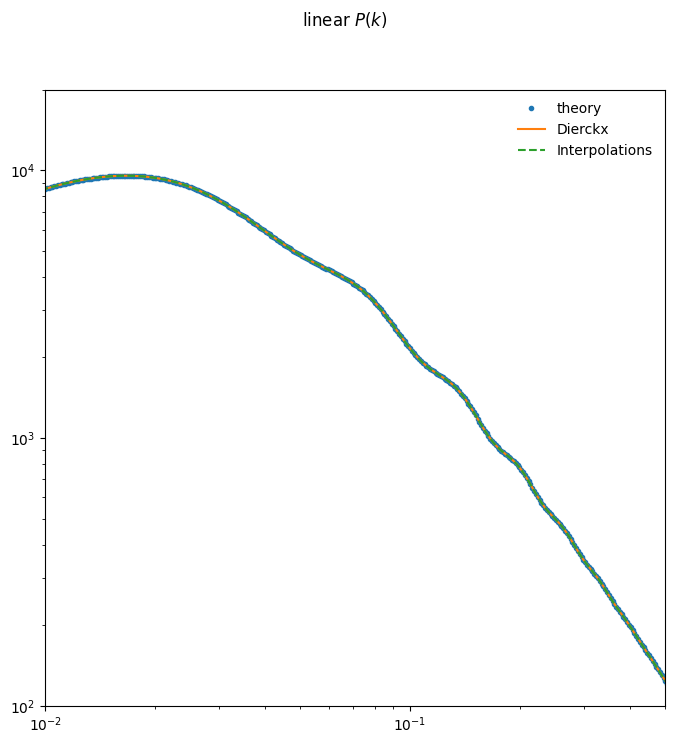

In [4]:
np = pyimport("numpy")
kk = np.logspace(log10(k[begin+1]), log10(k[end]), 10^4)

fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111)
ax.loglog(k, Pₗ, ".", label="theory")
ax.loglog(kk, Pₗ_interp1.(kk), label="Dierckx")
ax.loglog(kk, Pₗ_interp2.(kk), "--", label="Interpolations")
ax.set_xlim(0.01,0.5)
ax.set_ylim(100,2e4)
ax.legend(framealpha=0)

fig.suptitle("linear \$P(k)\$")

plt.show()

## 1.1 Initial Conditions

The test consists in iterpolating a precomputed linear $P(k)$ at fixed cosmology and then comparing it to the $P(k)$ of the IC field generated with it

sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


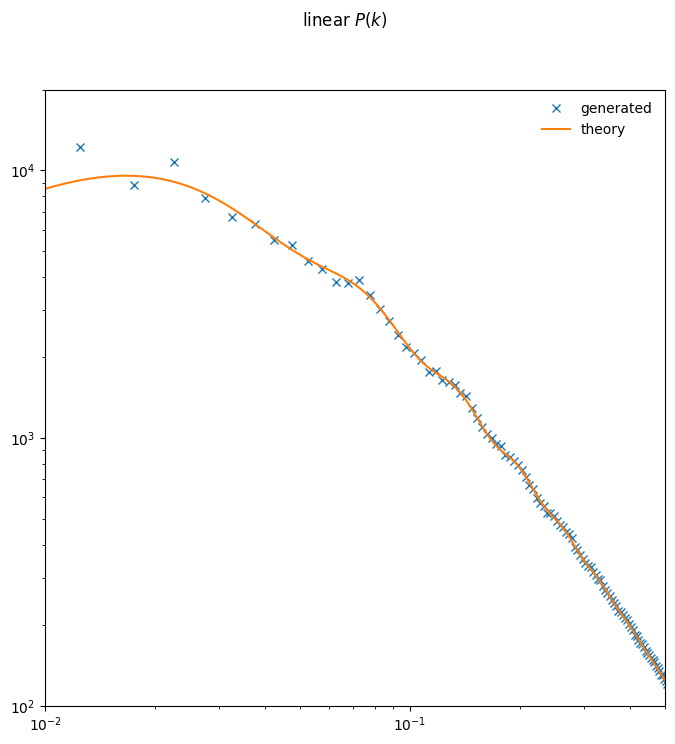

In [4]:
L, Ng, seed = 1000., 220, 123456
precision = Float32

k, Pₗ = load_Pₗ(precision, "pk_lin_z1.dat")
interp = interpolate(k, Pₗ, FritschCarlsonMonotonicInterpolation())
Pₗ_interp(k_new) = precision(interp(k_new)*(Ng/L)^3)

frequencies = gspt.FFTFrequenciesCore{precision}(L, Ng)
buffer = gspt.FFTBufferCore{precision}(Ng)

GRF = gspt.get_GRF(precision, L, Ng, seed)
δₖL = gspt.get_δₖL(GRF, Pₗ_interp, frequencies, buffer)

# ---

bins = [precision(i) for i in 0:1/200:1]
kf, Pf = Pₖ_of(
    δₖL.S,
    frequencies.k,
    bins,
    L,
    Ng
)

fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111)
ax.loglog(kf, Pf, "x", label="generated")
ax.loglog(k, Pₗ, label="theory")
ax.set_xlim(0.01,0.5)
ax.set_ylim(100,2e4)
ax.legend(framealpha=0)

fig.suptitle("linear \$P(k)\$")

plt.show()

### GPU

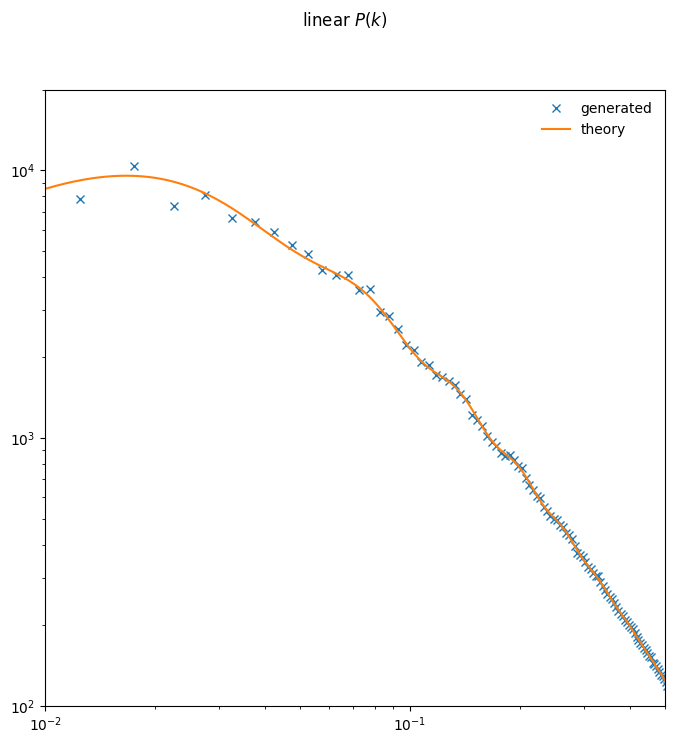

In [11]:
L, Ng, seed = 1000., 220, 123456
precision = Float32

k, Pₗ = load_Pₗ(precision, "pk_lin_z1.dat")
interp = interpolate(k, Pₗ, FritschCarlsonMonotonicInterpolation())
Pₗ_interp(k_new) = precision(interp(k_new)*(Ng/L)^3)

frequencies = gspt.FFTFrequenciesCore{precision}(L, Ng)

# ---

# save initial power spectrum file array for linear field computation on the GPU

np = pyimport("numpy")

# sqrtPL = sqrt.(Pₗ_interp.(frequencies.k))
# np.save("sqrtPL_ng$(Ng).npy", sqrtPL)

# to load it back
sqrtPL = ggspt.CuArray(np.load("sqrtPL_ng$(Ng).npy"))

# ---

frequencies = ggspt.FFTFrequenciesCUDA{precision}(L, Ng)
buffer = ggspt.FFTBufferCUDA{precision}(Ng)

GRF = ggspt.get_GRF(precision, L, Ng, seed)
δₖL = ggspt.do_fft(GRF)*sqrtPL

# ---

bins = [precision(i) for i in 0:1/200:1]
kf, Pf = ggspt.CUDA.@sync Pₖ_of(
    Array(δₖL.S),
    Array(frequencies.k),
    bins,
    L,
    Ng
)

fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111)
ax.loglog(kf, Pf, "x", label="generated")
ax.loglog(k, Pₗ, label="theory")
ax.set_xlim(0.01,0.5)
ax.set_ylim(100,2e4)
ax.legend(framealpha=0)

fig.suptitle("linear \$P(k)\$")

plt.show()

Note that the GPU code uses the CUDA.randn function, which is a different random number generator that the one used by the Random library. This means that the same seed will yield different cosmic variance.

## 1.2 Filters

### 1.2.1 Generic $k$-sharp filter

First, test that the filter doesn't change the already filtered field when applied to it.

In [22]:
L, Ng = 1000., 220
Λ = 1/3*π*Ng/L
precision = Float32

frequencies = gspt.FFTFrequenciesCore{precision}(L, Ng)
buffer = gspt.FFTBufferCore{precision}(Ng)

filtered_ic = load_real_field(precision, "gridspt_fields/delta_1st_delta.dat", Ng)
filtered_icₖ = FFTW.rfft(filtered_ic)

δL = gspt.ScalarFieldCore{precision}(L, Ng, filtered_ic, false)
δₖL = gspt.do_fft(δL, buffer)
δₖL = gspt.iso_sharp_filter(δₖL, Λ, frequencies)

print("Filtered fields are approximately the same? $(isapprox(filtered_icₖ, δₖL.S)) \n")

Filtered fields are approximately the same? true 


Finally test that applying the filter to the unfiltered field produces something approximately similar to the field already filtered by the C++ version.

In [23]:
# Unfiltered field C++ (GridSPT fourier transforms with forward normalization)
ic = load_complex_field(precision, "gridspt_fields/delta_L1000_ng220_fourier.bin", Ng)*Ng^3
δₖL = gspt.ScalarFieldCore{Complex{precision}}(L, Ng, ic, true)
δₖL = gspt.iso_sharp_filter(δₖL, Λ, frequencies)

print("Filtered fields are approximately the same? $(isapprox(filtered_icₖ, δₖL.S)) \n")

Filtered fields are approximately the same? true 


A few plots for the sake of visualization

Julia (left) and C++ (right)

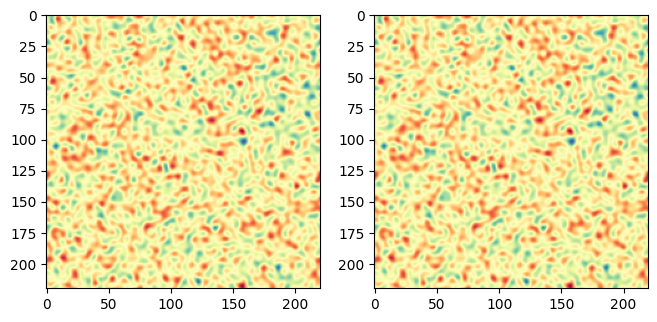

In [26]:
δL = gspt.do_ifft(δₖL, buffer)

fig = plt.figure(figsize=(12, 4))

vmin = min(minimum(δL.S[54, :, :]), minimum(filtered_ic[54, :, :]))
vmax = max(maximum(δL.S[54, :, :]), maximum(filtered_ic[54, :, :]))

ax = fig.add_subplot(131)
ax.imshow(δL.S[54, :, :], vmin=vmin, vmax=vmax, cmap="Spectral")

ax = fig.add_subplot(132)
ax.imshow(filtered_ic[54, :, :], vmin=vmin, vmax=vmax, cmap="Spectral")

plt.show()

print("Julia (left) and C++ (right)")

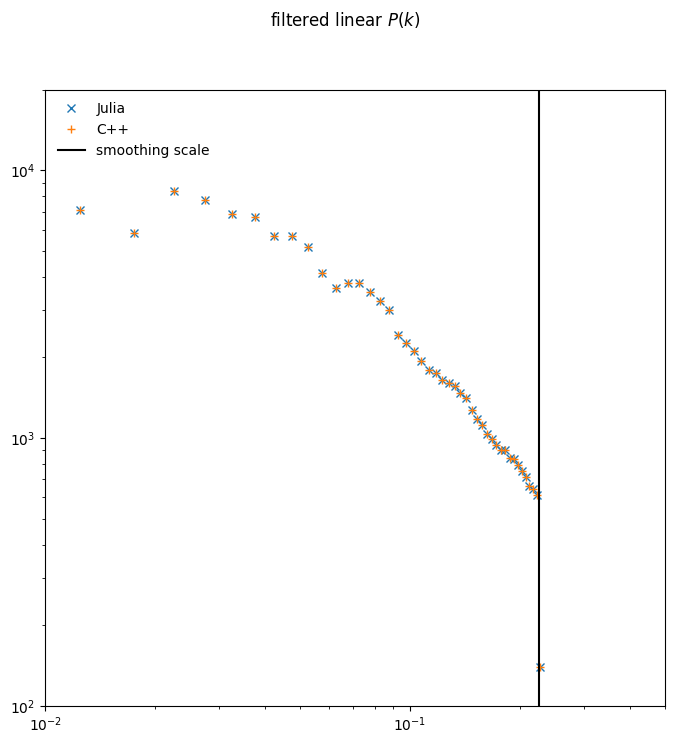

In [25]:
bins = [precision(i) for i in 0:1/200:1]
jl_k, jl_Pₖ = Pₖ_of(
    δL.S,
    frequencies.k,
    bins,
    L,
    Ng
)
cpp_k, cpp_Pₖ = Pₖ_of(
    filtered_ic,
    frequencies.k,
    bins,
    L,
    Ng
)

fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111)
ax.loglog(jl_k, jl_Pₖ, "x", label="Julia")
ax.loglog(cpp_k, cpp_Pₖ, "+", label="C++")
ax.axvline(Λ, color="k", label="smoothing scale")
ax.set_xlim(0.01,0.5)
ax.set_ylim(100,2e4)
ax.legend(framealpha=0)

fig.suptitle("filtered linear \$P(k)\$")

plt.show()

### GPU

In [33]:
L, Ng = 1000., 220
Λ = 1/3*π*Ng/L
precision = Float32

frequencies = ggspt.FFTFrequenciesCUDA{precision}(L, Ng)
buffer = ggspt.FFTBufferCUDA{precision}(Ng)

filtered_ic = load_real_field(precision, "gridspt_fields/delta_1st_delta.dat", Ng)
filtered_icₖ = FFTW.rfft(filtered_ic)

δL = ggspt.ScalarFieldCUDA{precision}(L, Ng, ggspt.CuArray(filtered_ic), false)
δₖL = ggspt.do_fft(δL, buffer)
δₖL = ggspt.iso_sharp_filter(δₖL, Λ, frequencies)

print("Filtered fields are approximately the same? $(isapprox(filtered_icₖ, Array(δₖL.S))) \n")

Filtered fields are approximately the same? true 


In [34]:
# Unfiltered field C++ (GridSPT fourier transforms with forward normalization)
ic = load_complex_field(precision, "gridspt_fields/delta_L1000_ng220_fourier.bin", Ng)*Ng^3
δₖL = ggspt.ScalarFieldCUDA{Complex{precision}}(L, Ng, ggspt.CuArray(ic), true)
δₖL = ggspt.iso_sharp_filter(δₖL, Λ, frequencies)

print("Filtered fields are approximately the same? $(isapprox(filtered_icₖ, Array(δₖL.S))) \n")

Filtered fields are approximately the same? true 


Julia (left) and C++ (right)

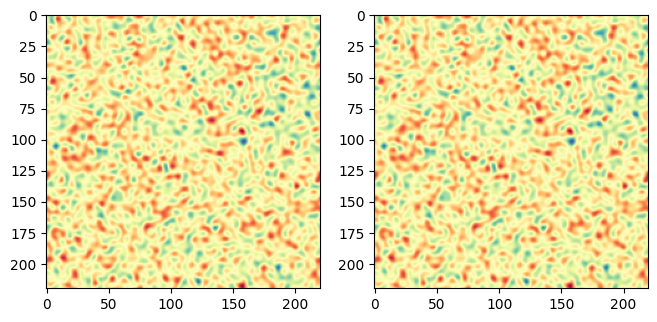

In [35]:
δL = ggspt.do_ifft(δₖL, buffer)
S = ggspt.CUDA.@sync Array(δL.S)

fig = plt.figure(figsize=(12, 4))

vmin = min(minimum(S[54, :, :]), minimum(filtered_ic[54, :, :]))
vmax = max(maximum(S[54, :, :]), maximum(filtered_ic[54, :, :]))

ax = fig.add_subplot(131)
ax.imshow(S[54, :, :], vmin=vmin, vmax=vmax, cmap="Spectral")

ax = fig.add_subplot(132)
ax.imshow(filtered_ic[54, :, :], vmin=vmin, vmax=vmax, cmap="Spectral")

plt.show()

print("Julia (left) and C++ (right)")

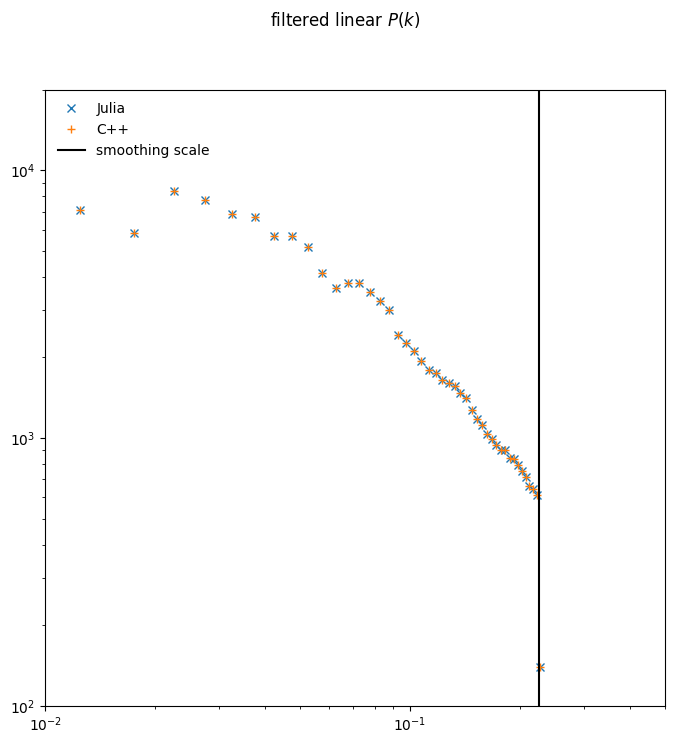

In [37]:
bins = [precision(i) for i in 0:1/200:1]
jl_k, jl_Pₖ = Pₖ_of(
    S,
    ggspt.CUDA.@sync(Array(frequencies.k)),
    bins,
    L,
    Ng
)
cpp_k, cpp_Pₖ = Pₖ_of(
    filtered_ic,
    ggspt.CUDA.@sync(Array(frequencies.k)),
    bins,
    L,
    Ng
)

fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111)
ax.loglog(jl_k, jl_Pₖ, "x", label="Julia")
ax.loglog(cpp_k, cpp_Pₖ, "+", label="C++")
ax.axvline(Λ, color="k", label="smoothing scale")
ax.set_xlim(0.01,0.5)
ax.set_ylim(100,2e4)
ax.legend(framealpha=0)

fig.suptitle("filtered linear \$P(k)\$")

plt.show()

# 2 Standard Perturbation Theory

This section compares fields at different orders in perturbation theory, starting from the same filtered initial field as C++ to isolate the behavior of the perturbation theory solver.

In [39]:
using GridSPTCore: GridSPTCore as gspt
using GridSPTGPU: GridSPTGPU as ggspt
using PyPlot
using PyCall
using Interpolations
using FFTW

In [79]:
# Functions to read C++ array files consistently in Julia

function load_real_field(::Type{T}, fn::String, Ng::Integer) where T<:Real
    field = reinterpret(T, read(fn))
    field3D = Array{T, 3}(undef, Ng, Ng, Ng)
    
    @inbounds for a in 1:Ng
        @inbounds for b in 1:Ng
            @inbounds for c in 1:Ng
                current = Int(((a-1)*Ng+(b-1))*(2*(÷(Ng, 2)+1))+c)
                field3D[a, b, c] = field[current]
            end
        end
    end

    return permutedims(field3D, [3, 2, 1])
end

function load_complex_field(::Type{T}, fn::String, Ng::Integer) where T<:Real
    field = reinterpret(T, read(fn))
    field3D = Array{Complex{T}, 3}(undef, Ng, Ng, ÷(Ng, 2)+1)
    
    @inbounds for a in 1:Ng
        @inbounds for b in 1:Ng
            @inbounds for c in 1:÷(Ng, 2)+1
                current_re = Int(((a-1)*Ng+(b-1))*(2*(÷(Ng, 2)+1))+2*(c-1)+1)
                current_im = Int(((a-1)*Ng+(b-1))*(2*(÷(Ng, 2)+1))+2*(c-1)+2)
                field3D[a, b, c] = complex(field[current_re], field[current_im])
            end
        end
    end

    return permutedims(field3D, [3, 2, 1])
end

function load_Pₗ(::Type{T}, fn::String) where T<:Real
    local x, y
    open(fn) do f
        lines = readlines(f)
        x = [parse(T, split(line, " ")[1]) for line in lines]
        y = [parse(T, split(line, " ")[2]) for line in lines]
    end

    pushfirst!(x, T(0))
    pushfirst!(y, T(0))
    return x, y
end

# Functions to compute the real-space power spectrum 
# and redshift space power spectrum (monopole, quadrupole and hexadecapole)

function Pₖ_of(field::Array{T, 3}, frequencies::Array{T, 3}, bins::Vector{T}, L::Real, Ng::Integer) where T<:Real
    ℱfield = FFTW.rfft(field)/Ng^3
    
    kₘ = (bins[begin:end-1]+bins[begin+1:end])/2
    Δk = bins[begin+1]-bins[begin]
    frequency_to_bin = Int.(div.(frequencies, Δk))
    Pₖ, nₖ = fill!(Vector{T}(undef, size(kₘ)...), T(0)), fill!(Vector{T}(undef, size(kₘ)...), T(0))
    for i in axes(kₘ, 1)
        bin_mask = frequency_to_bin.==i-1
        nₖ[i] = sum(bin_mask)
        if nₖ[i]>0
            Pₖ[i] = T(L)^3*sum(real(ℱfield[bin_mask]).^2+imag(ℱfield[bin_mask]).^2)/nₖ[i]
        end
    end

    return kₘ, Pₖ, nₖ
end

function multipole_Pₖ_of(field::Array{T, 3}, axis::Integer, 𝐤::Array{T, 4}, k::Array{T, 3}, bins::Vector{T}, L::Real, Ng::Integer) where T<:Real
    ℱfield = FFTW.rfft(field)/Ng^3
    
    kₘ = (bins[begin:end-1]+bins[begin+1:end])/2
    Δk = bins[begin+1]-bins[begin]
    frequency_to_bin = Int.(div.(k, Δk))
    P0ₖ = fill!(Vector{T}(undef, size(kₘ)...), T(0))
    P2ₖ = fill!(Vector{T}(undef, size(kₘ)...), T(0))
    P4ₖ = fill!(Vector{T}(undef, size(kₘ)...), T(0))
    nₖ = fill!(Vector{T}(undef, size(kₘ)...), T(0))
    for i in axes(kₘ, 1)
        bin_mask = frequency_to_bin.==i-1
        nₖ[i] = sum(bin_mask)
        if nₖ[i]>0
            μ² = @. (𝐤[bin_mask, axis]/k[bin_mask])^2
            δ² = @. real(ℱfield[bin_mask])^2+imag(ℱfield[bin_mask])^2
            
            P0ₖ[i] = T(L)^3*sum(δ²)/nₖ[i]
            P2ₖ[i] = 5*T(L)^3*sum(@. δ²*(3*μ²-1)/2)/nₖ[i]
            P4ₖ[i] = 9*T(L)^3*sum(@. δ²*(35*μ²^2-30*μ²+3)/8)/nₖ[i]
        end
    end

    return kₘ, P0ₖ, P2ₖ, P4ₖ, nₖ
end

multipole_Pₖ_of (generic function with 2 methods)

## 2.1 Real Space

In [67]:
n, L, Ng = 5, 1000., 220
precision = Float32

# load C++ fields
cpp_fields = [
    load_real_field(p, "gridspt_fields/delta_1st_delta.dat", Ng),
    load_real_field(p, "gridspt_fields/delta_2nd_delta.dat", Ng),
    load_real_field(p, "gridspt_fields/delta_3rd_delta.dat", Ng),
    load_real_field(p, "gridspt_fields/delta_4th_delta.dat", Ng),
    load_real_field(p, "gridspt_fields/delta_5th_delta.dat", Ng)
]

# compute with Julia for comparison with C++
frequencies = gspt.FFTFrequenciesCore{precision}(L, Ng)
buffer = gspt.FFTBufferCore{precision}(Ng)

δL = gspt.ScalarFieldCore{precision}(L, Ng, cpp_fields[1], false)
δ, _, _, _ = gspt.real_space_spt(n, δL, frequencies, buffer)

print("First order must be true: $(isapprox(cpp_fields[1], δ[1].S)) \n")
print("Second order: $(isapprox(cpp_fields[2], δ[2].S)) \n")
print("Third order: $(isapprox(cpp_fields[3], δ[3].S)) \n")
print("Fourth order: $(isapprox(cpp_fields[4], δ[4].S)) \n")
print("Fifth order: $(isapprox(cpp_fields[5], δ[5].S)) \n")

First order must be true: true 
Second order: true 
Third order: true 
Fourth order: true 
Fifth order: true 


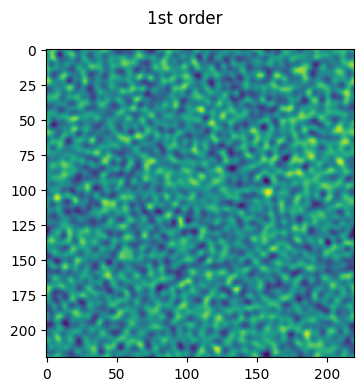

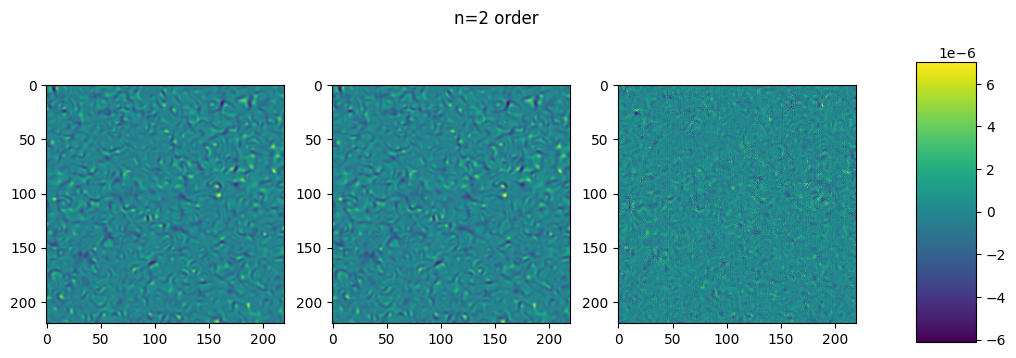

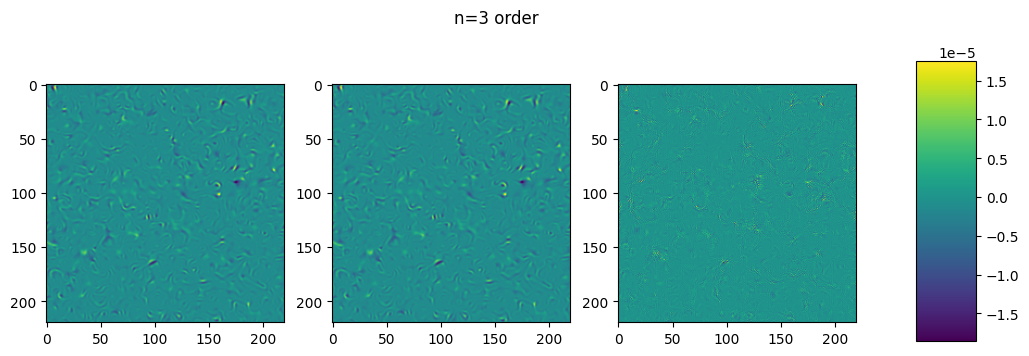

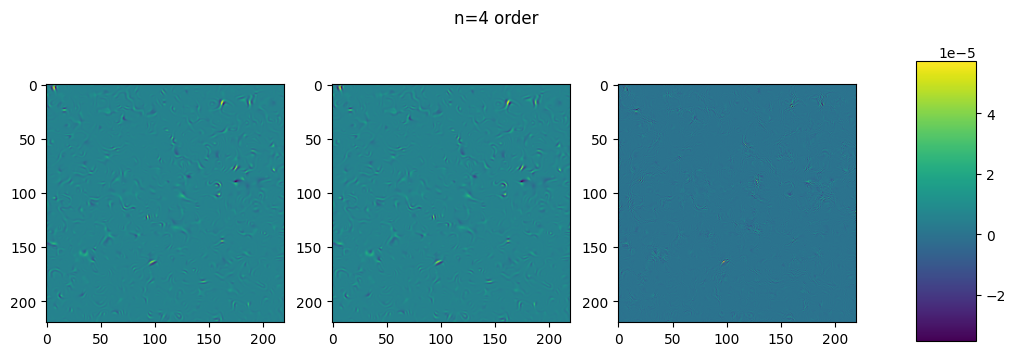

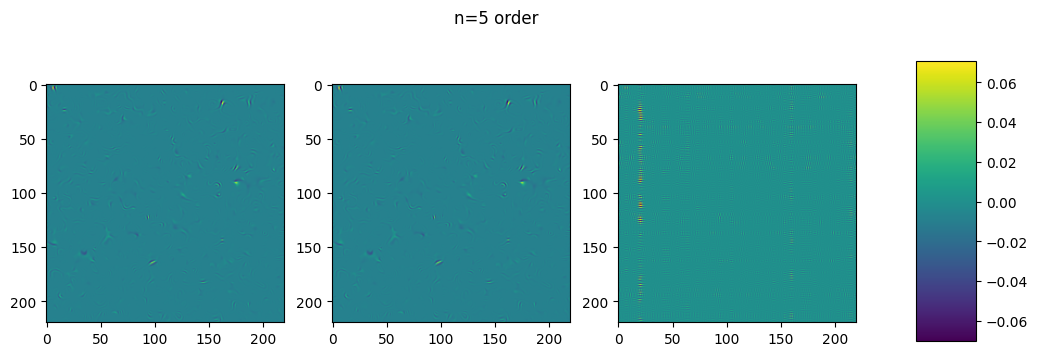

In [53]:
fig = plt.figure(figsize=(12, 4))

ax = fig.add_subplot(111)
ax.imshow(δ[1].S[54, :, :])

fig.suptitle("1st order")

###

for i in 2:5
    S = isa(δ[i].S, ggspt.CuArray) ? ggspt.CUDA.@sync(Array(δ[i].S)) : δ[i].S
    
    fig = plt.figure(figsize=(12, 4))
    
    vmin = min(minimum(S[54, :, :]), minimum(cpp_fields[i][54, :, :]))
    vmax = max(maximum(S[54, :, :]), maximum(cpp_fields[i][54, :, :]))
    
    ax = fig.add_subplot(131)
    ax.imshow(S[54, :, :], vmin=vmin, vmax=vmax)
    
    ax = fig.add_subplot(132)
    ax.imshow(cpp_fields[i][54, :, :], vmin=vmin, vmax=vmax)
    
    ax = fig.add_subplot(133)
    image = ax.imshow(S[54, :, :]-cpp_fields[i][54, :, :])
    
    fig.subplots_adjust(right=0.8)
    
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(image, cax=cbar_ax)
    
    fig.suptitle("n=$(i) order")
end

plt.show()

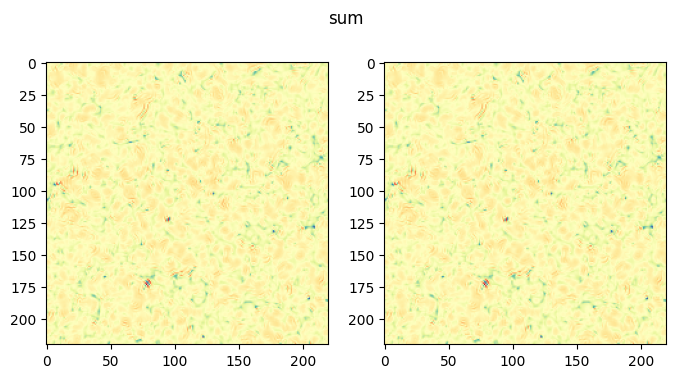

In [63]:
# plot the total of the perturbative series

fig = plt.figure(figsize=(8, 4))

δtot = dropdims(
    sum(
        (δ[1]+δ[2]+δ[3]+δ[4]+δ[5]).S[20:54, :, :],
        dims=1
    ),
    dims=1
)
cpp_tot = dropdims(
    sum(
        (cpp_fields[1]+cpp_fields[2]+cpp_fields[3]+cpp_fields[4]+cpp_fields[5])[20:54, :, :],
        dims=1
    ),
    dims=1
)    

vmin = min(minimum(δtot), minimum(cpp_tot))
vmax = max(maximum(δtot), maximum(cpp_tot))

ax = fig.add_subplot(121)
ax.imshow(δtot, vmin=vmin, vmax=vmax, cmap="Spectral")
# ax.imshow(δtot.S[54, :, :], vmin=vmin, vmax=vmax, cmap="Spectral")

ax = fig.add_subplot(122)
ax.imshow(cpp_tot, vmin=vmin, vmax=vmax, cmap="Spectral")
# ax.imshow(cpp_tot[54, :, :], vmin=vmin, vmax=vmax, cmap="Spectral")

fig.suptitle("sum")

plt.show()

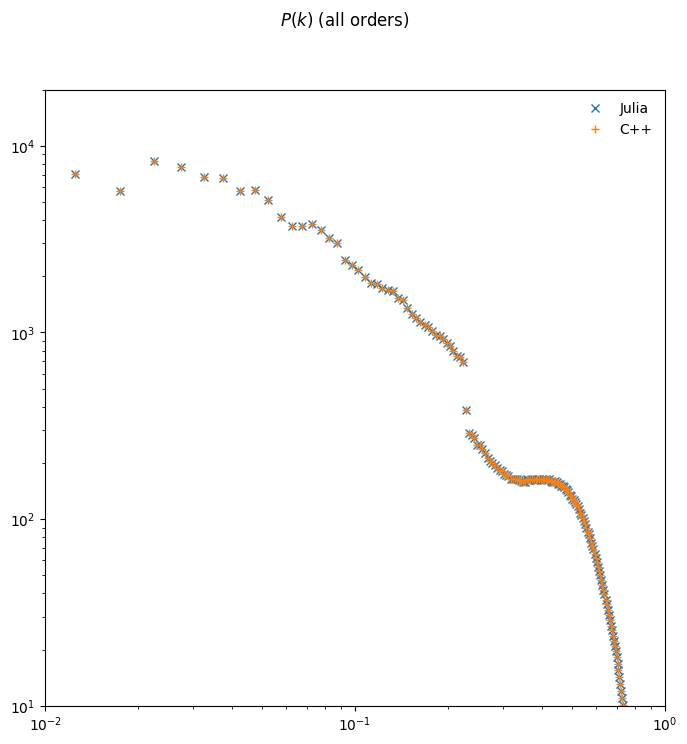

In [65]:
bins = [precision(i) for i in 0:1/200:1]
jl_k, jl_Pₖ = Pₖ_of(
    (δ[1]+δ[2]+δ[3]+δ[4]+δ[5]).S,
    frequencies.k,
    bins,
    L,
    Ng
)
cpp_k, cpp_Pₖ = Pₖ_of(
    cpp_fields[1]+cpp_fields[2]+cpp_fields[3]+cpp_fields[4]+cpp_fields[5],
    frequencies.k,
    bins,
    L,
    Ng
)

fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111)
ax.loglog(jl_k, jl_Pₖ, "x", label="Julia")
ax.loglog(cpp_k, cpp_Pₖ, "+", label="C++")
ax.set_xlim(0.01,1)
ax.set_ylim(10,2e4)
ax.legend(framealpha=0)

fig.suptitle("\$P(k)\$ (all orders)")

plt.show()

There are some small differences between C++ and Julia, likely due to different approximations in the way Floating point numbers are treated (this seems to be the case also due to the regular "grid"-like features appearing in the difference), however the results are comparable, no spurious feature is observed at the level of the power spectrum.

### GPU

In [68]:
n, L, Ng = 5, 1000., 220
precision = Float32

# load C++ fields
cpp_fields = [
    load_real_field(p, "gridspt_fields/delta_1st_delta.dat", Ng),
    load_real_field(p, "gridspt_fields/delta_2nd_delta.dat", Ng),
    load_real_field(p, "gridspt_fields/delta_3rd_delta.dat", Ng),
    load_real_field(p, "gridspt_fields/delta_4th_delta.dat", Ng),
    load_real_field(p, "gridspt_fields/delta_5th_delta.dat", Ng)
]

# compute with GPU
frequencies = ggspt.FFTFrequenciesCUDA{precision}(L, Ng)
buffer = ggspt.FFTBufferCUDA{precision}(Ng)

δL = ggspt.ScalarFieldCUDA{precision}(L, Ng, ggspt.CuArray(cpp_fields[1]), false)
δ, _, _, _ = ggspt.real_space_spt(n, δL, frequencies, buffer)

print("First order must be true: $(isapprox(cpp_fields[1], Array(δ[1].S))) \n")
print("Second order: $(isapprox(cpp_fields[2], Array(δ[2].S))) \n")
print("Third order: $(isapprox(cpp_fields[3], Array(δ[3].S))) \n")
print("Fourth order: $(isapprox(cpp_fields[4], Array(δ[4].S))) \n")
print("Fifth order: $(isapprox(cpp_fields[5], Array(δ[5].S))) \n")

First order must be true: true 
Second order: true 
Third order: true 
Fourth order: true 
Fifth order: true 


┌ Warning: Performing scalar indexing on task Task (runnable, started) @0x00007b54ba946d60.
│ Invocation of getindex resulted in scalar indexing of a GPU array.
│ This is typically caused by calling an iterating implementation of a method.
│ Such implementations *do not* execute on the GPU, but very slowly on the CPU,
│ and therefore should be avoided.
│ 
│ If you want to allow scalar iteration, use `allowscalar` or `@allowscalar`
│ to enable scalar iteration globally or for the operations in question.
└ @ GPUArraysCore ~/.julia/packages/GPUArraysCore/aNaXo/src/GPUArraysCore.jl:145


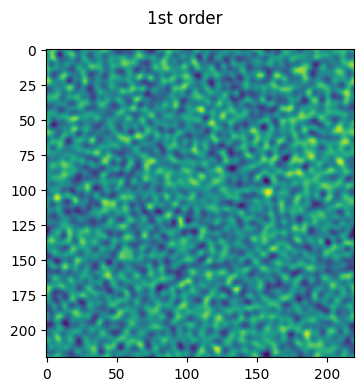

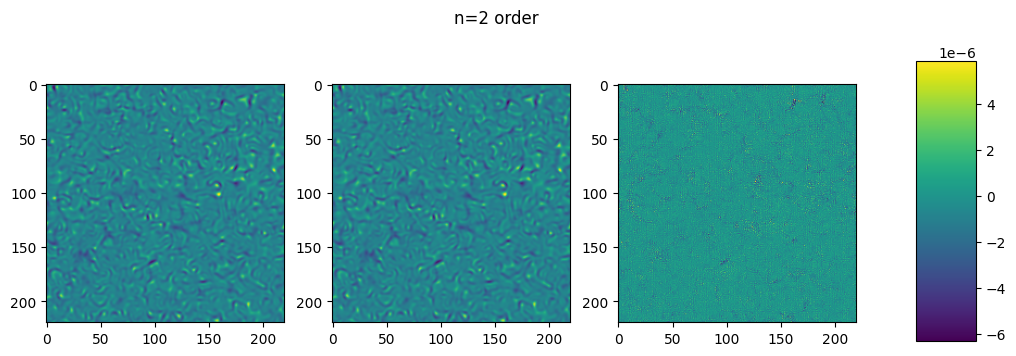

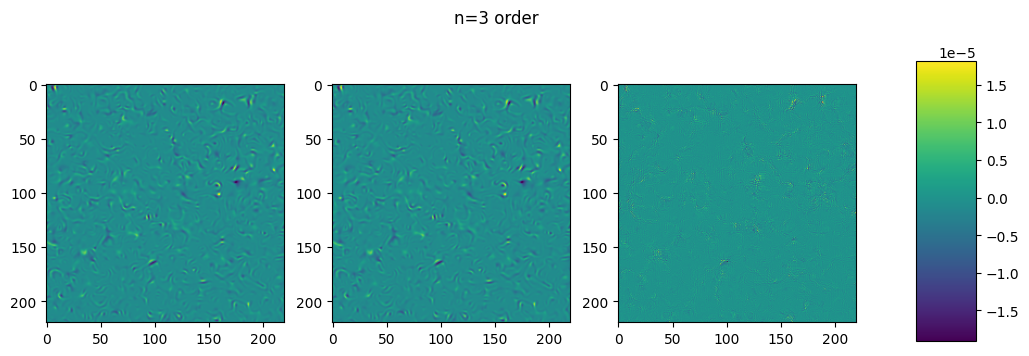

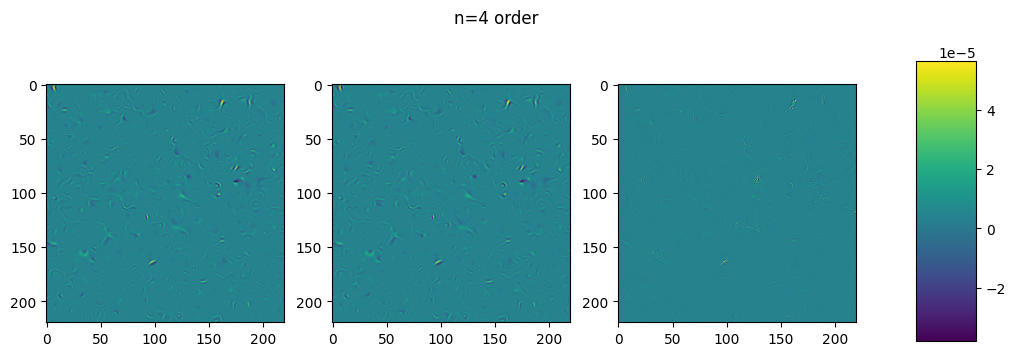

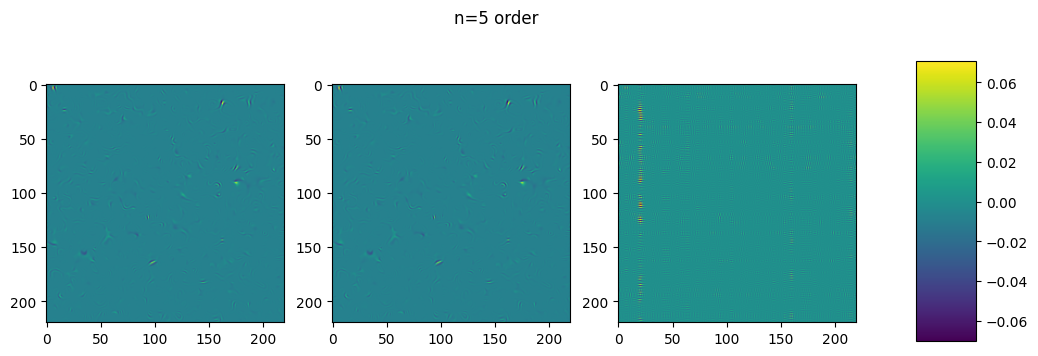

In [69]:
fig = plt.figure(figsize=(12, 4))

ax = fig.add_subplot(111)
ax.imshow(δ[1].S[54, :, :])

fig.suptitle("1st order")

###

for i in 2:5
    S = isa(δ[i].S, ggspt.CuArray) ? ggspt.CUDA.@sync(Array(δ[i].S)) : δ[i].S
    
    fig = plt.figure(figsize=(12, 4))
    
    vmin = min(minimum(S[54, :, :]), minimum(cpp_fields[i][54, :, :]))
    vmax = max(maximum(S[54, :, :]), maximum(cpp_fields[i][54, :, :]))
    
    ax = fig.add_subplot(131)
    ax.imshow(S[54, :, :], vmin=vmin, vmax=vmax)
    
    ax = fig.add_subplot(132)
    ax.imshow(cpp_fields[i][54, :, :], vmin=vmin, vmax=vmax)
    
    ax = fig.add_subplot(133)
    image = ax.imshow(S[54, :, :]-cpp_fields[i][54, :, :])
    
    fig.subplots_adjust(right=0.8)
    
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(image, cax=cbar_ax)
    
    fig.suptitle("n=$(i) order")
end

plt.show()

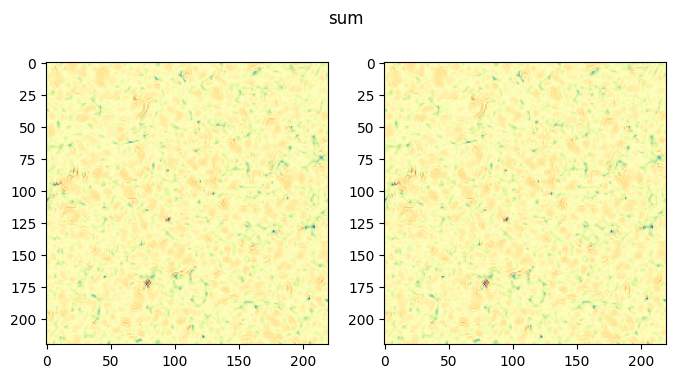

In [70]:
# plot the total of the perturbative series

fig = plt.figure(figsize=(8, 4))

δtot = dropdims(
    sum(
        ggspt.CUDA.@sync(Array((δ[1]+δ[2]+δ[3]+δ[4]+δ[5]).S))[20:54, :, :],
        dims=1
    ),
    dims=1
)
cpp_tot = dropdims(
    sum(
        (cpp_fields[1]+cpp_fields[2]+cpp_fields[3]+cpp_fields[4]+cpp_fields[5])[20:54, :, :],
        dims=1
    ),
    dims=1
)    

vmin = min(minimum(δtot), minimum(cpp_tot))
vmax = max(maximum(δtot), maximum(cpp_tot))

ax = fig.add_subplot(121)
ax.imshow(δtot, vmin=vmin, vmax=vmax, cmap="Spectral")
# ax.imshow(δtot.S[54, :, :], vmin=vmin, vmax=vmax, cmap="Spectral")

ax = fig.add_subplot(122)
ax.imshow(cpp_tot, vmin=vmin, vmax=vmax, cmap="Spectral")
# ax.imshow(cpp_tot[54, :, :], vmin=vmin, vmax=vmax, cmap="Spectral")

fig.suptitle("sum")

plt.show()

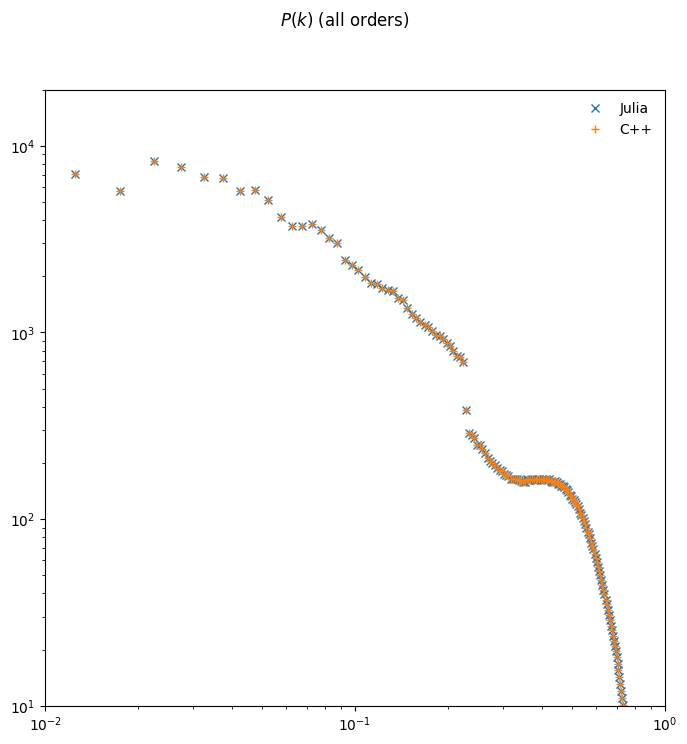

In [71]:
bins = [precision(i) for i in 0:1/200:1]
jl_k, jl_Pₖ = Pₖ_of(
    ggspt.CUDA.@sync(Array((δ[1]+δ[2]+δ[3]+δ[4]+δ[5]).S)),
    ggspt.CUDA.@sync(Array(frequencies.k)),
    bins,
    L,
    Ng
)
cpp_k, cpp_Pₖ = Pₖ_of(
    cpp_fields[1]+cpp_fields[2]+cpp_fields[3]+cpp_fields[4]+cpp_fields[5],
    ggspt.CUDA.@sync(Array(frequencies.k)),
    bins,
    L,
    Ng
)

fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111)
ax.loglog(jl_k, jl_Pₖ, "x", label="Julia")
ax.loglog(cpp_k, cpp_Pₖ, "+", label="C++")
ax.set_xlim(0.01,1)
ax.set_ylim(10,2e4)
ax.legend(framealpha=0)

fig.suptitle("\$P(k)\$ (all orders)")

plt.show()

## 2.2 Redshift Space

In [73]:
n, L, Ng = 5, 1000., 220
LOS, f = 1, 0.8 # LOS is 1 in Julia because of column-major ordering (in C++ the ordering is row-major)
precision = Float32

# load actual physical fields
δL = load_real_field(precision, "gridspt_fields/delta_1st_delta.dat", Ng)
cpp_fields = [
    load_real_field(precision, "gridspt_fields/delta_1st_delta_z.dat", Ng),
    load_real_field(precision, "gridspt_fields/delta_2nd_delta_z.dat", Ng),
    load_real_field(precision, "gridspt_fields/delta_3rd_delta_z.dat", Ng),
    load_real_field(precision, "gridspt_fields/delta_4th_delta_z.dat", Ng),
    load_real_field(precision, "gridspt_fields/delta_5th_delta_z.dat", Ng)
]

# compute with Julia for comparison with C++
frequencies = gspt.FFTFrequenciesCore{precision}(L, Ng)
buffer = gspt.FFTBufferCore{precision}(Ng)

δL = gspt.ScalarFieldCore{precision}(L, Ng, δL, false)
δ, θ, _, 𝐮 = gspt.real_space_spt(n, δL, frequencies, buffer)
δS = gspt.redshift_space_spt(LOS, f, δ, θ, 𝐮, frequencies, buffer)

print("First order: $(isapprox(cpp_fields[1], δS[1].S)) \n")
print("Second order: $(isapprox(cpp_fields[2], δS[2].S)) \n")
print("Third order: $(isapprox(cpp_fields[3], δS[3].S)) \n")
print("Fourth order: $(isapprox(cpp_fields[4], δS[4].S)) \n")
print("Fifth order: $(isapprox(cpp_fields[5], δS[5].S))\n")

First order: true 
Second order: true 
Third order: true 
Fourth order: true 
Fifth order: true


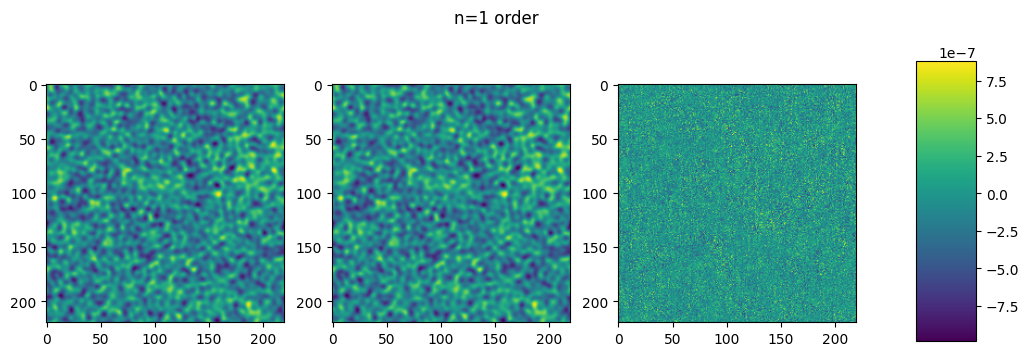

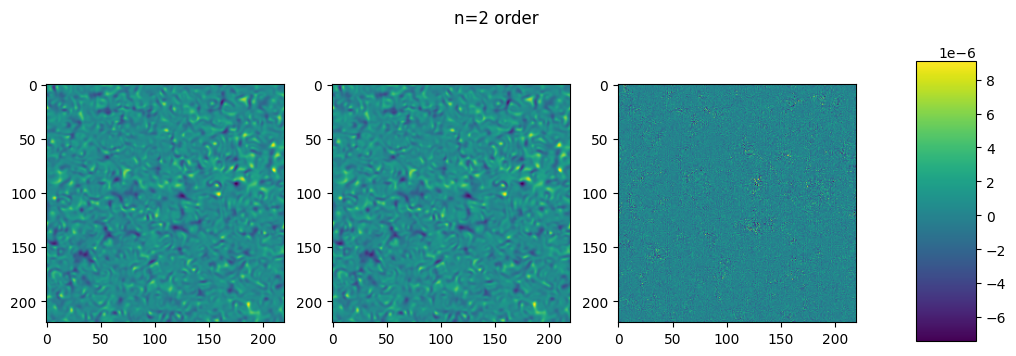

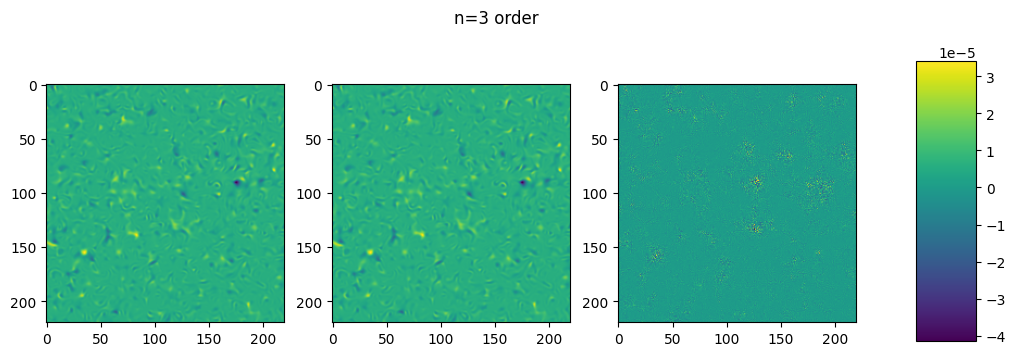

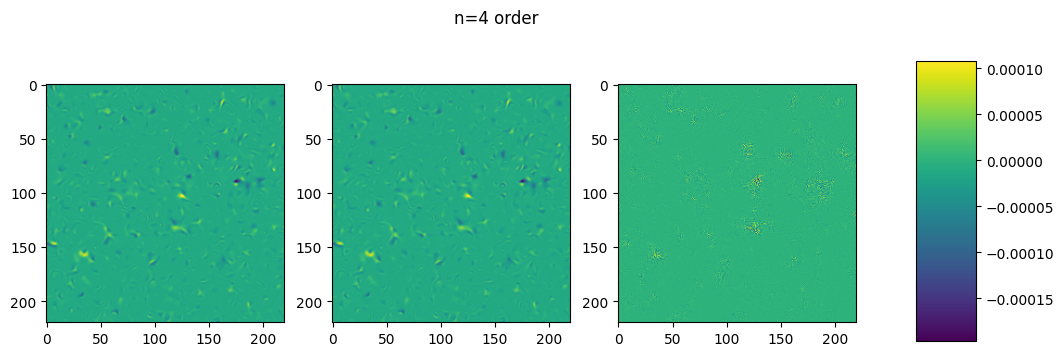

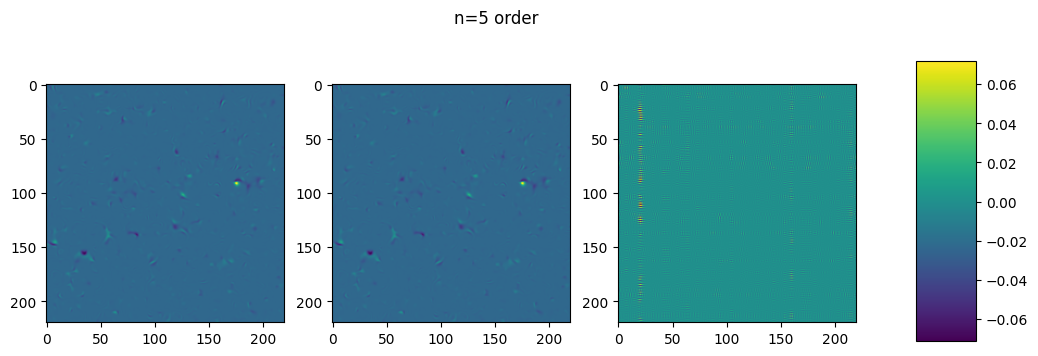

In [75]:
for i in 1:5
    S = isa(δS[i].S, ggspt.CuArray) ? ggspt.CUDA.@sync(Array(δS[i].S)) : δS[i].S
    
    fig = plt.figure(figsize=(12, 4))
    
    vmin = min(minimum(S[54, :, :]), minimum(cpp_fields[i][54, :, :]))
    vmax = max(maximum(S[54, :, :]), maximum(cpp_fields[i][54, :, :]))
    
    ax = fig.add_subplot(131)
    ax.imshow(S[54, :, :], vmin=vmin, vmax=vmax)
    
    ax = fig.add_subplot(132)
    ax.imshow(cpp_fields[i][54, :, :], vmin=vmin, vmax=vmax)
    
    ax = fig.add_subplot(133)
    image = ax.imshow(S[54, :, :]-cpp_fields[i][54, :, :])
    
    fig.subplots_adjust(right=0.8)
    
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(image, cax=cbar_ax)
    
    fig.suptitle("n=$(i) order")
end

plt.show()

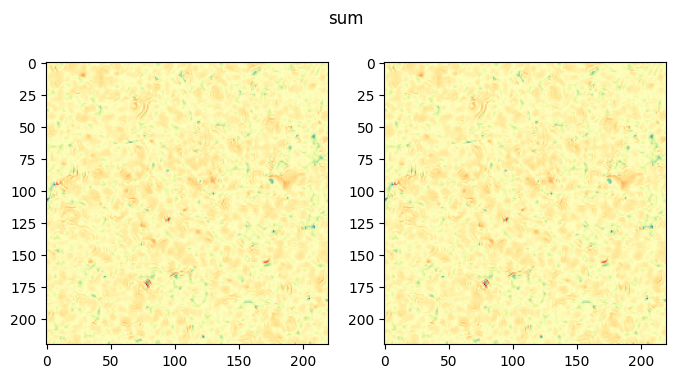

In [76]:
# plot the total of the perturbative series

fig = plt.figure(figsize=(8, 4))

δtot = dropdims(
    sum(
        (δS[1]+δS[2]+δS[3]+δS[4]+δS[5]).S[20:54, :, :],
        dims=1
    ),
    dims=1
)
cpp_tot = dropdims(
    sum(
        (cpp_fields[1]+cpp_fields[2]+cpp_fields[3]+cpp_fields[4]+cpp_fields[5])[20:54, :, :],
        dims=1
    ),
    dims=1
)    

vmin = min(minimum(δtot), minimum(cpp_tot))
vmax = max(maximum(δtot), maximum(cpp_tot))

ax = fig.add_subplot(121)
ax.imshow(δtot, vmin=vmin, vmax=vmax, cmap="Spectral")
# ax.imshow(δtot.S[54, :, :], vmin=vmin, vmax=vmax, cmap="Spectral")

ax = fig.add_subplot(122)
ax.imshow(cpp_tot, vmin=vmin, vmax=vmax, cmap="Spectral")
# ax.imshow(cpp_tot[54, :, :], vmin=vmin, vmax=vmax, cmap="Spectral")

fig.suptitle("sum")

plt.show()

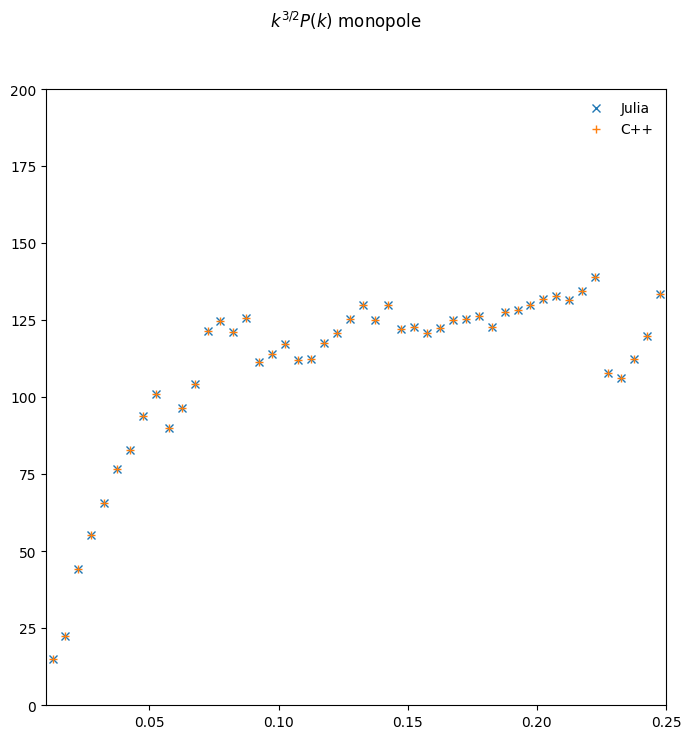

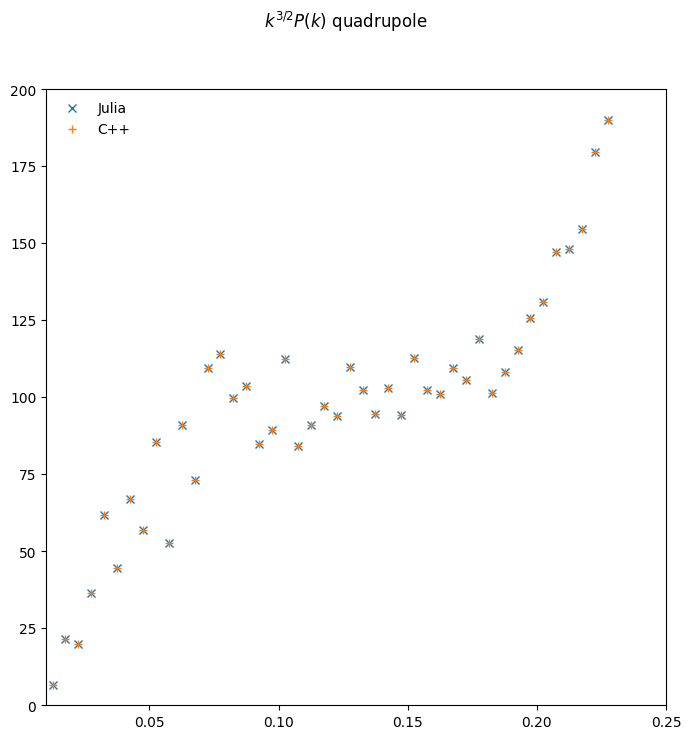

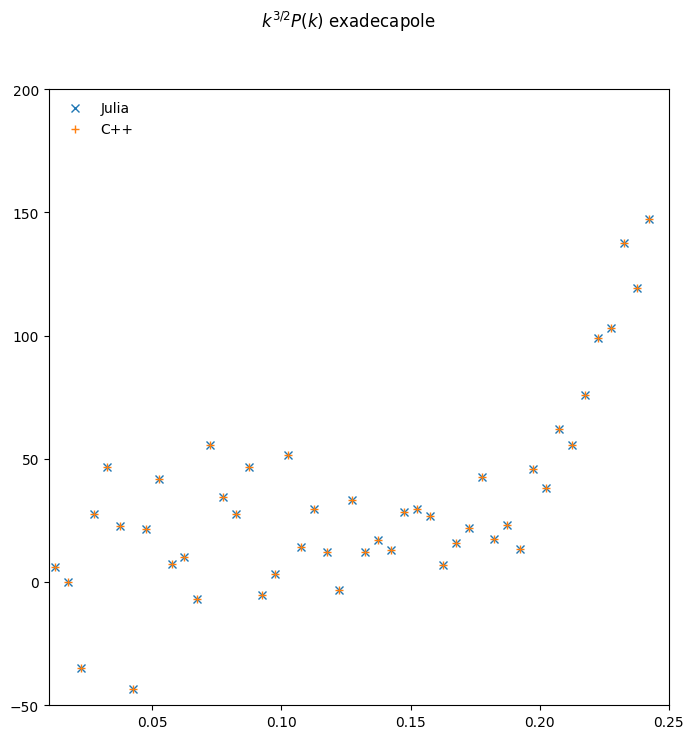

In [80]:
δStot = δS[1]+δS[2]+δS[3]+δS[4]+δS[5]
cpp_tot = cpp_fields[1]+cpp_fields[2]+cpp_fields[3]+cpp_fields[4]+cpp_fields[5]

bins = [precision(i) for i in 0:1/200:1]
jl_k, jl_P0ₖ, jl_P2ₖ, jl_P4ₖ = multipole_Pₖ_of(
    δStot.S,
    LOS,
    frequencies.𝐤,
    frequencies.k,
    bins,
    L,
    Ng
)
cpp_k, cpp_P0ₖ, cpp_P2ₖ, cpp_P4ₖ = multipole_Pₖ_of(
    cpp_tot,
    LOS,
    frequencies.𝐤,
    frequencies.k,
    bins,
    L,
    Ng
)

fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111)
ax.plot(jl_k, jl_k.^(3/2).*jl_P0ₖ, "x", label="Julia")
ax.plot(cpp_k, cpp_k.^(3/2).*cpp_P0ₖ, "+", label="C++")
# ax.axvline(Λ, color="k", label="smoothing scale")
ax.set_xlim(0.01,0.25)
ax.set_ylim(0,200)
ax.legend(framealpha=0)

fig.suptitle("\$k^{3/2}P(k)\$ monopole")

plt.show()

fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111)
ax.plot(jl_k, jl_k.^(3/2).*jl_P2ₖ, "x", label="Julia")
ax.plot(cpp_k, cpp_k.^(3/2).*cpp_P2ₖ, "+", label="C++")
# ax.axvline(Λ, color="k", label="smoothing scale")
ax.set_xlim(0.01,0.25)
ax.set_ylim(0,200)
ax.legend(framealpha=0)

fig.suptitle("\$k^{3/2}P(k)\$ quadrupole")

plt.show()

fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111)
ax.plot(jl_k, jl_k.^(3/2).*jl_P4ₖ, "x", label="Julia")
ax.plot(cpp_k, cpp_k.^(3/2).*cpp_P4ₖ, "+", label="C++")
# ax.axvline(Λ, color="k", label="smoothing scale")
ax.set_xlim(0.01,0.25)
ax.set_ylim(-50,200)
ax.legend(framealpha=0)

fig.suptitle("\$k^{3/2}P(k)\$ exadecapole")

plt.show()

### GPU

In [81]:
n, L, Ng = 5, 1000., 220
LOS, f = 1, 0.8 # LOS is 1 in Julia because of column-major ordering (in C++ the ordering is row-major)
precision = Float32

# load actual physical fields
δL = load_real_field(precision, "gridspt_fields/delta_1st_delta.dat", Ng)
cpp_fields = [
    load_real_field(precision, "gridspt_fields/delta_1st_delta_z.dat", Ng),
    load_real_field(precision, "gridspt_fields/delta_2nd_delta_z.dat", Ng),
    load_real_field(precision, "gridspt_fields/delta_3rd_delta_z.dat", Ng),
    load_real_field(precision, "gridspt_fields/delta_4th_delta_z.dat", Ng),
    load_real_field(precision, "gridspt_fields/delta_5th_delta_z.dat", Ng)
]

# compute with GPU
frequencies = ggspt.FFTFrequenciesCUDA{precision}(L, Ng)
buffer = ggspt.FFTBufferCUDA{precision}(Ng)

δL = ggspt.ScalarFieldCUDA{precision}(L, Ng, ggspt.CuArray(δL), false)
δ, θ, _, 𝐮 = ggspt.real_space_spt(n, δL, frequencies, buffer)
δS = ggspt.redshift_space_spt(LOS, f, δ, θ, 𝐮, frequencies, buffer)

print("First order: $(isapprox(cpp_fields[1], Array(δS[1].S))) \n")
print("Second order: $(isapprox(cpp_fields[2], Array(δS[2].S))) \n")
print("Third order: $(isapprox(cpp_fields[3], Array(δS[3].S))) \n")
print("Fourth order: $(isapprox(cpp_fields[4], Array(δS[4].S))) \n")
print("Fifth order: $(isapprox(cpp_fields[5], Array(δS[5].S)))\n")

First order: true 
Second order: true 
Third order: true 
Fourth order: true 
Fifth order: true


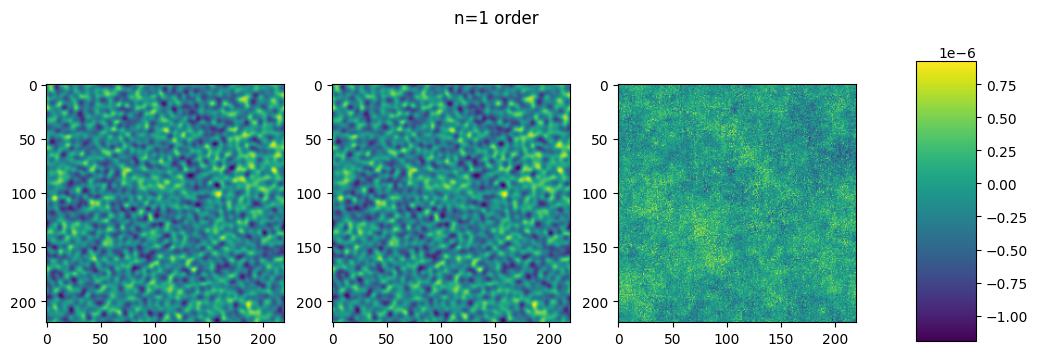

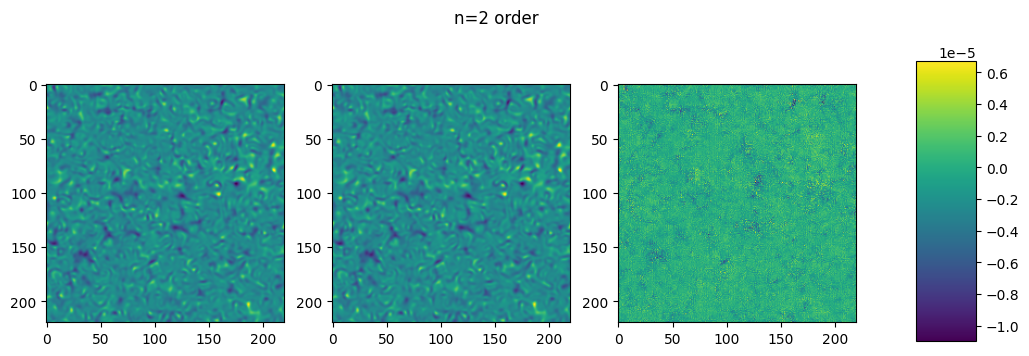

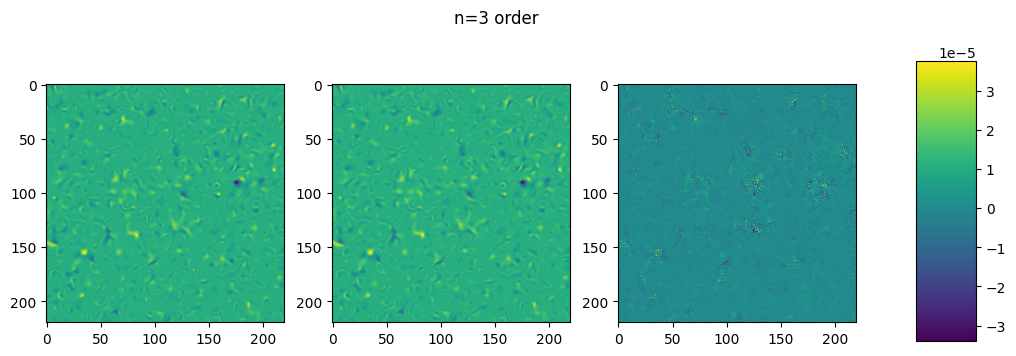

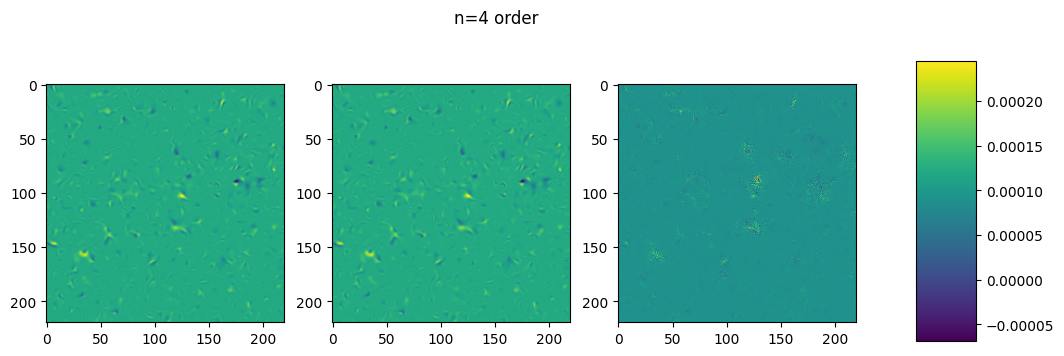

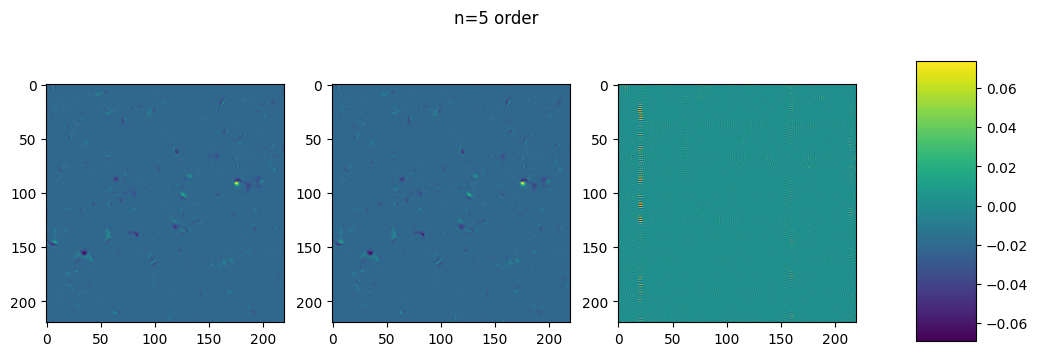

In [82]:
for i in 1:5
    S = isa(δS[i].S, ggspt.CuArray) ? ggspt.CUDA.@sync(Array(δS[i].S)) : δS[i].S
    
    fig = plt.figure(figsize=(12, 4))
    
    vmin = min(minimum(S[54, :, :]), minimum(cpp_fields[i][54, :, :]))
    vmax = max(maximum(S[54, :, :]), maximum(cpp_fields[i][54, :, :]))
    
    ax = fig.add_subplot(131)
    ax.imshow(S[54, :, :], vmin=vmin, vmax=vmax)
    
    ax = fig.add_subplot(132)
    ax.imshow(cpp_fields[i][54, :, :], vmin=vmin, vmax=vmax)
    
    ax = fig.add_subplot(133)
    image = ax.imshow(S[54, :, :]-cpp_fields[i][54, :, :])
    
    fig.subplots_adjust(right=0.8)
    
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(image, cax=cbar_ax)
    
    fig.suptitle("n=$(i) order")
end

plt.show()

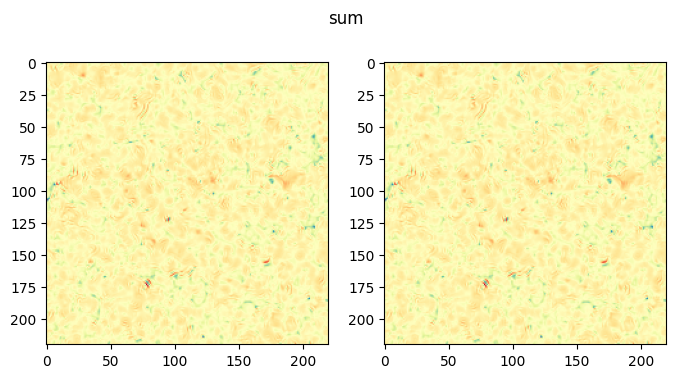

In [83]:
# plot the total of the perturbative series

fig = plt.figure(figsize=(8, 4))

δtot = dropdims(
    sum(
        ggspt.CUDA.@sync(Array((δS[1]+δS[2]+δS[3]+δS[4]+δS[5]).S))[20:54, :, :],
        dims=1
    ),
    dims=1
)
cpp_tot = dropdims(
    sum(
        (cpp_fields[1]+cpp_fields[2]+cpp_fields[3]+cpp_fields[4]+cpp_fields[5])[20:54, :, :],
        dims=1
    ),
    dims=1
)    

vmin = min(minimum(δtot), minimum(cpp_tot))
vmax = max(maximum(δtot), maximum(cpp_tot))

ax = fig.add_subplot(121)
ax.imshow(δtot, vmin=vmin, vmax=vmax, cmap="Spectral")
# ax.imshow(δtot.S[54, :, :], vmin=vmin, vmax=vmax, cmap="Spectral")

ax = fig.add_subplot(122)
ax.imshow(cpp_tot, vmin=vmin, vmax=vmax, cmap="Spectral")
# ax.imshow(cpp_tot[54, :, :], vmin=vmin, vmax=vmax, cmap="Spectral")

fig.suptitle("sum")

plt.show()

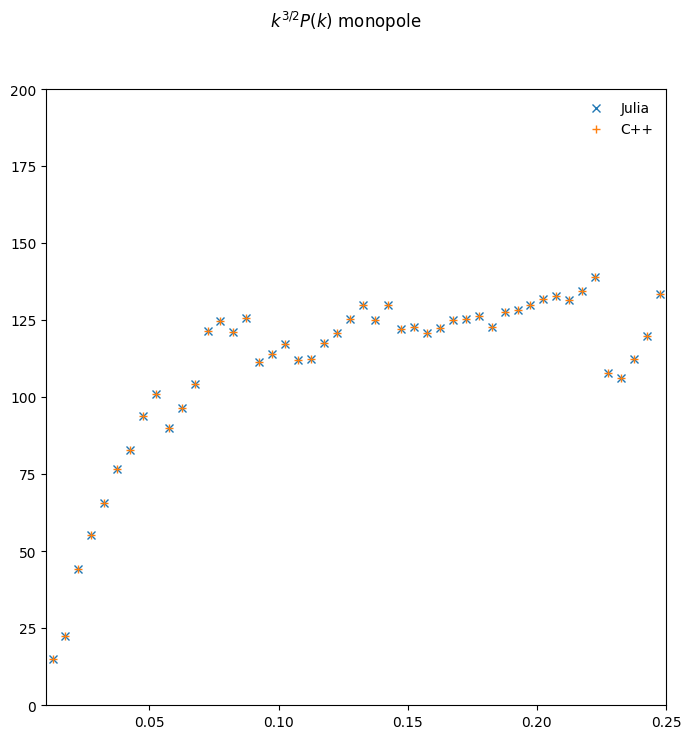

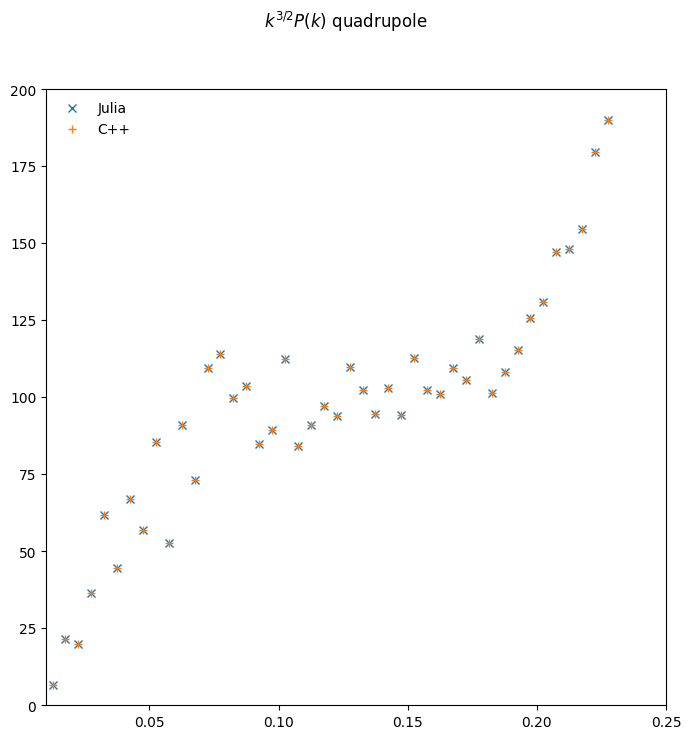

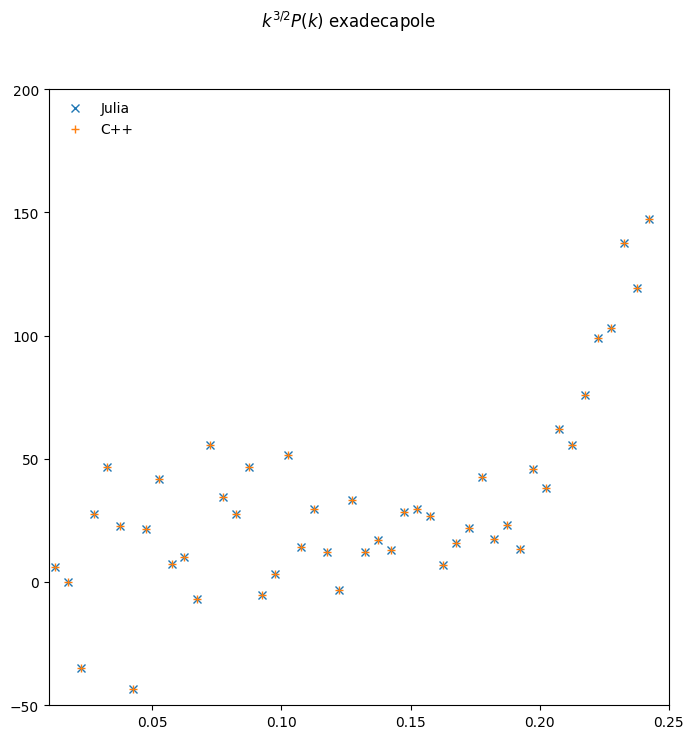

In [85]:
δStot = ggspt.CUDA.@sync Array((δS[1]+δS[2]+δS[3]+δS[4]+δS[5]).S)
cpp_tot = cpp_fields[1]+cpp_fields[2]+cpp_fields[3]+cpp_fields[4]+cpp_fields[5]

bins = [precision(i) for i in 0:1/200:1]
jl_k, jl_P0ₖ, jl_P2ₖ, jl_P4ₖ = multipole_Pₖ_of(
    δStot,
    LOS,
    ggspt.CUDA.@sync(Array(frequencies.𝐤)),
    ggspt.CUDA.@sync(Array(frequencies.k)),
    bins,
    L,
    Ng
)
cpp_k, cpp_P0ₖ, cpp_P2ₖ, cpp_P4ₖ = multipole_Pₖ_of(
    cpp_tot,
    LOS,
    ggspt.CUDA.@sync(Array(frequencies.𝐤)),
    ggspt.CUDA.@sync(Array(frequencies.k)),
    bins,
    L,
    Ng
)

fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111)
ax.plot(jl_k, jl_k.^(3/2).*jl_P0ₖ, "x", label="Julia")
ax.plot(cpp_k, cpp_k.^(3/2).*cpp_P0ₖ, "+", label="C++")
# ax.axvline(Λ, color="k", label="smoothing scale")
ax.set_xlim(0.01,0.25)
ax.set_ylim(0,200)
ax.legend(framealpha=0)

fig.suptitle("\$k^{3/2}P(k)\$ monopole")

plt.show()

fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111)
ax.plot(jl_k, jl_k.^(3/2).*jl_P2ₖ, "x", label="Julia")
ax.plot(cpp_k, cpp_k.^(3/2).*cpp_P2ₖ, "+", label="C++")
# ax.axvline(Λ, color="k", label="smoothing scale")
ax.set_xlim(0.01,0.25)
ax.set_ylim(0,200)
ax.legend(framealpha=0)

fig.suptitle("\$k^{3/2}P(k)\$ quadrupole")

plt.show()

fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111)
ax.plot(jl_k, jl_k.^(3/2).*jl_P4ₖ, "x", label="Julia")
ax.plot(cpp_k, cpp_k.^(3/2).*cpp_P4ₖ, "+", label="C++")
# ax.axvline(Λ, color="k", label="smoothing scale")
ax.set_xlim(0.01,0.25)
ax.set_ylim(-50,200)
ax.legend(framealpha=0)

fig.suptitle("\$k^{3/2}P(k)\$ exadecapole")

plt.show()

# 3 Benchmark

This section benchmarks the complete pipeline and times each step.

GridSPT.jl is about 2x faster in both single and multithread on my machine (CPU) and x20 faster on GPU.

In [2]:
using GridSPTCore: GridSPTCore as gspt
using Interpolations
using BenchmarkTools

BenchmarkTools.DEFAULT_PARAMETERS.seconds = 60

60

In [3]:
# function to read text files column-wise

function load_Pₗ(::Type{T}, fn::String) where T<:Real
    local x, y
    open(fn) do f
        lines = readlines(f)
        x = [parse(T, split(line, " ")[1]) for line in lines]
        y = [parse(T, split(line, " ")[2]) for line in lines]
    end

    pushfirst!(x, T(0))
    pushfirst!(y, T(0))
    return x, y
end

load_Pₗ (generic function with 1 method)

In [30]:
# whole pipeline
print("Whole pipeline benchmark with $(Threads.nthreads()) threads\n")

# specifications (include cosmology when linear P(k) emulator is implemented)
n, L, Ng, seed = 5, 1000., 220, 1234567890
Λ = 2/(n+1)*π*Ng/L # cutoff frequency given by Orsatz rule
precision = Float32
frequencies = gspt.FFTFrequenciesCore{precision}(L, Ng)
buffer = gspt.FFTBufferCore{precision}(Ng)

# Power spectrum for initial field (substitute with call to emulator)
k, Pₗ = load_Pₗ(precision, "pk_lin_z1.dat")
interp = interpolate(k, Pₗ, FritschCarlsonMonotonicInterpolation())
Pₗ_interp(k_new) = precision(interp(k_new)*(Ng/L)^3)

@benchmark begin
    # generate IC
    GRF = gspt.get_GRF($precision, $L, $Ng, $seed)
    δₖL = gspt.get_δₖL(GRF, $Pₗ_interp, $frequencies, $buffer)

    # filter
    δₖL = gspt.iso_sharp_filter(δₖL, $Λ, $frequencies)

    # solve PT
    δ, _, _, _ = gspt.real_space_spt($n, δₖL, $frequencies, $buffer)
end

Whole pipeline benchmark with 1 threads


BenchmarkTools.Trial: 5 samples with 1 evaluation per sample.
 Range (min … max):  12.254 s …   12.844 s  ┊ GC (min … max): 14.03% … 15.41%
 Time  (median):     12.522 s               ┊ GC (median):    15.81%
 Time  (mean ± σ):   12.523 s ± 223.795 ms  ┊ GC (mean ± σ):  15.81% ±  1.61%

  █            █            █        █                      █  
  █▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  12.3 s          Histogram: frequency by time         12.8 s <

 Memory estimate: 18.75 GiB, allocs estimate: 37608397.

In [15]:
# whole pipeline (RSD)
print("Whole pipeline (RSD) benchmark with $(Threads.nthreads()) threads\n")

# specifications (include cosmology when linear P(k) emulator is implemented)
n, L, Ng, seed, LOS, f = 5, 1000., 220, 1234567890, 1, 0.8
Λ = 2/(n+1)*π*Ng/L # cutoff frequency given by Orsatz rule
precision = Float32
frequencies = gspt.FFTFrequenciesCore{precision}(L, Ng)
buffer = gspt.FFTBufferCore{precision}(Ng)

# Power spectrum for initial field (substitute with call to emulator)
k, Pₗ = load_Pₗ(precision, "pk_lin_z1.dat")
interp = interpolate(k, Pₗ, FritschCarlsonMonotonicInterpolation())
Pₗ_interp(k_new) = precision(interp(k_new)*(Ng/L)^3)

@benchmark begin
    # generate IC
    GRF = gspt.get_GRF($precision, $L, $Ng, $seed)
    δₖL = gspt.get_δₖL(GRF, $Pₗ_interp, $frequencies, $buffer)

    # filter
    δₖL = gspt.iso_sharp_filter(δₖL, $Λ, $frequencies)

    # solve PT
    δ, θ, _, 𝐮 = gspt.real_space_spt($n, δₖL, $frequencies, $buffer)
    δS = gspt.redshift_space_spt($LOS, $f, δ, θ, 𝐮, $frequencies, $buffer)
end

Whole pipeline (RSD) benchmark with 1 threads


BenchmarkTools.Trial: 3 samples with 1 evaluation per sample.
 Range (min … max):  20.091 s …   20.380 s  ┊ GC (min … max): 15.02% … 15.62%
 Time  (median):     20.340 s               ┊ GC (median):    15.65%
 Time  (mean ± σ):   20.270 s ± 156.585 ms  ┊ GC (mean ± σ):  15.96% ±  1.15%

  █                                                 █       █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁█ ▁
  20.1 s          Histogram: frequency by time         20.4 s <

 Memory estimate: 32.29 GiB, allocs estimate: 37609914.

In [12]:
# IC generation
print("IC generation benchmark with $(Threads.nthreads()) threads\n")

# specifications (include cosmology when linear P(k) emulator is implemented)
n, L, Ng, seed = 5, 1000., 220, 1234567890
Λ = 2/(n+1)*π*Ng/L # cutoff frequency given by Orsatz rule
precision = Float32
frequencies = gspt.FFTFrequenciesCore{precision}(L, Ng)
buffer = gspt.FFTBufferCore{precision}(Ng)

# Power spectrum for initial field (substitute with call to emulator)
k, Pₗ = load_Pₗ(precision, "pk_lin_z1.dat")
interp = interpolate(k, Pₗ, FritschCarlsonMonotonicInterpolation())
Pₗ_interp(k_new) = precision(interp(k_new)*(Ng/L)^3)

@benchmark begin
    # generate IC
    GRF = gspt.get_GRF($precision, $L, $Ng, $seed)
    δₖL = gspt.get_δₖL(GRF, $Pₗ_interp, $frequencies, $buffer)
end

IC generation benchmark with 1 threads


BenchmarkTools.Trial: 51 samples with 1 evaluation per sample.
 Range (min … max):  1.094 s …   1.340 s  ┊ GC (min … max): 6.32% … 17.49%
 Time  (median):     1.142 s              ┊ GC (median):    6.55%
 Time  (mean ± σ):   1.179 s ± 81.383 ms  ┊ GC (mean ± σ):  9.43% ±  4.94%

    ▅   ▂  █ ▂▅ ▅                                            
  ▅▁██▅▅█████████▁▁▁▅▁▁▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▁▁▁██▅▅█▁▅▅▅ ▁
  1.09 s         Histogram: frequency by time        1.34 s <

 Memory estimate: 839.89 MiB, allocs estimate: 37606868.

In [15]:
# filtering
print("Filter function benchmark with $(Threads.nthreads()) threads\n")

# specifications (include cosmology when linear P(k) emulator is implemented)
n, L, Ng, seed = 5, 1000., 220, 1234567890
Λ = 2/(n+1)*π*Ng/L # cutoff frequency given by Orsatz rule
precision = Float32
frequencies = gspt.FFTFrequenciesCore{precision}(L, Ng)
buffer = gspt.FFTBufferCore{precision}(Ng)

# Power spectrum for initial field (substitute with call to emulator)
k, Pₗ = load_Pₗ(precision, "pk_lin_z1.dat")
interp = interpolate(k, Pₗ, FritschCarlsonMonotonicInterpolation())
Pₗ_interp(k_new) = precision(interp(k_new)*(Ng/L)^3)

# generate IC
GRF = gspt.get_GRF(precision, L, Ng, seed)
δₖL = gspt.get_δₖL(GRF, Pₗ_interp, frequencies, buffer)

@benchmark begin
    # filter
    δₖL = gspt.iso_sharp_filter($δₖL, $Λ, $frequencies)
end

Filter function benchmark with 1 threads


BenchmarkTools.Trial: 3441 samples with 1 evaluation per sample.
 Range (min … max):  12.295 ms … 56.998 ms  ┊ GC (min … max): 0.00% … 59.34%
 Time  (median):     15.289 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   17.424 ms ±  5.303 ms  ┊ GC (mean ± σ):  5.41% ±  7.16%

    █▂                                                         
  ▃███▄▃▃▂▂▂▂▄▅▃▃▃▃▂▂▂▂▂▂▁▂▂▂▁▁▁▂▁▁▁▂▂▂▂▃▅▄▃▃▃▃▂▃▅▄▃▃▃▃▂▂▂▂▂▂ ▃
  12.3 ms         Histogram: frequency by time        27.9 ms <

 Memory estimate: 41.63 MiB, allocs estimate: 9.

In [11]:
# PT solver
print("PT solver benchmark with $(Threads.nthreads()) threads\n")

# specifications (include cosmology when linear P(k) emulator is implemented)
n, L, Ng, seed = 5, 1000., 220, 1234567890
Λ = 2/(n+1)*π*Ng/L # cutoff frequency given by Orsatz rule
precision = Float32
frequencies = gspt.FFTFrequenciesCore{precision}(L, Ng)
buffer = gspt.FFTBufferCore{precision}(Ng)

# Power spectrum for initial field (substitute with call to emulator)
k, Pₗ = load_Pₗ(precision, "pk_lin_z1.dat")
interp = interpolate(k, Pₗ, FritschCarlsonMonotonicInterpolation())
Pₗ_interp(k_new) = precision(interp(k_new)*(Ng/L)^3)

# generate IC
GRF = gspt.get_GRF(precision, L, Ng, seed)
δₖL = gspt.get_δₖL(GRF, Pₗ_interp, frequencies, buffer)

# filter
δₖL = gspt.iso_sharp_filter(δₖL, Λ, frequencies)

@benchmark begin
    # solve PT
    δ, _, _, _ = gspt.real_space_spt($n, $δₖL, $frequencies, $buffer)
end

PT solver benchmark with 1 threads


BenchmarkTools.Trial: 5 samples with 1 evaluation per sample.
 Range (min … max):  11.989 s …   13.339 s  ┊ GC (min … max): 11.79% … 12.80%
 Time  (median):     12.980 s               ┊ GC (median):    12.52%
 Time  (mean ± σ):   12.821 s ± 528.198 ms  ┊ GC (mean ± σ):  12.97% ±  1.23%

  █                            █             █      █       █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁█▁▁▁▁▁▁▁█ ▁
  12 s            Histogram: frequency by time         13.3 s <

 Memory estimate: 17.93 GiB, allocs estimate: 1521.

In [16]:
# GPU
print("Whole pipeline benchmark (real space, GPU)\n")

# specifications (include cosmology when linear P(k) emulator is implemented)
n, L, Ng, seed = 5, 1000., 220, 1234567890
Λ = 2/(n+1)*π*Ng/L # cutoff frequency given by Orsatz rule
p = Float32
frequencies = ggspt.FFTFrequenciesCUDA{p}(L, Ng)
buffer = ggspt.FFTBufferCUDA{p}(Ng)

# Power spectrum for initial field (substitute with call to emulator)
np = pyimport("numpy")
sqrtPL = ggspt.CuArray(np.load("sqrtPL.npy"))

@benchmark ggspt.CUDA.@sync begin
    # generate IC
    GRF = ggspt.get_GRF($p, $L, $Ng, $seed)
    δₖL = ggspt.do_fft(GRF, $buffer)*$sqrtPL

    # filter
    δₖL = ggspt.iso_sharp_filter(δₖL, $Λ, $frequencies)

    # solve PT
    δ, _, _, _ = ggspt.real_space_spt($n, δₖL, $frequencies, $buffer)
end

Whole pipeline benchmark (real space, GPU)


BenchmarkTools.Trial: 51 samples with 1 evaluation per sample.
 Range (min … max):  331.809 ms …    2.488 s  ┊ GC (min … max): 0.28% … 11.60%
 Time  (median):        1.091 s               ┊ GC (median):    0.42%
 Time  (mean ± σ):      1.192 s ± 589.263 ms  ┊ GC (mean ± σ):  4.41% ±  4.29%

  █▃▃        ▃ ▃▃ █ █▃▃ █ ▃▃ ▃▃  ▃                      ▃     █  
  ███▁▁▁▁▁▁▇▁█▁██▇█▁███▁█▁██▁██▇▁█▁▇▇▁▁▁▁▇▇▁▁▁▇▁▁▁▁▁▁▁▁▁█▁▇▁▁▁█ ▁
  332 ms           Histogram: frequency by time          2.43 s <

 Memory estimate: 406.58 KiB, allocs estimate: 12730.

In [18]:
# GPU
print("Whole pipeline benchmark (redshift space, GPU)\n")

# specifications (include cosmology when linear P(k) emulator is implemented)
n, L, Ng, seed, LOS, f = 5, 1000., 220, 1234567890, 1, 0.8
Λ = 2/(n+1)*π*Ng/L # cutoff frequency given by Orsatz rule
p = Float32
frequencies = ggspt.FFTFrequenciesCUDA{p}(L, Ng)
buffer = ggspt.FFTBufferCUDA{p}(Ng)

# Power spectrum for initial field (substitute with call to emulator)
np = pyimport("numpy")
sqrtPL = ggspt.CuArray(np.load("sqrtPL.npy"))

@benchmark ggspt.CUDA.@sync begin
    # generate IC
    GRF = ggspt.get_GRF($p, $L, $Ng, $seed)
    δₖL = ggspt.do_fft(GRF, $buffer)*$sqrtPL

    # filter
    δₖL = ggspt.iso_sharp_filter(δₖL, $Λ, $frequencies)

    # solve PT
    δ, θ, _, 𝐮 = gspt.real_space_spt($n, δₖL, $frequencies, $buffer)
    δS = gspt.redshift_space_spt($LOS, $f, δ, θ, 𝐮, $frequencies, $buffer)
end

Whole pipeline benchmark (redshift space, GPU)


BenchmarkTools.Trial: 25 samples with 1 evaluation per sample.
 Range (min … max):  1.555 s …    3.433 s  ┊ GC (min … max): 0.23% … 8.37%
 Time  (median):     2.506 s               ┊ GC (median):    0.36%
 Time  (mean ± σ):   2.493 s ± 556.458 ms  ┊ GC (mean ± σ):  3.55% ± 4.05%

                             █          ▃         ▃           
  ▇▁▇▇▁▇▁▁▁▇▁▁▇▇▁▇▁▁▁▁▁▁▁▇▁▁▁█▁▇▁▁▇▁▇▁▁▁█▇▁▇▁▁▇▇▁▁█▁▁▁▁▁▁▇▁▇ ▁
  1.56 s         Histogram: frequency by time         3.43 s <

 Memory estimate: 1010.95 KiB, allocs estimate: 32025.

# 4 Autodifferentiation

This section tests autodifferentiation on simple operations computed by the package for which the derivative is known analytically. Since the perturbation theory is computed as a composition of all these operation, if the single gradients are approximately exact (they coincide with the analytical gradient), then the whole perturbation theory gradient should be exact too (up to numerical errors).

Since the code has not yet support for linear power spectrum emulation, the autodifferentiation is performed with respect to the initial phases and amplitudes of the field, which is directly relevant to important applications such as Hamiltonian Monte Carlo sampling over the whole space of initial configurations. The functions used to perform the test are reductions similar to what is computed when evaluating a Gaussian likelihood or a loss function.

**IMPORTANT: RUN EITHER CPU OR GPU EXAMPLES FOR EVERY JUPYTER KERNEL RESTART, OR YOU MIGHT ENCOUNTER WRONG RESULTS**

**NOTE: The gradient values for CPU and GPU will be different because differentiation is over the random phases and amplitudes of the initial field. Since the RNGs used in the two cases are different, different seeds will yield different gradients.**

In [1]:
using GridSPTCore: GridSPTCore as gspt
using GridSPTGPU: GridSPTGPU as ggspt
using Interpolations
using Zygote
using ChainRulesCore
using FFTW
using PyPlot
using PyCall

In [2]:
# function to read text files column-wise

function load_Pₗ(::Type{T}, fn::String) where T<:Real
    local x, y
    open(fn) do f
        lines = readlines(f)
        x = [parse(T, split(line, " ")[1]) for line in lines]
        y = [parse(T, split(line, " ")[2]) for line in lines]
    end

    pushfirst!(x, T(0))
    pushfirst!(y, T(0))
    return x, y
end

load_Pₗ (generic function with 1 method)

First, Generate some synthetic data by just running GridSPT up to 5th order

Are the two fields the same? true

sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


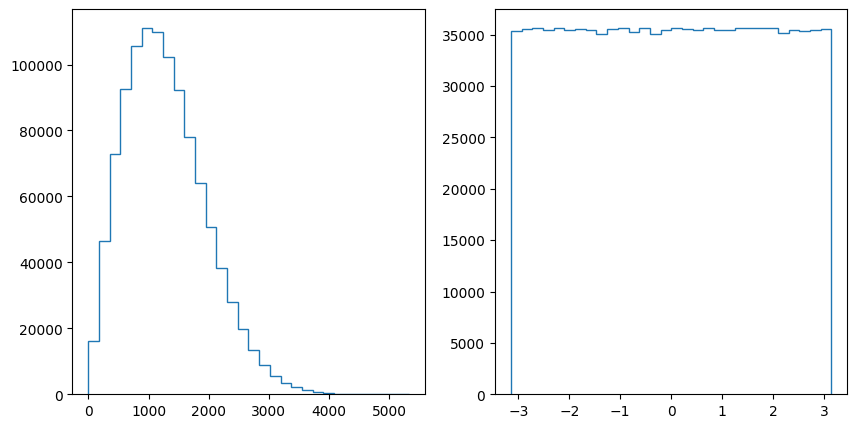

In [3]:
n, L, Ng, seed = 5, 1000., 128, 1234567890
Λ = 2/(n+1)*π*Ng/L
precision = Float32
frequencies = gspt.FFTFrequenciesCore{precision}(L, Ng)

# Power spectrum for initial field (substitute with call to emulator)
k, Pₗ = load_Pₗ(precision, "pk_lin_z1.dat")
interp = interpolate(k, Pₗ, FritschCarlsonMonotonicInterpolation())
Pₗ_interp(k_new) = precision(interp(k_new)*(Ng/L)^3)

GRF = gspt.get_GRF(precision, L, Ng, seed)
δₖL = gspt.get_δₖL(GRF, Pₗ_interp, frequencies)
WδₖL = gspt.iso_sharp_filter(δₖL, Λ, frequencies)
δ, _, _, _ = gspt.real_space_spt(n, WδₖL, frequencies)

data = δ[1]
for i in 2:n
    data += δ[i]
end

# ---

# check that the function to extract phases and amplitudes works as expected

GRF = gspt.get_GRF(precision, L, Ng, seed+1) # generate GRF in configuration space
a, p = gspt.get_phases_and_amplitudes(GRF)

print("Are the two fields the same? $(isapprox(FFTW.rfft(GRF.S), @. complex(a*cos(p), a*sin(p))))")

# ---

fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(121)
ax.hist([a[i] for i in eachindex(a)], bins=30, histtype="step")
# ax.set_title("Amplitudes \$A_{\vec{k}}\$")

ax = fig.add_subplot(122)
ax.hist([p[i] for i in eachindex(p)], bins=30, histtype="step")
# ax.set_title("Phases \$\theta_{\vec{k}}\$")

plt.show()

### GPU

Are the two fields the same? true


sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


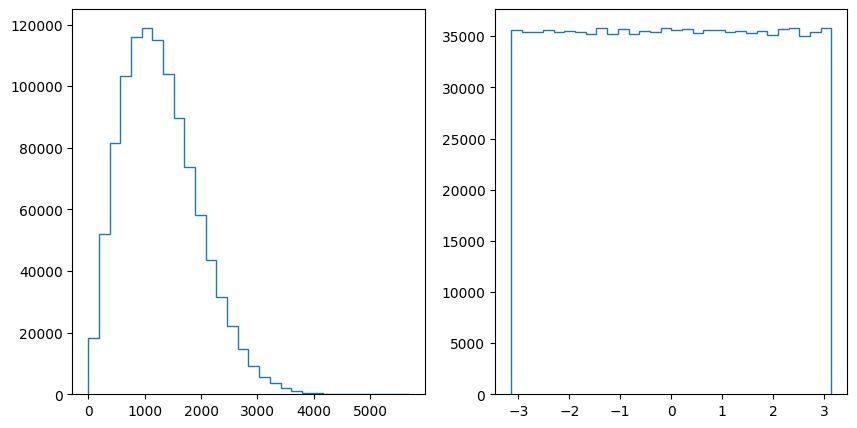

In [2]:
n, L, Ng, seed = 5, 1000., 128, 1234567890
Λ = 2/(n+1)*π*Ng/L
precision = Float32
frequencies = ggspt.FFTFrequenciesCUDA{precision}(L, Ng)

# Power spectrum for initial field (substitute with call to emulator)
np = pyimport("numpy")
sqrtPL = ggspt.CuArray(np.load("sqrtPL_ng128.npy"))

GRF = ggspt.get_GRF(precision, L, Ng, seed)
δₖL = ggspt.do_fft(GRF)*sqrtPL
WδₖL = ggspt.iso_sharp_filter(δₖL, Λ, frequencies)
δ, _, _, _ = ggspt.real_space_spt(n, WδₖL, frequencies)

data = δ[1]
for i in 2:n
    data += δ[i]
end

# check that the function to extract phases and amplitudes works as expected

GRF = ggspt.get_GRF(precision, L, Ng, seed+1) # generate GRF in configuration space
a, p = ggspt.get_phases_and_amplitudes(GRF)

print("Are the two fields the same? $(isapprox((ggspt.do_fft(GRF)).S, @. complex(a*cos(p), a*sin(p))))\n")

fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(121)
A = Array(a)
ax.hist([A[i] for i in eachindex(A)], bins=30, histtype="step")
# ax.set_title("Amplitudes \$A_{\vec{k}}\$")

ax = fig.add_subplot(122)
P = Array(p)
ax.hist([P[i] for i in eachindex(P)], bins=30, histtype="step")
# ax.set_title("Phases \$\theta_{\vec{k}}\$")

plt.show()

## 6.1 Derivatives of the linear density field

We use ICs generated in Fourier space, where $\delta^{(1)}(\vec{k})\propto\sqrt{P_L(k)}A(\vec{k})\exp{\left[i\theta(\vec{k})\right]}$. For a Gaussian random field, the amplitudes $A_{\vec{k}}\equiv A(\vec{k})$ are distributed according to a Reyleigh distribution, while the phases $\theta_{\vec{k}}\equiv \theta(\vec{k})$ are uniformly distributed.

The gradients with respect to these two quantities for a Fourier space likelihood like

\begin{align}
    \mathcal{L}(A_{\vec{k}},\,\theta_{\vec{k}}) & =\sum_{\vec{k}}\left(\text{data}(\vec{k})-\delta^{(1)}(\vec{k})\right)^2 \\
    & =\sum_{\vec{k}}\left[\left(\text{data}(\vec{k})-\delta^{(1)}(\vec{k})\right)\overline{\left(\text{data}(\vec{k})-\delta^{(1)}(\vec{k})\right)}\right]
\end{align}

are really simple to calculate exactly:

\begin{gather}
    \frac{\partial}{\partial A_{\vec{k}'}}\mathcal{L}(A_{\vec{k}},\,\theta_{\vec{k}}) = \frac{2}{A_{\vec{k}'}}\text{Re}\left[\delta^{(1)}(\vec{k}')\overline{\left(\delta^{(1)}(\vec{k}')-\text{data}(\vec{k}')\right)}\right] \\
    \frac{\partial}{\partial \theta_{\vec{k}'}}\mathcal{L}(A_{\vec{k}},\,\theta_{\vec{k}}) = 2\text{Re}\left[i\delta^{(1)}(\vec{k}')\overline{\left(\delta^{(1)}(\vec{k}')-\text{data}(\vec{k}')\right)}\right] \\
\end{gather}

In [4]:
function ℒ1(
    Aₖ::Array{T, 3},
    θₖ::Array{T, 3},
    L::Real,
    Ng::Integer,
    data::gspt.ScalarFieldCore{T},
    Pₗ_interp::Function,
    frequencies::gspt.FFTFrequenciesCore{T}
) where T<:Real
    GRFₖ = gspt.get_GRF(L, Ng, Aₖ, θₖ)
    δₖL = gspt.get_δₖL(GRFₖ, Pₗ_interp, frequencies)
    dataₖ = gspt.do_fft(data)
    χ²like = sum(abs2.(dataₖ.S-δₖL.S))

    return χ²like
end

∂ℒ1∂Aₖ(
    Aₖ::Array{T, 3},
    θₖ::Array{T, 3},
    L::Real,
    Ng::Integer,
    data::gspt.ScalarFieldCore{T},
    Pₗ_interp::Function,
    frequencies::gspt.FFTFrequenciesCore{T}
) where T<:Real = gradient(Aₖ -> ℒ1(Aₖ, θₖ, L, Ng, data, Pₗ_interp, frequencies), Aₖ)
∂ℒ1∂θₖ(
    Aₖ::Array{T, 3},
    θₖ::Array{T, 3},
    L::Real,
    Ng::Integer,
    data::gspt.ScalarFieldCore{T},
    Pₗ_interp::Function,
    frequencies::gspt.FFTFrequenciesCore{T}
) where T<:Real = gradient(θₖ -> ℒ1(Aₖ, θₖ, L, Ng, data, Pₗ_interp, frequencies), θₖ)

like = ℒ1(a, p, L, Ng, data, Pₗ_interp, frequencies)
gradlikeAₖ = ∂ℒ1∂Aₖ(a, p, L, Ng, data, Pₗ_interp, frequencies)
gradlikeθₖ = ∂ℒ1∂θₖ(a, p, L, Ng, data, Pₗ_interp, frequencies)

print("  - Likelihood: $like\n")
print("  - Gradient of Likelihood wrt amplitudes (first 10 values):\n")
print("    $(gradlikeAₖ[1][begin:begin+9])\n\n")
print("  - Gradient of Likelihood wrt phases (first 10 values):\n")
print("    $(gradlikeθₖ[1][begin:begin+9])\n\n")

dataₖ = gspt.do_fft(data)
tmp = @. complex(a*cos(p), a*sin(p))
GRFₖ = gspt.ScalarFieldCore{Complex{precision}}(
        L,
        Ng,
        tmp,
        true
    )
δₖL = gspt.get_δₖL(GRFₖ, Pₗ_interp, frequencies)

gradlikeAₖ_exact = @. 2*real(δₖL.S*conj(δₖL.S-dataₖ.S))/a
gradlikeθₖ_exact = @. 2*real(1im*(δₖL.S*conj(δₖL.S-dataₖ.S)))

print("Is the AD gradient for the amplitudes approximately exact? $(isapprox(gradlikeAₖ[1], gradlikeAₖ_exact))\n")
print("Is the AD gradient for the phases approximately exact? $(isapprox(gradlikeθₖ[1], gradlikeθₖ_exact))\n")

  - Likelihood: 1.7827006e12
  - Gradient of Likelihood wrt amplitudes (first 10 values):
    Float32[0.0, 17566.902, 46998.812, 132103.45, 18708.324, 17151.125, 102957.28, 76653.484, 20081.852, 23905.473]

  - Gradient of Likelihood wrt phases (first 10 values):
    Float32[0.0, -2.0513798f7, -2.1288328f7, -3.1223388f7, 2.596382f7, 2.7341446f7, 4.4488172f7, 3.7344692f7, 2.518501f7, 8.2970856f7]

Is the AD gradient for the amplitudes approximately exact? true
Is the AD gradient for the phases approximately exact? true


### GPU

In [3]:
function ℒ1(
    Aₖ::ggspt.CuArray{T, 3},
    θₖ::ggspt.CuArray{T, 3},
    L::Real,
    Ng::Integer,
    data::ggspt.ScalarFieldCUDA{T},
    sqrtPL::ggspt.CuArray{T, 3},
    frequencies::ggspt.FFTFrequenciesCUDA{T}
) where T<:Real
    GRFₖ = ggspt.get_GRF(L, Ng, Aₖ, θₖ)
    δₖL = GRFₖ*sqrtPL
    dataₖ = ggspt.do_fft(data)
    χ²like = sum(abs2.(dataₖ.S-δₖL.S))

    return χ²like
end

∂ℒ1∂Aₖ(
    Aₖ::ggspt.CuArray{T, 3},
    θₖ::ggspt.CuArray{T, 3},
    L::Real,
    Ng::Integer,
    data::ggspt.ScalarFieldCUDA{T},
    sqrtPL::ggspt.CuArray{T, 3},
    frequencies::ggspt.FFTFrequenciesCUDA{T}
) where T<:Real = gradient(Aₖ -> ℒ1(Aₖ, θₖ, L, Ng, data, sqrtPL, frequencies), Aₖ)
∂ℒ1∂θₖ(
    Aₖ::ggspt.CuArray{T, 3},
    θₖ::ggspt.CuArray{T, 3},
    L::Real,
    Ng::Integer,
    data::ggspt.ScalarFieldCUDA{T},
    sqrtPL::ggspt.CuArray{T, 3},
    frequencies::ggspt.FFTFrequenciesCUDA{T}
) where T<:Real = gradient(θₖ -> ℒ1(Aₖ, θₖ, L, Ng, data, sqrtPL, frequencies), θₖ)

like = ℒ1(a, p, L, Ng, data, sqrtPL, frequencies)
gradlikeAₖ = ∂ℒ1∂Aₖ(a, p, L, Ng, data, sqrtPL, frequencies)
gradlikeθₖ = ∂ℒ1∂θₖ(a, p, L, Ng, data, sqrtPL, frequencies)

print("  - Likelihood: $like\n")
print("  - Gradient of Likelihood wrt amplitudes (first 10 values):\n")
print("    $(ggspt.CUDA.@sync(Array(gradlikeAₖ[1]))[begin:begin+9])\n\n")
print("  - Gradient of Likelihood wrt phases (first 10 values):\n")
print("    $(ggspt.CUDA.@sync(Array(gradlikeθₖ[1]))[begin:begin+9])\n\n")

dataₖ = ggspt.do_fft(data)
tmp = @. complex(a*cos(p), a*sin(p))
GRFₖ = ggspt.ScalarFieldCUDA{Complex{Float32}}(
        L,
        Ng,
        tmp,
        true
    )
δₖL = GRFₖ*sqrtPL

gradlikeAₖ_exact = @. 2*real(δₖL.S*conj(δₖL.S-dataₖ.S))/a
gradlikeθₖ_exact = @. 2*real(1im*(δₖL.S*conj(δₖL.S-dataₖ.S)))

print("Is the AD gradient for the amplitudes approximately exact? $(isapprox(gradlikeAₖ[1], gradlikeAₖ_exact))\n")
print("Is the AD gradient for the phases approximately exact? $(isapprox(gradlikeθₖ[1], gradlikeθₖ_exact))\n")

  - Likelihood: 1.794852e12
  - Gradient of Likelihood wrt amplitudes (first 10 values):
    Float32[-0.0, 55565.42, 43291.38, 147975.56, 12403.1, 15550.275, 45846.348, 88.53824, 69504.62, 25098.09]

  - Gradient of Likelihood wrt phases (first 10 values):
    Float32[0.0, 3.973811f7, -3.490303f6, 4.011875f7, -4.4849804f7, -2.1484982f7, -1.1948181f7, -2.4032985f6, -3.4701984f7, -2.5393746f7]

Is the AD gradient for the amplitudes approximately exact? true
Is the AD gradient for the phases approximately exact? true


## 6.2 Derivatives of the linear density field (round-trip FFT)

We repeat the test above, except that we apply an FFT and iFFT to the linear order field. The goal is to make sure FFTs do not add any spurious contributions to the derivatives.

**!!!NOTE!!!**

When using AD, support for planned FFTs is not guaranteed. Make sure to use unplanned FFTs in order to get the correct results.

In [5]:
function ℒ2(
    Aₖ::Array{T, 3},
    θₖ::Array{T, 3},
    L::Real,
    Ng::Integer,
    data::gspt.ScalarFieldCore{T},
    Pₗ_interp::Function,
    frequencies::gspt.FFTFrequenciesCore{T}
) where T<:Real
    GRFₖ = gspt.get_GRF(L, Ng, Aₖ, θₖ)
    δₖL = gspt.get_δₖL(GRFₖ, Pₗ_interp, frequencies)
    dataₖ = gspt.do_fft(data)

    δL = gspt.do_ifft(δₖL)
    δₖL = gspt.do_fft(δL)
    
    χ²like = sum(abs2.(dataₖ.S-δₖL.S))

    return χ²like
end

∂ℒ2∂Aₖ(
    Aₖ::Array{T, 3},
    θₖ::Array{T, 3},
    L::Real,
    Ng::Integer,
    data::gspt.ScalarFieldCore{T},
    Pₗ_interp::Function,
    frequencies::gspt.FFTFrequenciesCore{T}
) where T<:Real = gradient(Aₖ -> ℒ2(Aₖ, θₖ, L, Ng, data, Pₗ_interp, frequencies), Aₖ)
∂ℒ2∂θₖ(
    Aₖ::Array{T, 3},
    θₖ::Array{T, 3},
    L::Real,
    Ng::Integer,
    data::gspt.ScalarFieldCore{T},
    Pₗ_interp::Function,
    frequencies::gspt.FFTFrequenciesCore{T}
) where T<:Real = gradient(θₖ -> ℒ2(Aₖ, θₖ, L, Ng, data, Pₗ_interp, frequencies), θₖ)

like = ℒ2(a, p, L, Ng, data, Pₗ_interp, frequencies)
gradlikeAₖ = ∂ℒ2∂Aₖ(a, p, L, Ng, data, Pₗ_interp, frequencies)
gradlikeθₖ = ∂ℒ2∂θₖ(a, p, L, Ng, data, Pₗ_interp, frequencies)

print("  - Likelihood: $like\n")
print("  - Gradient of Likelihood wrt amplitudes (first 10 values):\n")
print("    $(gradlikeAₖ[1][begin:begin+9])\n\n")
print("  - Gradient of Likelihood wrt phases (first 10 values):\n")
print("    $(gradlikeθₖ[1][begin:begin+9])\n\n")

dataₖ = gspt.do_fft(data)
tmp = @. complex(a*cos(p), a*sin(p))
GRFₖ = gspt.ScalarFieldCore{Complex{precision}}(
        L,
        Ng,
        tmp,
        true
    )
δₖL = gspt.get_δₖL(GRFₖ, Pₗ_interp, frequencies)

gradlikeAₖ_exact = @. 2*real(δₖL.S*conj(δₖL.S-dataₖ.S))/a
gradlikeθₖ_exact = @. 2*real(1im*(δₖL.S*conj(δₖL.S-dataₖ.S)))

print("Is the AD gradient for the amplitudes approximately exact? $(isapprox(gradlikeAₖ[1], gradlikeAₖ_exact))\n")
print("Is the AD gradient for the phases approximately exact? $(isapprox(gradlikeθₖ[1], gradlikeθₖ_exact))\n")

  - Likelihood: 1.7827e12
  - Gradient of Likelihood wrt amplitudes (first 10 values):
    Float32[-0.0, 17566.898, 46998.82, 132103.45, 18708.322, 17151.125, 102957.28, 76653.484, 20081.848, 23905.473]

  - Gradient of Likelihood wrt phases (first 10 values):
    Float32[0.0, -2.0513792f7, -2.1288326f7, -3.1223392f7, 2.596382f7, 2.7341446f7, 4.4488172f7, 3.7344692f7, 2.5185012f7, 8.2970856f7]

Is the AD gradient for the amplitudes approximately exact? true
Is the AD gradient for the phases approximately exact? true


### GPU

In [4]:
function ℒ2(
    Aₖ::ggspt.CuArray{T, 3},
    θₖ::ggspt.CuArray{T, 3},
    L::Real,
    Ng::Integer,
    data::ggspt.ScalarFieldCUDA{T},
    sqrtPL::ggspt.CuArray{T, 3},
    frequencies::ggspt.FFTFrequenciesCUDA{T}
) where T<:Real
    GRFₖ = ggspt.get_GRF(L, Ng, Aₖ, θₖ)
    δₖL = GRFₖ*sqrtPL
    dataₖ = ggspt.do_fft(data)

    δL = ggspt.do_ifft(δₖL)
    δₖL = ggspt.do_fft(δL)
    
    χ²like = sum(abs2.(dataₖ.S-δₖL.S))

    return χ²like
end

∂ℒ2∂Aₖ(
    Aₖ::ggspt.CuArray{T, 3},
    θₖ::ggspt.CuArray{T, 3},
    L::Real,
    Ng::Integer,
    data::ggspt.ScalarFieldCUDA{T},
    sqrtPL::ggspt.CuArray{T, 3},
    frequencies::ggspt.FFTFrequenciesCUDA{T}
) where T<:Real = gradient(Aₖ -> ℒ2(Aₖ, θₖ, L, Ng, data, sqrtPL, frequencies), Aₖ)
∂ℒ2∂θₖ(
    Aₖ::ggspt.CuArray{T, 3},
    θₖ::ggspt.CuArray{T, 3},
    L::Real,
    Ng::Integer,
    data::ggspt.ScalarFieldCUDA{T},
    sqrtPL::ggspt.CuArray{T, 3},
    frequencies::ggspt.FFTFrequenciesCUDA{T}
) where T<:Real = gradient(θₖ -> ℒ2(Aₖ, θₖ, L, Ng, data, sqrtPL, frequencies), θₖ)

like = ℒ2(a, p, L, Ng, data, sqrtPL, frequencies)
gradlikeAₖ = ∂ℒ2∂Aₖ(a, p, L, Ng, data, sqrtPL, frequencies)
gradlikeθₖ = ∂ℒ2∂θₖ(a, p, L, Ng, data, sqrtPL, frequencies)

print("  - Likelihood: $like\n")
print("  - Gradient of Likelihood wrt amplitudes (first 10 values):\n")
print("    $(ggspt.CUDA.@sync(Array(gradlikeAₖ[1]))[begin:begin+9])\n\n")
print("  - Gradient of Likelihood wrt phases (first 10 values):\n")
print("    $(ggspt.CUDA.@sync(Array(gradlikeθₖ[1]))[begin:begin+9])\n\n")

dataₖ = ggspt.do_fft(data)
tmp = @. complex(a*cos(p), a*sin(p))
GRFₖ = ggspt.ScalarFieldCUDA{Complex{precision}}(
        L,
        Ng,
        tmp,
        true
    )
δₖL = GRFₖ*sqrtPL

gradlikeAₖ_exact = @. 2*real(δₖL.S*conj(δₖL.S-dataₖ.S))/a
gradlikeθₖ_exact = @. 2*real(1im*(δₖL.S*conj(δₖL.S-dataₖ.S)))

print("Is the AD gradient for the amplitudes approximately exact? $(isapprox(gradlikeAₖ[1], gradlikeAₖ_exact))\n")
print("Is the AD gradient for the phases approximately exact? $(isapprox(gradlikeθₖ[1], gradlikeθₖ_exact))\n")

  - Likelihood: 1.7948512e12
  - Gradient of Likelihood wrt amplitudes (first 10 values):
    Float32[0.0, 55565.414, 43291.367, 147975.58, 12403.094, 15550.284, 45846.344, 88.53534, 69504.61, 25098.086]

  - Gradient of Likelihood wrt phases (first 10 values):
    Float32[0.0, 3.97381f7, -3.490304f6, 4.0118744f7, -4.48498f7, -2.1484986f7, -1.194818f7, -2.4033f6, -3.4701996f7, -2.5393744f7]

Is the AD gradient for the amplitudes approximately exact? true
Is the AD gradient for the phases approximately exact? true


## 6.3 Derivatives of the sum of linear density fields

We now test the sum of two density fields:

\begin{align}
    \mathcal{L}(A_{\vec{k}},\,\theta_{\vec{k}}) & =\sum_{\vec{k}}\left(\text{data}(\vec{k})-\delta^{(1)}(\vec{k})-\delta^{(1)}(\vec{k})\right)^2 \\
    & =\sum_{\vec{k}}\left[\left(\text{data}(\vec{k})-2\delta^{(1)}(\vec{k})\right)\overline{\left(\text{data}(\vec{k})-2\delta^{(1)}(\vec{k})\right)}\right]\,.
\end{align}

The derivatives are:

\begin{gather}
    \frac{\partial}{\partial A_{\vec{k}'}}\mathcal{L}(A_{\vec{k}},\,\theta_{\vec{k}}) = \frac{4}{A_{\vec{k}'}}\text{Re}\left[\delta^{(1)}(\vec{k}')\overline{\left(2\delta^{(1)}(\vec{k}')-\text{data}(\vec{k}')\right)}\right] \\
    \frac{\partial}{\partial \theta_{\vec{k}'}}\mathcal{L}(A_{\vec{k}},\,\theta_{\vec{k}}) = 4\text{Re}\left[i\delta^{(1)}(\vec{k}')\overline{\left(2\delta^{(1)}(\vec{k}')-\text{data}(\vec{k}')\right)}\right] \\
\end{gather}

In [6]:
function ℒ3(
    Aₖ::Array{T, 3},
    θₖ::Array{T, 3},
    L::Real,
    Ng::Integer,
    data::gspt.ScalarFieldCore{T},
    Pₗ_interp::Function,
    frequencies::gspt.FFTFrequenciesCore{T}
) where T<:Real
    GRFₖ = gspt.get_GRF(L, Ng, Aₖ, θₖ)
    δₖL = gspt.get_δₖL(GRFₖ, Pₗ_interp, frequencies)
    dataₖ = gspt.do_fft(data)
    δₖL = δₖL+δₖL
    χ²like = sum(abs2.(dataₖ.S-δₖL.S))

    return χ²like
end

∂ℒ3∂Aₖ(
    Aₖ::Array{T, 3},
    θₖ::Array{T, 3},
    L::Real,
    Ng::Integer,
    data::gspt.ScalarFieldCore{T},
    Pₗ_interp::Function,
    frequencies::gspt.FFTFrequenciesCore{T}
) where T<:Real = gradient(Aₖ -> ℒ3(Aₖ, θₖ, L, Ng, data, Pₗ_interp, frequencies), Aₖ)
∂ℒ3∂θₖ(
    Aₖ::Array{T, 3},
    θₖ::Array{T, 3},
    L::Real,
    Ng::Integer,
    data::gspt.ScalarFieldCore{T},
    Pₗ_interp::Function,
    frequencies::gspt.FFTFrequenciesCore{T}    
) where T<:Real = gradient(θₖ -> ℒ3(Aₖ, θₖ, L, Ng, data, Pₗ_interp, frequencies), θₖ)

like = ℒ3(a, p, L, Ng, data, Pₗ_interp, frequencies)
gradlikeAₖ = ∂ℒ3∂Aₖ(a, p, L, Ng, data, Pₗ_interp, frequencies)
gradlikeθₖ = ∂ℒ3∂θₖ(a, p, L, Ng, data, Pₗ_interp, frequencies)

print("  - Likelihood: $like\n")
print("  - Gradient of Likelihood wrt amplitudes (first 10 values):\n")
print("    $(gradlikeAₖ[1][begin:begin+9])\n\n")
print("  - Gradient of Likelihood wrt phases (first 10 values):\n")
print("    $(gradlikeθₖ[1][begin:begin+9])\n\n")

dataₖ = gspt.do_fft(data)
tmp = @. complex(a*cos(p), a*sin(p))
GRFₖ = gspt.ScalarFieldCore{Complex{precision}}(
        L,
        Ng,
        tmp,
        true
    )
δₖL = gspt.get_δₖL(GRFₖ, Pₗ_interp, frequencies)

gradlikeAₖ_exact = @. 4*real(δₖL.S*conj(2*δₖL.S-dataₖ.S))/a
gradlikeθₖ_exact = @. 4*real(1im*(δₖL.S*conj(2*δₖL.S-dataₖ.S)))

print("Is the AD gradient for the amplitudes approximately exact? $(isapprox(gradlikeAₖ[1], gradlikeAₖ_exact))\n")
print("Is the AD gradient for the phases approximately exact? $(isapprox(gradlikeθₖ[1], gradlikeθₖ_exact))\n")

  - Likelihood: 6.2218174e12
  - Gradient of Likelihood wrt amplitudes (first 10 values):
    Float32[0.0, 73983.664, 146415.72, 386472.3, 82205.78, 68248.914, 283001.78, 224998.55, 94771.97, 95494.58]

  - Gradient of Likelihood wrt phases (first 10 values):
    Float32[0.0, -4.1027596f7, -4.2576652f7, -6.2446784f7, 5.192764f7, 5.4682896f7, 8.897635f7, 7.4689384f7, 5.037002f7, 1.6594171f8]

Is the AD gradient for the amplitudes approximately exact? true
Is the AD gradient for the phases approximately exact? true


Now we try by doing the same operation, but it's a product of a field with a scalar (in this case $2\delta^{(1)}(\vec{k})$). This check is necessary because a scalar-array product has its own pullback function (the reverse operation necessary to construct the gradient) different from an array-array product (and also, of course, from an array-array sum). Since mathematically $2\delta^{(1)}(\vec{k})=\delta^{(1)}(\vec{k})+\delta^{(1)}(\vec{k})$, the result of this test must be the same with the one above. Indeed the results are the same.

In [7]:
function ℒ3alt(
    Aₖ::Array{T, 3},
    θₖ::Array{T, 3},
    L::Real,
    Ng::Integer,
    data::gspt.ScalarFieldCore{T},
    Pₗ_interp::Function,
    frequencies::gspt.FFTFrequenciesCore{T}
) where T<:Real
    GRFₖ = gspt.get_GRF(L, Ng, Aₖ, θₖ)
    δₖL = gspt.get_δₖL(GRFₖ, Pₗ_interp, frequencies)
    dataₖ = gspt.do_fft(data)
    δₖL = 2*δₖL
    χ²like = sum(abs2.(dataₖ.S-δₖL.S))

    return χ²like
end

∂ℒ3alt∂Aₖ(
    Aₖ::Array{T, 3},
    θₖ::Array{T, 3},
    L::Real,
    Ng::Integer,
    data::gspt.ScalarFieldCore{T},
    Pₗ_interp::Function,
    frequencies::gspt.FFTFrequenciesCore{T}
) where T<:Real = gradient(Aₖ -> ℒ3alt(Aₖ, θₖ, L, Ng, data, Pₗ_interp, frequencies), Aₖ)
∂ℒ3alt∂θₖ(
    Aₖ::Array{T, 3},
    θₖ::Array{T, 3},
    L::Real,
    Ng::Integer,
    data::gspt.ScalarFieldCore{T},
    Pₗ_interp::Function,
    frequencies::gspt.FFTFrequenciesCore{T}    
) where T<:Real = gradient(θₖ -> ℒ3alt(Aₖ, θₖ, L, Ng, data, Pₗ_interp, frequencies), θₖ)

like = ℒ3alt(a, p, L, Ng, data, Pₗ_interp, frequencies)
gradlikeAₖ = ∂ℒ3alt∂Aₖ(a, p, L, Ng, data, Pₗ_interp, frequencies)
gradlikeθₖ = ∂ℒ3alt∂θₖ(a, p, L, Ng, data, Pₗ_interp, frequencies)

print("  - Likelihood: $like\n")
print("  - Gradient of Likelihood wrt amplitudes (first 10 values):\n")
print("    $(gradlikeAₖ[1][begin:begin+9])\n\n")
print("  - Gradient of Likelihood wrt phases (first 10 values):\n")
print("    $(gradlikeθₖ[1][begin:begin+9])\n\n")

dataₖ = gspt.do_fft(data)
tmp = @. complex(a*cos(p), a*sin(p))
GRFₖ = gspt.ScalarFieldCore{Complex{precision}}(
        L,
        Ng,
        tmp,
        true
    )
δₖL = gspt.get_δₖL(GRFₖ, Pₗ_interp, frequencies)

gradlikeAₖ_exact = @. 4*real(δₖL.S*conj(2*δₖL.S-dataₖ.S))/a
gradlikeθₖ_exact = @. 4*real(1im*(δₖL.S*conj(2*δₖL.S-dataₖ.S)))

print("Is the AD gradient for the amplitudes approximately exact? $(isapprox(gradlikeAₖ[1], gradlikeAₖ_exact))\n")
print("Is the AD gradient for the phases approximately exact? $(isapprox(gradlikeθₖ[1], gradlikeθₖ_exact))\n")

  - Likelihood: 6.2218174e12
  - Gradient of Likelihood wrt amplitudes (first 10 values):
    Float32[0.0, 73983.664, 146415.72, 386472.3, 82205.78, 68248.914, 283001.78, 224998.55, 94771.97, 95494.58]

  - Gradient of Likelihood wrt phases (first 10 values):
    Float32[0.0, -4.1027596f7, -4.2576652f7, -6.2446784f7, 5.192764f7, 5.4682896f7, 8.897635f7, 7.4689384f7, 5.037002f7, 1.6594171f8]

Is the AD gradient for the amplitudes approximately exact? true
Is the AD gradient for the phases approximately exact? true


### GPU

In [5]:
function ℒ3(
    Aₖ::ggspt.CuArray{T, 3},
    θₖ::ggspt.CuArray{T, 3},
    L::Real,
    Ng::Integer,
    data::ggspt.ScalarFieldCUDA{T},
    sqrtPL::ggspt.CuArray{T, 3},
    frequencies::ggspt.FFTFrequenciesCUDA{T}
) where T<:Real
    GRFₖ = ggspt.get_GRF(L, Ng, Aₖ, θₖ)
    δₖL = GRFₖ*sqrtPL
    dataₖ = ggspt.do_fft(data)
    δₖL = δₖL+δₖL
    χ²like = sum(abs2.(dataₖ.S-δₖL.S))

    return χ²like
end

∂ℒ3∂Aₖ(
    Aₖ::ggspt.CuArray{T, 3},
    θₖ::ggspt.CuArray{T, 3},
    L::Real,
    Ng::Integer,
    data::ggspt.ScalarFieldCUDA{T},
    sqrtPL::ggspt.CuArray{T, 3},
    frequencies::ggspt.FFTFrequenciesCUDA{T}
) where T<:Real = gradient(Aₖ -> ℒ3(Aₖ, θₖ, L, Ng, data, sqrtPL, frequencies), Aₖ)
∂ℒ3∂θₖ(
    Aₖ::ggspt.CuArray{T, 3},
    θₖ::ggspt.CuArray{T, 3},
    L::Real,
    Ng::Integer,
    data::ggspt.ScalarFieldCUDA{T},
    sqrtPL::ggspt.CuArray{T, 3},
    frequencies::ggspt.FFTFrequenciesCUDA{T}
) where T<:Real = gradient(θₖ -> ℒ3(Aₖ, θₖ, L, Ng, data, sqrtPL, frequencies), θₖ)

like = ℒ3(a, p, L, Ng, data, sqrtPL, frequencies)
gradlikeAₖ = ∂ℒ3∂Aₖ(a, p, L, Ng, data, sqrtPL, frequencies)
gradlikeθₖ = ∂ℒ3∂θₖ(a, p, L, Ng, data, sqrtPL, frequencies)

print("  - Likelihood: $like\n")
print("  - Gradient of Likelihood wrt amplitudes (first 10 values):\n")
print("    $(ggspt.CUDA.@sync(Array(gradlikeAₖ[1]))[begin:begin+9])\n\n")
print("  - Gradient of Likelihood wrt phases (first 10 values):\n")
print("    $(ggspt.CUDA.@sync(Array(gradlikeθₖ[1]))[begin:begin+9])\n\n")

dataₖ = ggspt.do_fft(data)
tmp = @. complex(a*cos(p), a*sin(p))
GRFₖ = ggspt.ScalarFieldCUDA{Complex{precision}}(
        L,
        Ng,
        tmp,
        true
    )
δₖL = GRFₖ*sqrtPL

gradlikeAₖ_exact = @. 4*real(δₖL.S*conj(2*δₖL.S-dataₖ.S))/a
gradlikeθₖ_exact = @. 4*real(1im*(δₖL.S*conj(2*δₖL.S-dataₖ.S)))

print("Is the AD gradient for the amplitudes approximately exact? $(isapprox(gradlikeAₖ[1], gradlikeAₖ_exact))\n")
print("Is the AD gradient for the phases approximately exact? $(isapprox(gradlikeθₖ[1], gradlikeθₖ_exact))\n")

  - Likelihood: 6.238562e12
  - Gradient of Likelihood wrt amplitudes (first 10 values):
    Float32[-0.0, 210960.88, 146914.44, 407422.25, 89906.09, 92680.33, 153574.08, 42963.72, 225190.27, 122758.516]

  - Gradient of Likelihood wrt phases (first 10 values):
    Float32[0.0, 7.947624f7, -6.980608f6, 8.023746f7, -8.969962f7, -4.296997f7, -2.3896364f7, -4.806597f6, -6.940395f7, -5.078749f7]

Is the AD gradient for the amplitudes approximately exact? true
Is the AD gradient for the phases approximately exact? true


In [7]:
function ℒ3alt(
    Aₖ::ggspt.CuArray{T, 3},
    θₖ::ggspt.CuArray{T, 3},
    L::Real,
    Ng::Integer,
    data::ggspt.ScalarFieldCUDA{T},
    sqrtPL::ggspt.CuArray{T, 3},
    frequencies::ggspt.FFTFrequenciesCUDA{T}
) where T<:Real
    GRFₖ = ggspt.get_GRF(L, Ng, Aₖ, θₖ)
    δₖL = GRFₖ*sqrtPL
    dataₖ = ggspt.do_fft(data)
    δₖL = 2*δₖL
    χ²like = sum(abs2.(dataₖ.S-δₖL.S))

    return χ²like
end

∂ℒ3alt∂Aₖ(
    Aₖ::ggspt.CuArray{T, 3},
    θₖ::ggspt.CuArray{T, 3},
    L::Real,
    Ng::Integer,
    data::ggspt.ScalarFieldCUDA{T},
    sqrtPL::ggspt.CuArray{T, 3},
    frequencies::ggspt.FFTFrequenciesCUDA{T}
) where T<:Real = gradient(Aₖ -> ℒ3alt(Aₖ, θₖ, L, Ng, data, sqrtPL, frequencies), Aₖ)
∂ℒ3alt∂θₖ(
    Aₖ::ggspt.CuArray{T, 3},
    θₖ::ggspt.CuArray{T, 3},
    L::Real,
    Ng::Integer,
    data::ggspt.ScalarFieldCUDA{T},
    sqrtPL::ggspt.CuArray{T, 3},
    frequencies::ggspt.FFTFrequenciesCUDA{T}
) where T<:Real = gradient(θₖ -> ℒ3alt(Aₖ, θₖ, L, Ng, data, sqrtPL, frequencies), θₖ)

like = ℒ3alt(a, p, L, Ng, data, sqrtPL, frequencies)
gradlikeAₖ = ∂ℒ3alt∂Aₖ(a, p, L, Ng, data, sqrtPL, frequencies)
gradlikeθₖ = ∂ℒ3alt∂θₖ(a, p, L, Ng, data, sqrtPL, frequencies)

print("  - Likelihood: $like\n")
print("  - Gradient of Likelihood wrt amplitudes (first 10 values):\n")
print("    $(ggspt.CUDA.@sync(Array(gradlikeAₖ[1]))[begin:begin+9])\n\n")
print("  - Gradient of Likelihood wrt phases (first 10 values):\n")
print("    $(ggspt.CUDA.@sync(Array(gradlikeθₖ[1]))[begin:begin+9])\n\n")

dataₖ = ggspt.do_fft(data)
tmp = @. complex(a*cos(p), a*sin(p))
GRFₖ = ggspt.ScalarFieldCUDA{Complex{precision}}(
        L,
        Ng,
        tmp,
        true
    )
δₖL = GRFₖ*sqrtPL

gradlikeAₖ_exact = @. 4*real(δₖL.S*conj(2*δₖL.S-dataₖ.S))/a
gradlikeθₖ_exact = @. 4*real(1im*(δₖL.S*conj(2*δₖL.S-dataₖ.S)))

print("Is the AD gradient for the amplitudes approximately exact? $(isapprox(gradlikeAₖ[1], gradlikeAₖ_exact))\n")
print("Is the AD gradient for the phases approximately exact? $(isapprox(gradlikeθₖ[1], gradlikeθₖ_exact))\n")

  - Likelihood: 6.238562e12
  - Gradient of Likelihood wrt amplitudes (first 10 values):
    Float32[-0.0, 210960.88, 146914.44, 407422.25, 89906.09, 92680.33, 153574.08, 42963.72, 225190.27, 122758.516]

  - Gradient of Likelihood wrt phases (first 10 values):
    Float32[0.0, 7.947624f7, -6.980608f6, 8.023746f7, -8.969962f7, -4.296997f7, -2.3896364f7, -4.806597f6, -6.940395f7, -5.078749f7]

Is the AD gradient for the amplitudes approximately exact? true
Is the AD gradient for the phases approximately exact? true


## 6.4 Derivatives of the product of linear density fields

We now test the product of two density fields:

\begin{align}
    \mathcal{L}(A_{\vec{k}},\,\theta_{\vec{k}}) & =\sum_{\vec{k}}\left(\text{data}(\vec{k})-\delta^{(1)}(\vec{k})\times\delta^{(1)}(\vec{k})\right)^2 \\
    & =\sum_{\vec{k}}\left[\left(\text{data}(\vec{k})-\left[\delta^{(1)}(\vec{k})\right]^2\right)\overline{\left(\text{data}(\vec{k})-\left[\delta^{(1)}(\vec{k})\right]^2\right)}\right]\,.
\end{align}

The derivatives are:

\begin{gather}
    \frac{\partial}{\partial A_{\vec{k}'}}\mathcal{L}(A_{\vec{k}},\,\theta_{\vec{k}}) = \frac{4}{A_{\vec{k}'}}\text{Re}\left[\left[\delta^{(1)}(\vec{k}')\right]^2\overline{\left(\left[\delta^{(1)}(\vec{k}')\right]^2-\text{data}(\vec{k}')\right)}\right] \\
    \frac{\partial}{\partial \theta_{\vec{k}'}}\mathcal{L}(A_{\vec{k}},\,\theta_{\vec{k}}) = 4\text{Re}\left[i\left[\delta^{(1)}(\vec{k}')\right]^2\overline{\left(\left[\delta^{(1)}(\vec{k}')\right]^2-\text{data}(\vec{k}')\right)}\right] \\
\end{gather}

In [10]:
function ℒ4(
    Aₖ::Array{T, 3},
    θₖ::Array{T, 3},
    L::Real,
    Ng::Integer,
    data::gspt.ScalarFieldCore{T},
    Pₗ_interp::Function,
    frequencies::gspt.FFTFrequenciesCore{T}
) where T<:Real
    GRFₖ = gspt.get_GRF(L, Ng, Aₖ, θₖ)
    δₖL = gspt.get_δₖL(GRFₖ, Pₗ_interp, frequencies)
    dataₖ = gspt.do_fft(data)
    δₖL = δₖL*δₖL
    χ²like = sum(abs2.(dataₖ.S-δₖL.S))

    return χ²like
end

∂ℒ4∂Aₖ(
    Aₖ::Array{T, 3},
    θₖ::Array{T, 3},
    L::Real,
    Ng::Integer,
    data::gspt.ScalarFieldCore{T},
    Pₗ_interp::Function,
    frequencies::gspt.FFTFrequenciesCore{T}
) where T<:Real = gradient(Aₖ -> ℒ4(Aₖ, θₖ, L, Ng, data, Pₗ_interp, frequencies), Aₖ)
∂ℒ4∂θₖ(
    Aₖ::Array{T, 3},
    θₖ::Array{T, 3},
    L::Real,
    Ng::Integer,
    data::gspt.ScalarFieldCore{T},
    Pₗ_interp::Function,
    frequencies::gspt.FFTFrequenciesCore{T}
) where T<:Real = gradient(θₖ -> ℒ4(Aₖ, θₖ, L, Ng, data, Pₗ_interp, frequencies), θₖ)

like = ℒ4(a, p, L, Ng, data, Pₗ_interp, frequencies)
gradlikeAₖ = ∂ℒ4∂Aₖ(a, p, L, Ng, data, Pₗ_interp, frequencies)
gradlikeθₖ = ∂ℒ4∂θₖ(a, p, L, Ng, data, Pₗ_interp, frequencies)

print("  - Likelihood: $like\n")
print("  - Gradient of Likelihood wrt amplitudes (first 10 values):\n")
print("    $(gradlikeAₖ[1][begin:begin+9])\n\n")
print("  - Gradient of Likelihood wrt phases (first 10 values):\n")
print("    $(gradlikeθₖ[1][begin:begin+9])\n\n")

dataₖ = gspt.do_fft(data)
tmp = @. complex(a*cos(p), a*sin(p))
GRFₖ = gspt.ScalarFieldCore{Complex{precision}}(
        L,
        Ng,
        tmp,
        true
    )
δₖL = gspt.get_δₖL(GRFₖ, Pₗ_interp, frequencies)

gradlikeAₖ_exact = @. 4*real(δₖL.S^2*conj(δₖL.S^2-dataₖ.S))/a
gradlikeθₖ_exact = @. 4*real(1im*(δₖL.S^2*conj(δₖL.S^2-dataₖ.S)))

print("Is the AD gradient for the amplitudes approximately exact? $(isapprox(gradlikeAₖ[1], gradlikeAₖ_exact))\n")
print("Is the AD gradient for the phases approximately exact? $(isapprox(gradlikeθₖ[1], gradlikeθₖ_exact, rtol=0.001))\n")

  - Likelihood: 1.1472949e19
  - Gradient of Likelihood wrt amplitudes (first 10 values):
    Float32[-0.0, 2.6134469f11, 4.6686817f11, 5.754985f12, 3.1001877f11, 1.5714663f11, 2.1726054f12, 2.0295466f12, 1.00911527f12, 7.3220974f11]

  - Gradient of Likelihood wrt phases (first 10 values):
    Float32[0.0, -8.260262f10, -2.3991419f10, 1.3635179f12, -6.0901294f10, 9.880941f10, -1.0902506f12, -4.6033325f11, 2.3082094f11, 3.899696f11]

Is the AD gradient for the amplitudes approximately exact? true
Is the AD gradient for the phases approximately exact? true


**!!!NOTE!!!**

The derivative on phases seems to be especially noisy in the case of products. The AD matches the analytical estimation up to $\lesssim0.1$% at most.

### GPU

In [9]:
function ℒ4(
    Aₖ::ggspt.CuArray{T, 3},
    θₖ::ggspt.CuArray{T, 3},
    L::Real,
    Ng::Integer,
    data::ggspt.ScalarFieldCUDA{T},
    sqrtPL::ggspt.CuArray{T, 3},
    frequencies::ggspt.FFTFrequenciesCUDA{T}
) where T<:Real
    GRFₖ = ggspt.get_GRF(L, Ng, Aₖ, θₖ)
    δₖL = GRFₖ*sqrtPL
    dataₖ = ggspt.do_fft(data)
    δₖL = δₖL*δₖL
    χ²like = sum(abs2.(dataₖ.S-δₖL.S))

    return χ²like
end

∂ℒ4∂Aₖ(
    Aₖ::ggspt.CuArray{T, 3},
    θₖ::ggspt.CuArray{T, 3},
    L::Real,
    Ng::Integer,
    data::ggspt.ScalarFieldCUDA{T},
    sqrtPL::ggspt.CuArray{T, 3},
    frequencies::ggspt.FFTFrequenciesCUDA{T}
) where T<:Real = gradient(Aₖ -> ℒ4(Aₖ, θₖ, L, Ng, data, sqrtPL, frequencies), Aₖ)
∂ℒ4∂θₖ(
    Aₖ::ggspt.CuArray{T, 3},
    θₖ::ggspt.CuArray{T, 3},
    L::Real,
    Ng::Integer,
    data::ggspt.ScalarFieldCUDA{T},
    sqrtPL::ggspt.CuArray{T, 3},
    frequencies::ggspt.FFTFrequenciesCUDA{T}
) where T<:Real = gradient(θₖ -> ℒ4(Aₖ, θₖ, L, Ng, data, sqrtPL, frequencies), θₖ)

like = ℒ4(a, p, L, Ng, data, sqrtPL, frequencies)
gradlikeAₖ = ∂ℒ4∂Aₖ(a, p, L, Ng, data, sqrtPL, frequencies)
gradlikeθₖ = ∂ℒ4∂θₖ(a, p, L, Ng, data, sqrtPL, frequencies)

print("  - Likelihood: $like\n")
print("  - Gradient of Likelihood wrt amplitudes (first 10 values):\n")
print("    $(ggspt.CUDA.@sync(Array(gradlikeAₖ[1]))[begin:begin+9])\n\n")
print("  - Gradient of Likelihood wrt phases (first 10 values):\n")
print("    $(ggspt.CUDA.@sync(Array(gradlikeθₖ[1]))[begin:begin+9])\n\n")

dataₖ = ggspt.do_fft(data)
tmp = @. complex(a*cos(p), a*sin(p))
GRFₖ = ggspt.ScalarFieldCUDA{Complex{precision}}(
        L,
        Ng,
        tmp,
        true
    )
δₖL = GRFₖ*sqrtPL

gradlikeAₖ_exact = @. 4*real(δₖL.S^2*conj(δₖL.S^2-dataₖ.S))/a
gradlikeθₖ_exact = @. 4*real(1im*(δₖL.S^2*conj(δₖL.S^2-dataₖ.S)))

print("Is the AD gradient for the amplitudes approximately exact? $(isapprox(gradlikeAₖ[1], gradlikeAₖ_exact))\n")
print("Is the AD gradient for the phases approximately exact? $(isapprox(gradlikeθₖ[1], gradlikeθₖ_exact, rtol=0.001))\n")

  - Likelihood: 1.1612964e19
  - Gradient of Likelihood wrt amplitudes (first 10 values):
    Float32[0.0, 4.4329515f12, 7.122795f11, 4.3620594f12, 9.52223f11, 9.3715104f11, 1.1236974f12, 4.316544f11, 3.9669376f12, 2.581478f12]

  - Gradient of Likelihood wrt phases (first 10 values):
    Float32[0.0, -2.9017873f11, -5.947523f9, -7.3336567f11, -2.2041906f11, -3.0467424f10, -1.36650424f11, 4.3738202f10, -8.0530637f9, 1.4106283f11]

Is the AD gradient for the amplitudes approximately exact? true
Is the AD gradient for the phases approximately exact? true


## 6.5 Derivatives of the gradient of the linear density field

We now test the spatial gradient (in particular we use the $x$ component):

\begin{align}
    \mathcal{L}(A_{\vec{k}},\,\theta_{\vec{k}}) & =\sum_{\vec{k}}\left(\text{data}(\vec{k})-\text{FT}\left[\vec{\nabla}\delta^{(1)}\cdot\hat{x}\right](\vec{k})\right)^2 \\
    & =\sum_{\vec{k}}\left[\left(\text{data}(\vec{k})-ik_x\delta^{(1)}(\vec{k})\right)\overline{\left(\text{data}(\vec{k})-ik_x\delta^{(1)}(\vec{k})\right)}\right]\,.
\end{align}

The derivatives are:

\begin{gather}
    \frac{\partial}{\partial A_{\vec{k}'}}\mathcal{L}(A_{\vec{k}},\,\theta_{\vec{k}}) = \frac{2}{A_{\vec{k}'}}\text{Re}\left[ik_x'\delta^{(1)}(\vec{k}')\overline{\left(ik_x'\delta^{(1)}(\vec{k}')-\text{data}(\vec{k}')\right)}\right] \\
    \frac{\partial}{\partial \theta_{\vec{k}'}}\mathcal{L}(A_{\vec{k}},\,\theta_{\vec{k}}) = 2\text{Re}\left[-k_x'\delta^{(1)}(\vec{k}')\overline{\left(ik_x'\delta^{(1)}(\vec{k}')-\text{data}(\vec{k}')\right)}\right] \\
\end{gather}

In [10]:
function ℒ5(
    Aₖ::Array{T, 3},
    θₖ::Array{T, 3},
    L::Real,
    Ng::Integer,
    data::gspt.ScalarFieldCore{T},
    Pₗ_interp::Function,
    frequencies::gspt.FFTFrequenciesCore{T}
) where T<:Real
    GRFₖ = gspt.get_GRF(L, Ng, Aₖ, θₖ)
    δₖL = gspt.get_δₖL(GRFₖ, Pₗ_interp, frequencies)
    dataₖ = gspt.do_fft(data)
    ∇δL = gspt.get_gradient(δₖL, frequencies)
    ∇δₖL = gspt.do_fft(∇δL)
    χ²like = sum(abs2.(dataₖ.S-∇δₖL.V[:, :, :, 1]))

    return χ²like
end

∂ℒ5∂Aₖ(
    Aₖ::Array{T, 3},
    θₖ::Array{T, 3},
    L::Real,
    Ng::Integer,
    data::gspt.ScalarFieldCore{T},
    Pₗ_interp::Function,
    frequencies::gspt.FFTFrequenciesCore{T}
) where T<:Real = gradient(Aₖ -> ℒ5(Aₖ, θₖ, L, Ng, data, Pₗ_interp, frequencies), Aₖ)
∂ℒ5∂θₖ(
    Aₖ::Array{T, 3},
    θₖ::Array{T, 3},
    L::Real,
    Ng::Integer,
    data::gspt.ScalarFieldCore{T},
    Pₗ_interp::Function,
    frequencies::gspt.FFTFrequenciesCore{T}
) where T<:Real = gradient(θₖ -> ℒ5(Aₖ, θₖ, L, Ng, data, Pₗ_interp, frequencies), θₖ)

like = ℒ5(a, p, L, Ng, data, Pₗ_interp, frequencies)
gradlikeAₖ = ∂ℒ5∂Aₖ(a, p, L, Ng, data, Pₗ_interp, frequencies)
gradlikeθₖ = ∂ℒ5∂θₖ(a, p, L, Ng, data, Pₗ_interp, frequencies)

print("  - Likelihood: $like\n")
print("  - Gradient of Likelihood wrt amplitudes (first 10 values):\n")
print("    $(gradlikeAₖ[1][begin:begin+9])\n\n")
print("  - Gradient of Likelihood wrt phases (first 10 values):\n")
print("    $(gradlikeθₖ[1][begin:begin+9])\n\n")

dataₖ = gspt.do_fft(data)
tmp = @. complex(a*cos(p), a*sin(p))
GRFₖ = gspt.ScalarFieldCore{Complex{precision}}(
    L,
    Ng,
    tmp,
    true
)
δₖL = gspt.get_δₖL(GRFₖ, Pₗ_interp, frequencies)
∇δL = gspt.get_gradient(δₖL, frequencies)
∇δₖL = gspt.do_fft(∇δL)

gradlikeAₖ_exact = @. 2*real(∇δₖL.V[:, :, :, 1]*conj(∇δₖL.V[:, :, :, 1]-dataₖ.S))/a
gradlikeθₖ_exact = @. 2*real(1im*(∇δₖL.V[:, :, :, 1]*conj(∇δₖL.V[:, :, :, 1]-dataₖ.S)))

print("Is the AD gradient for the amplitudes approximately exact? $(isapprox(gradlikeAₖ[1], gradlikeAₖ_exact))\n")
print("Is the AD gradient for the phases approximately exact? $(isapprox(gradlikeθₖ[1], gradlikeθₖ_exact))\n")

  - Likelihood: 3.487432e11
  - Gradient of Likelihood wrt amplitudes (first 10 values):
    Float32[-0.0, -185.39587, -389.27872, -360.50613, 1069.0847, 1592.6353, 1201.6776, 1109.0132, 1004.2195, 3716.6611]

  - Gradient of Likelihood wrt phases (first 10 values):
    Float32[0.0, 8082.8555, -177646.69, -2.0598729f6, 57306.594, -3044.4062, -3.5510745f6, -2.8355072f6, 491401.7, -4639.25]

Is the AD gradient for the amplitudes approximately exact? false
Is the AD gradient for the phases approximately exact? false


**!!!NOTE!!!** Even though the above is false, the gradients are actually the same except on the Nyquist frequency of the z-axis (see below). Computing the difference between the two doesn't highlight any specific patterns. It's possible that this behavior might be a fault in the way AbstractFFTs rrules are set up for real FFTs, however the same issue doesn't seem to affect the velocity computation (see next section), which makes this bug particularly mysterious...

In [8]:
print("Is the AD gradient for the amplitudes approximately exact? $(isapprox(gradlikeAₖ[1][begin:end-1, :, :], gradlikeAₖ_exact[begin:end-1, :, :]))\n")
print("Is the AD gradient for the phases approximately exact? $(isapprox(gradlikeθₖ[1][begin:end-1, :, :], gradlikeθₖ_exact[begin:end-1, :, :]))\n")

Is the AD gradient for the amplitudes approximately exact? true


In [9]:
gradlikeθₖ[1][end, :, :]-gradlikeθₖ_exact[end, :, :]

128×128 Matrix{Float32}:
 -25798.4         10580.5        …    8063.42        10580.5
  10792.9        -26228.7           -55311.6             1.73969f5
 113193.0         10277.4            -9393.66       -47653.1
   6700.49        16893.5            30022.1         37250.5
     -1.15623f5  -28672.8            83013.8         81543.8
  21087.6            -1.15607f5  …  139752.0         51150.2
 -13416.2         46900.1             2315.61       -16275.0
  11569.1         -8344.46          -10044.7        -34262.5
  29366.9             1.00329f5       1048.46       -61020.2
  28841.7            -1.80341f5      37011.5        -35633.1
  43583.7             1.14341f5  …  -37826.9        -56649.7
 -67093.7         24950.6           -65239.5         89199.5
 -63800.8        -14149.7            21933.5          8890.88
      ⋮                          ⋱                  
 -63800.8          8890.88           23554.7        -14149.7
 -67093.7         89199.5            17486.5         24950.6


### GPU

In [11]:
function ℒ5(
    Aₖ::ggspt.CuArray{T, 3},
    θₖ::ggspt.CuArray{T, 3},
    L::Real,
    Ng::Integer,
    data::ggspt.ScalarFieldCUDA{T},
    sqrtPL::ggspt.CuArray{T, 3},
    frequencies::ggspt.FFTFrequenciesCUDA{T}
) where T<:Real
    GRFₖ = ggspt.get_GRF(L, Ng, Aₖ, θₖ)
    δₖL = GRFₖ*sqrtPL
    dataₖ = ggspt.do_fft(data)
    ∇δL = ggspt.core.get_gradient(δₖL, frequencies)
    ∇δₖL = ggspt.do_fft(∇δL)
    χ²like = sum(abs2.(dataₖ.S-∇δₖL.V[:, :, :, 1]))

    return χ²like
end

∂ℒ5∂Aₖ(
    Aₖ::ggspt.CuArray{T, 3},
    θₖ::ggspt.CuArray{T, 3},
    L::Real,
    Ng::Integer,
    data::ggspt.ScalarFieldCUDA{T},
    sqrtPL::ggspt.CuArray{T, 3},
    frequencies::ggspt.FFTFrequenciesCUDA{T}
) where T<:Real = gradient(Aₖ -> ℒ5(Aₖ, θₖ, L, Ng, data, sqrtPL, frequencies), Aₖ)
∂ℒ5∂θₖ(
    Aₖ::ggspt.CuArray{T, 3},
    θₖ::ggspt.CuArray{T, 3},
    L::Real,
    Ng::Integer,
    data::ggspt.ScalarFieldCUDA{T},
    sqrtPL::ggspt.CuArray{T, 3},
    frequencies::ggspt.FFTFrequenciesCUDA{T}
) where T<:Real = gradient(θₖ -> ℒ5(Aₖ, θₖ, L, Ng, data, sqrtPL, frequencies), θₖ)

like = ℒ5(a, p, L, Ng, data, sqrtPL, frequencies)
gradlikeAₖ = ∂ℒ5∂Aₖ(a, p, L, Ng, data, sqrtPL, frequencies)
gradlikeθₖ = ∂ℒ5∂θₖ(a, p, L, Ng, data, sqrtPL, frequencies)

print("  - Likelihood: $like\n")
print("  - Gradient of Likelihood wrt amplitudes (first 10 values):\n")
print("    $(ggspt.CUDA.@sync(Array(gradlikeAₖ[1]))[begin:begin+9])\n\n")
print("  - Gradient of Likelihood wrt phases (first 10 values):\n")
print("    $(ggspt.CUDA.@sync(Array(gradlikeθₖ[1]))[begin:begin+9])\n\n")

dataₖ = ggspt.do_fft(data)
tmp = @. complex(a*cos(p), a*sin(p))
GRFₖ = ggspt.ScalarFieldCUDA{Complex{precision}}(
    L,
    Ng,
    tmp,
    true
)
δₖL = GRFₖ*sqrtPL
∇δL = ggspt.core.get_gradient(δₖL, frequencies)
∇δₖL = ggspt.do_fft(∇δL)

gradlikeAₖ_exact = @. 2*real(∇δₖL.V[:, :, :, 1]*conj(∇δₖL.V[:, :, :, 1]-dataₖ.S))/a
gradlikeθₖ_exact = @. 2*real(1im*(∇δₖL.V[:, :, :, 1]*conj(∇δₖL.V[:, :, :, 1]-dataₖ.S)))

print("Is the AD gradient for the amplitudes approximately exact? $(isapprox(gradlikeAₖ[1], gradlikeAₖ_exact))\n")
print("Is the AD gradient for the phases approximately exact? $(isapprox(gradlikeθₖ[1], gradlikeθₖ_exact))\n")

  - Likelihood: 3.597489e11
  - Gradient of Likelihood wrt amplitudes (first 10 values):
    Float32[0.0, 142.31076, -51.2781, 558.48193, -1233.1917, -652.25934, -339.73764, -70.72328, -707.6682, -616.15027]

  - Gradient of Likelihood wrt phases (first 10 values):
    Float32[0.0, -63163.125, -129088.91, -2.4408388f6, 455235.06, 473382.22, -659645.25, 883498.5, -2.8362948f6, 1.2402858f6]

Is the AD gradient for the amplitudes approximately exact? false
Is the AD gradient for the phases approximately exact? false


**!!!NOTE!!!** Somehow, for CUDA.CUFFT, the same problem as above is present in the 0 frequency slice of the z-axis too

In [19]:
print("Is the AD gradient for the amplitudes approximately exact? $(isapprox(gradlikeAₖ[1][begin+1:end-1, :, :], gradlikeAₖ_exact[begin+1:end-1, :, :]))\n")
print("Is the AD gradient for the phases approximately exact? $(isapprox(gradlikeθₖ[1][begin+1:end-1, :, :], gradlikeθₖ_exact[begin+1:end-1, :, :]))\n")

Is the AD gradient for the amplitudes approximately exact? true
Is the AD gradient for the phases approximately exact? true


## 6.6 Derivatives of the velocity of the linear density field

We now test the velocity (in particular we use the $x$ component):

\begin{align}
    \mathcal{L}(A_{\vec{k}},\,\theta_{\vec{k}}) & =\sum_{\vec{k}}\left(\text{data}(\vec{k})-\text{FT}\left[\vec{u}^{(1)}\cdot\hat{x}\right](\vec{k})\right)^2 \\
    & =\sum_{\vec{k}}\left[\left(\text{data}(\vec{k})+i\frac{k_x}{k^2}\delta^{(1)}(\vec{k})\right)\overline{\left(\text{data}(\vec{k})+i\frac{k_x}{k^2}\delta^{(1)}(\vec{k})\right)}\right]\,.
\end{align}

The derivatives are:

\begin{gather}
    \frac{\partial}{\partial A_{\vec{k}'}}\mathcal{L}(A_{\vec{k}},\,\theta_{\vec{k}}) = \frac{2}{A_{\vec{k}'}}\text{Re}\left[-i\frac{k_x'}{k'^2}\delta^{(1)}(\vec{k}')\overline{\left(-i\frac{k_x'}{k'^2}\delta^{(1)}(\vec{k}')-\text{data}(\vec{k}')\right)}\right] \\
    \frac{\partial}{\partial \theta_{\vec{k}'}}\mathcal{L}(A_{\vec{k}},\,\theta_{\vec{k}}) = 2\text{Re}\left[\frac{k_x'}{k'^2}\delta^{(1)}(\vec{k}')\overline{\left(-i\frac{k_x'}{k'^2}\delta^{(1)}(\vec{k}')-\text{data}(\vec{k}')\right)}\right] \\
\end{gather}

In [13]:
function ℒ6(
    Aₖ::Array{T, 3},
    θₖ::Array{T, 3},
    L::Real,
    Ng::Integer,
    data::gspt.ScalarFieldCore{T},
    Pₗ_interp::Function,
    frequencies::gspt.FFTFrequenciesCore{T}
) where T<:Real
    GRFₖ = gspt.get_GRF(L, Ng, Aₖ, θₖ)
    δₖL = gspt.get_δₖL(GRFₖ, Pₗ_interp, frequencies)
    dataₖ = gspt.do_fft(data)
    uL = gspt.get_velocity(δₖL, frequencies)
    uₖL = gspt.do_fft(uL)
    χ²like = sum(abs2.(dataₖ.S-uₖL.V[:, :, :, 1]))

    return χ²like
end

∂ℒ6∂Aₖ(
    Aₖ::Array{T, 3},
    θₖ::Array{T, 3},
    L::Real,
    Ng::Integer,
    data::gspt.ScalarFieldCore{T},
    Pₗ_interp::Function,
    frequencies::gspt.FFTFrequenciesCore{T}
) where T<:Real = gradient(Aₖ -> ℒ6(Aₖ, θₖ, L, Ng, data, Pₗ_interp, frequencies), Aₖ)
∂ℒ6∂θₖ(
    Aₖ::Array{T, 3},
    θₖ::Array{T, 3},
    L::Real,
    Ng::Integer,
    data::gspt.ScalarFieldCore{T},
    Pₗ_interp::Function,
    frequencies::gspt.FFTFrequenciesCore{T}
) where T<:Real = gradient(θₖ -> ℒ6(Aₖ, θₖ, L, Ng, data, Pₗ_interp, frequencies), θₖ)

like = ℒ6(a, p, L, Ng, data, Pₗ_interp, frequencies)
gradlikeAₖ = ∂ℒ6∂Aₖ(a, p, L, Ng, data, Pₗ_interp, frequencies)
gradlikeθₖ = ∂ℒ6∂θₖ(a, p, L, Ng, data, Pₗ_interp, frequencies)

print("  - Likelihood: $like\n")
print("  - Gradient of Likelihood wrt amplitudes (first 10 values):\n")
print("    $(gradlikeAₖ[1][begin:begin+9])\n\n")
print("  - Gradient of Likelihood wrt phases (first 10 values):\n")
print("    $(gradlikeθₖ[1][begin:begin+9])\n\n")

dataₖ = gspt.do_fft(data)
tmp = @. complex(a*cos(p), a*sin(p))
GRFₖ = gspt.ScalarFieldCore{Complex{precision}}(
        L,
        Ng,
        tmp,
        true
    )
δₖL = gspt.get_δₖL(GRFₖ, Pₗ_interp, frequencies)
uL = gspt.get_velocity(δₖL, frequencies)
uₖL = gspt.do_fft(uL)

gradlikeAₖ_exact = @. 2*real(uₖL.V[:, :, :, 1]*conj(uₖL.V[:, :, :, 1]-dataₖ.S))/a
gradlikeθₖ_exact = @. 2*real(1im*(uₖL.V[:, :, :, 1]*conj(uₖL.V[:, :, :, 1]-dataₖ.S)))

print("Is the AD gradient for the amplitudes approximately exact? $(isapprox(gradlikeAₖ[1], gradlikeAₖ_exact))\n")
print("Is the AD gradient for the phases approximately exact? $(isapprox(gradlikeθₖ[1], gradlikeθₖ_exact, rtol=0.001))\n")

  - Likelihood: 2.71096e13
  - Gradient of Likelihood wrt amplitudes (first 10 values):
    Float32[-0.0, 4.967547f8, 1.6846206f8, 1.7313242f8, 3.3783692f7, 1.5600877f7, 2.6313048f7, 1.7992834f7, 1.0436438f7, 6.3173755f6]

  - Gradient of Likelihood wrt phases (first 10 values):
    Float32[0.0, -2.0475085f8, 1.1249705f9, 5.797458f9, -9.072282f7, 3.084032f6, 2.498604f9, 1.4658031f9, -1.9448986f8, 1.451264f6]

Is the AD gradient for the amplitudes approximately exact? true
Is the AD gradient for the phases approximately exact? true


**!!!NOTE!!!** The velocity seems to also be somewhat numerically unstable when it comes to the phases, as much as the multiplication.

### GPU

In [21]:
function ℒ6(
    Aₖ::ggspt.CuArray{T, 3},
    θₖ::ggspt.CuArray{T, 3},
    L::Real,
    Ng::Integer,
    data::ggspt.ScalarFieldCUDA{T},
    sqrtPL::ggspt.CuArray{T, 3},
    frequencies::ggspt.FFTFrequenciesCUDA{T}
) where T<:Real
    GRFₖ = ggspt.get_GRF(L, Ng, Aₖ, θₖ)
    δₖL = GRFₖ*sqrtPL
    dataₖ = ggspt.do_fft(data)
    uL = ggspt.core.get_velocity(δₖL, frequencies)
    uₖL = ggspt.do_fft(uL)
    χ²like = sum(abs2.(dataₖ.S-uₖL.V[:, :, :, 1]))

    return χ²like
end

∂ℒ6∂Aₖ(
    Aₖ::ggspt.CuArray{T, 3},
    θₖ::ggspt.CuArray{T, 3},
    L::Real,
    Ng::Integer,
    data::ggspt.ScalarFieldCUDA{T},
    sqrtPL::ggspt.CuArray{T, 3},
    frequencies::ggspt.FFTFrequenciesCUDA{T}
) where T<:Real = gradient(Aₖ -> ℒ6(Aₖ, θₖ, L, Ng, data, sqrtPL, frequencies), Aₖ)
∂ℒ6∂θₖ(
    Aₖ::ggspt.CuArray{T, 3},
    θₖ::ggspt.CuArray{T, 3},
    L::Real,
    Ng::Integer,
    data::ggspt.ScalarFieldCUDA{T},
    sqrtPL::ggspt.CuArray{T, 3},
    frequencies::ggspt.FFTFrequenciesCUDA{T}
) where T<:Real = gradient(θₖ -> ℒ6(Aₖ, θₖ, L, Ng, data, sqrtPL, frequencies), θₖ)

like = ℒ6(a, p, L, Ng, data, sqrtPL, frequencies)
gradlikeAₖ = ∂ℒ6∂Aₖ(a, p, L, Ng, data, sqrtPL, frequencies)
gradlikeθₖ = ∂ℒ6∂θₖ(a, p, L, Ng, data, sqrtPL, frequencies)

print("  - Likelihood: $like\n")
print("  - Gradient of Likelihood wrt amplitudes (first 10 values):\n")
print("    $(ggspt.CUDA.@sync(Array(gradlikeAₖ[1]))[begin:begin+9])\n\n")
print("  - Gradient of Likelihood wrt phases (first 10 values):\n")
print("    $(ggspt.CUDA.@sync(Array(gradlikeθₖ[1]))[begin:begin+9])\n\n")

dataₖ = ggspt.do_fft(data)
tmp = @. complex(a*cos(p), a*sin(p))
GRFₖ = ggspt.ScalarFieldCUDA{Complex{precision}}(
    L,
    Ng,
    tmp,
    true
)
δₖL = GRFₖ*sqrtPL
uL = ggspt.core.get_velocity(δₖL, frequencies)
uₖL = ggspt.do_fft(uL)

gradlikeAₖ_exact = @. 2*real(∇δₖL.V[:, :, :, 1]*conj(∇δₖL.V[:, :, :, 1]-dataₖ.S))/a
gradlikeθₖ_exact = @. 2*real(1im*(∇δₖL.V[:, :, :, 1]*conj(∇δₖL.V[:, :, :, 1]-dataₖ.S)))

print("Is the AD gradient for the amplitudes approximately exact? $(isapprox(gradlikeAₖ[1], gradlikeAₖ_exact))\n")
print("Is the AD gradient for the phases approximately exact? $(isapprox(gradlikeθₖ[1], gradlikeθₖ_exact))\n")

  - Likelihood: 2.8343492e13
  - Gradient of Likelihood wrt amplitudes (first 10 values):
    Float32[0.0, 1.260807f9, 1.913822f8, 1.5535034f8, 5.3516096f7, 3.1888348f7, 2.2040454f7, 1.111712f7, 1.7377792f7, 1.1574794f7]

  - Gradient of Likelihood wrt phases (first 10 values):
    Float32[0.0, 1.5999959f9, 8.174633f8, 6.8696474f9, -7.2070554f8, -4.7963955f8, 4.641413f8, -4.5672346f8, 1.1225641f9, -3.878569f8]

Is the AD gradient for the amplitudes approximately exact? false
Is the AD gradient for the phases approximately exact? false


In [23]:
gradlikeAₖ[1]-gradlikeAₖ_exact

65×128×128 CUDA.CuArray{Float32, 3, CUDA.DeviceMemory}:
[:, :, 1] =
    -1.09776f-9   -687.029      …   3043.36        -687.029
     1.26081f9       2.91504f8         6.94006f7      3.30717f8
     1.91382f8       1.97025f8         5.47035f7      2.66509f8
     1.5535f8        1.75656f8         2.44107f7      5.84781f7
     5.35173f7       7.57756f7         5.75668f7      1.23561f8
     3.1889f7        3.77169f7  …      9.78605f6      1.92829f7
     2.20408f7       2.83132f7         1.49431f7      3.1459f7
     1.11172f7       4.85125f6         1.47801f7      1.01736f7
     1.73785f7       7.02363f6         5.43985f6      1.59102f7
     1.15754f7       4.46046f6         5.37973f6      8.03012f6
     2.21576f5       3.60052f6  …      1.65005f6      3.93932f6
     5.03902f6       1.83089f6         2.36667f6      2.994f6
     2.39014f6       2.4023f6          3.19011f6      1.75193f6
     ⋮                          ⋱                 
 13106.9         16584.2            8539.35       10455.

## 6.7 Derivatives of the laplacian of the linear density field

We now test the laplacian:

\begin{align}
    \mathcal{L}(A_{\vec{k}},\,\theta_{\vec{k}}) & =\sum_{\vec{k}}\left(\text{data}(\vec{k})-\text{FT}\left[\nabla^2\delta^{(1)}\right](\vec{k})\right)^2 \\
    & =\sum_{\vec{k}}\left[\left(\text{data}(\vec{k})+k^2\delta^{(1)}(\vec{k})\right)\overline{\left(\text{data}(\vec{k})+k^2\delta^{(1)}(\vec{k})\right)}\right]\,.
\end{align}

The derivatives are:

\begin{gather}
    \frac{\partial}{\partial A_{\vec{k}'}}\mathcal{L}(A_{\vec{k}},\,\theta_{\vec{k}}) = \frac{2}{A_{\vec{k}'}}\text{Re}\left[-k'^2\delta^{(1)}(\vec{k}')\overline{\left(-k'^2\delta^{(1)}(\vec{k}')-\text{data}(\vec{k}')\right)}\right] \\
    \frac{\partial}{\partial \theta_{\vec{k}'}}\mathcal{L}(A_{\vec{k}},\,\theta_{\vec{k}}) = 2\text{Re}\left[-ik'^2\delta^{(1)}(\vec{k}')\overline{\left(-k'^2\delta^{(1)}(\vec{k}')-\text{data}(\vec{k}')\right)}\right] \\
\end{gather}

In [14]:
function ℒ7(
    Aₖ::Array{T, 3},
    θₖ::Array{T, 3},
    L::Real,
    Ng::Integer,
    data::gspt.ScalarFieldCore{T},
    Pₗ_interp::Function,
    frequencies::gspt.FFTFrequenciesCore{T}
) where T<:Real
    GRFₖ = gspt.get_GRF(L, Ng, Aₖ, θₖ)
    δₖL = gspt.get_δₖL(GRFₖ, Pₗ_interp, frequencies)
    dataₖ = gspt.do_fft(data)
    δL = gspt.do_ifft(δₖL)
    ΔL = gspt.get_laplacian(δL, frequencies)
    ΔₖL = gspt.do_fft(ΔL)
    χ²like = sum(abs2.(dataₖ.S-ΔₖL.S))

    return χ²like
end

∂ℒ7∂Aₖ(
    Aₖ::Array{T, 3}, 
    θₖ::Array{T, 3},
    L::Real,
    Ng::Integer,
    data::gspt.ScalarFieldCore{T},
    Pₗ_interp::Function,
    frequencies::gspt.FFTFrequenciesCore{T}
) where T<:Real = gradient(Aₖ -> ℒ7(Aₖ, θₖ, L, Ng, data, Pₗ_interp, frequencies), Aₖ)
∂ℒ7∂θₖ(
    Aₖ::Array{T, 3},
    θₖ::Array{T, 3},
    L::Real,
    Ng::Integer,
    data::gspt.ScalarFieldCore{T},
    Pₗ_interp::Function,
    frequencies::gspt.FFTFrequenciesCore{T}
) where T<:Real = gradient(θₖ -> ℒ7(Aₖ, θₖ, L, Ng, data, Pₗ_interp, frequencies), θₖ)

like = ℒ7(a, p, L, Ng, data, Pₗ_interp, frequencies)
gradlikeAₖ = ∂ℒ7∂Aₖ(a, p, L, Ng, data, Pₗ_interp, frequencies)
gradlikeθₖ = ∂ℒ7∂θₖ(a, p, L, Ng, data, Pₗ_interp, frequencies)

print("  - Likelihood: $like\n")
print("  - Gradient of Likelihood wrt amplitudes (first 10 values):\n")
print("    $(gradlikeAₖ[1][begin:begin+9])\n\n")
print("  - Gradient of Likelihood wrt phases (first 10 values):\n")
print("    $(gradlikeθₖ[1][begin:begin+9])\n\n")

dataₖ = gspt.do_fft(data)
tmp = @. complex(a*cos(p), a*sin(p))
GRFₖ = gspt.ScalarFieldCore{Complex{precision}}(
    L,
    Ng,
    tmp,
    true
)
δₖL = gspt.get_δₖL(GRFₖ, Pₗ_interp, frequencies)
δL = gspt.do_ifft(δₖL)
ΔL = gspt.get_laplacian(δL, frequencies)
ΔₖL = gspt.do_fft(ΔL)

gradlikeAₖ_exact = @. 2*real(ΔₖL.S*conj(ΔₖL.S-dataₖ.S))/a
gradlikeθₖ_exact = @. 2*real(1im*(ΔₖL.S*conj(ΔₖL.S-dataₖ.S)))

print("Is the AD gradient for the amplitudes approximately exact? $(isapprox(gradlikeAₖ[1], gradlikeAₖ_exact))\n")
print("Is the AD gradient for the phases approximately exact? $(isapprox(gradlikeθₖ[1], gradlikeθₖ_exact))\n")

  - Likelihood: 3.2542943e11
  - Gradient of Likelihood wrt amplitudes (first 10 values):
    Float32[-0.0, 0.073393345, -3.2823703, -25.20865, 2.3373923, -0.15894508, -91.46831, -78.80599, 18.422249, 0.040275574]

  - Gradient of Likelihood wrt phases (first 10 values):
    Float32[0.0, 809.85785, 3361.7168, 11093.842, -16400.139, -26984.934, -63227.625, -72241.08, -63632.906, -265320.1]

Is the AD gradient for the amplitudes approximately exact? true
Is the AD gradient for the phases approximately exact? true


### GPU

In [27]:
function ℒ7(
    Aₖ::ggspt.CuArray{T, 3},
    θₖ::ggspt.CuArray{T, 3},
    L::Real,
    Ng::Integer,
    data::ggspt.ScalarFieldCUDA{T},
    sqrtPL::ggspt.CuArray{T, 3},
    frequencies::ggspt.FFTFrequenciesCUDA{T}
) where T<:Real
    GRFₖ = ggspt.get_GRF(L, Ng, Aₖ, θₖ)
    δₖL = GRFₖ*sqrtPL
    dataₖ = ggspt.do_fft(data)
    δL = ggspt.do_ifft(δₖL)
    ΔL = ggspt.core.get_laplacian(δL, frequencies)
    ΔₖL = ggspt.do_fft(ΔL)
    χ²like = sum(abs2.(dataₖ.S-ΔₖL.S))

    return χ²like
end

∂ℒ7∂Aₖ(
    Aₖ::ggspt.CuArray{T, 3},
    θₖ::ggspt.CuArray{T, 3},
    L::Real,
    Ng::Integer,
    data::ggspt.ScalarFieldCUDA{T},
    sqrtPL::ggspt.CuArray{T, 3},
    frequencies::ggspt.FFTFrequenciesCUDA{T}
) where T<:Real = gradient(Aₖ -> ℒ7(Aₖ, θₖ, L, Ng, data, sqrtPL, frequencies), Aₖ)
∂ℒ7∂θₖ(
    Aₖ::ggspt.CuArray{T, 3},
    θₖ::ggspt.CuArray{T, 3},
    L::Real,
    Ng::Integer,
    data::ggspt.ScalarFieldCUDA{T},
    sqrtPL::ggspt.CuArray{T, 3},
    frequencies::ggspt.FFTFrequenciesCUDA{T}
) where T<:Real = gradient(θₖ -> ℒ7(Aₖ, θₖ, L, Ng, data, sqrtPL, frequencies), θₖ)

like = ℒ7(a, p, L, Ng, data, sqrtPL, frequencies)
gradlikeAₖ = ∂ℒ7∂Aₖ(a, p, L, Ng, data, sqrtPL, frequencies)
gradlikeθₖ = ∂ℒ7∂θₖ(a, p, L, Ng, data, sqrtPL, frequencies)

print("  - Likelihood: $like\n")
print("  - Gradient of Likelihood wrt amplitudes (first 10 values):\n")
print("    $(ggspt.CUDA.@sync(Array(gradlikeAₖ[1]))[begin:begin+9])\n\n")
print("  - Gradient of Likelihood wrt phases (first 10 values):\n")
print("    $(ggspt.CUDA.@sync(Array(gradlikeθₖ[1]))[begin:begin+9])\n\n")

dataₖ = ggspt.do_fft(data)
tmp = @. complex(a*cos(p), a*sin(p))
GRFₖ = ggspt.ScalarFieldCUDA{Complex{precision}}(
    L,
    Ng,
    tmp,
    true
)
δₖL = GRFₖ*sqrtPL
δL = ggspt.do_ifft(δₖL)
ΔL = ggspt.core.get_laplacian(δL, frequencies)
ΔₖL = ggspt.do_fft(ΔL)

gradlikeAₖ_exact = @. 2*real(ΔₖL.S*conj(ΔₖL.S-dataₖ.S))/a
gradlikeθₖ_exact = @. 2*real(1im*(ΔₖL.S*conj(ΔₖL.S-dataₖ.S)))

print("Is the AD gradient for the amplitudes approximately exact? $(isapprox(gradlikeAₖ[1], gradlikeAₖ_exact))\n")
print("Is the AD gradient for the phases approximately exact? $(isapprox(gradlikeθₖ[1], gradlikeθₖ_exact))\n")

  - Likelihood: 3.351305e11
  - Gradient of Likelihood wrt amplitudes (first 10 values):
    Float32[0.0, -0.22301604, -2.0719395, -32.766357, 12.738804, 15.070891, -21.121775, 41.29293, -66.46317, 36.131702]

  - Gradient of Likelihood wrt phases (first 10 values):
    Float32[0.0, -1568.7418, 551.1432, -14254.405, 28329.635, 21204.85, 16981.014, 4648.975, 87678.625, 81202.836]

Is the AD gradient for the amplitudes approximately exact? true
Is the AD gradient for the phases approximately exact? true


## 6.8 Derivatives of the nth order field in real space

We tested all the basic operations, which means that in principle any combination of the above will be correctly taken into account during AD. What's left to verify now is to test a higher order computation.

In [15]:
function ℒ8(
    Aₖ::Array{T, 3},
    θₖ::Array{T, 3},
    L::Real,
    Ng::Integer,
    Λ::Real,
    data::gspt.ScalarFieldCore{T},
    Pₗ_interp::Function,
    frequencies::gspt.FFTFrequenciesCore{T}
) where T<:Real
    GRFₖ = gspt.get_GRF(L, Ng, Aₖ, θₖ)
    δₖL = gspt.get_δₖL(GRFₖ, Pₗ_interp, frequencies)
    WδₖL = gspt.iso_sharp_filter(δₖL, Λ, frequencies)
    δ, _, _, _ = gspt.real_space_spt(5, WδₖL, frequencies)
    model = δ[1]+δ[2]+δ[3]+δ[4]+δ[5]
    modelₖ = gspt.do_fft(model)
    dataₖ = gspt.do_fft(data)
    χ²like = sum(abs2.(dataₖ.S-modelₖ.S))

    return χ²like
end

∂ℒ8∂Aₖ(
    Aₖ::Array{T, 3},
    θₖ::Array{T, 3},
    L::Real,
    Ng::Integer,
    Λ::Real,
    data::gspt.ScalarFieldCore{T},
    Pₗ_interp::Function,
    frequencies::gspt.FFTFrequenciesCore{T}
) where T<:Real = gradient(Aₖ -> ℒ8(Aₖ, θₖ, L, Ng, Λ, data, Pₗ_interp, frequencies), Aₖ)
∂ℒ8∂θₖ(
    Aₖ::Array{T, 3},
    θₖ::Array{T, 3},
    L::Real,
    Ng::Integer,
    Λ::Real,
    data::gspt.ScalarFieldCore{T},
    Pₗ_interp::Function,
    frequencies::gspt.FFTFrequenciesCore{T}
) where T<:Real = gradient(θₖ -> ℒ8(Aₖ, θₖ, L, Ng, Λ, data, Pₗ_interp, frequencies), θₖ)

like = ℒ8(a, p, L, Ng, Λ, data, Pₗ_interp, frequencies)
gradlikeAₖ = ∂ℒ8∂Aₖ(a, p, L, Ng, Λ, data, Pₗ_interp, frequencies)
gradlikeθₖ = ∂ℒ8∂θₖ(a, p, L, Ng, Λ, data, Pₗ_interp, frequencies)

print("  - Likelihood: $like\n")
print("  - Gradient of Likelihood wrt amplitudes (first 10 values):\n")
print("    $(gradlikeAₖ[1][begin:begin+9])\n\n")
print("  - Gradient of Likelihood wrt phases (first 10 values):\n")
print("    $(gradlikeθₖ[1][begin:begin+9])\n\n")

  - Likelihood: 6.052192e11
  - Gradient of Likelihood wrt amplitudes (first 10 values):
    Float32[-0.0, 101868.58, 40122.375, 307320.3, 38388.535, 14797.266, 82074.805, 74101.04, 85483.35, 46668.848]

  - Gradient of Likelihood wrt phases (first 10 values):
    Float32[0.0, 2.4529182f7, -6.636427f7, -1.529772f7, 8.260687f7, 1.4367456f7, 1.4329498f7, 5.545007f7, 4.6200884f7, 8.444174f7]



### GPU

In [28]:
function ℒ8(
    Aₖ::ggspt.CuArray{T, 3},
    θₖ::ggspt.CuArray{T, 3},
    L::Real,
    Ng::Integer,
    Λ::Real,
    data::ggspt.ScalarFieldCUDA{T},
    sqrtPL::ggspt.CuArray{T, 3},
    frequencies::ggspt.FFTFrequenciesCUDA{T}
) where T<:Real
    GRFₖ = ggspt.get_GRF(L, Ng, Aₖ, θₖ)
    δₖL = GRFₖ*sqrtPL
    WδₖL = ggspt.iso_sharp_filter(δₖL, Λ, frequencies)
    δ, _, _, _ = ggspt.real_space_spt(5, WδₖL, frequencies)
    model = δ[1]+δ[2]+δ[3]+δ[4]+δ[5]
    modelₖ = ggspt.do_fft(model)
    dataₖ = ggspt.do_fft(data)
    χ²like = sum(abs2.(dataₖ.S-modelₖ.S))

    return χ²like
end

∂ℒ8∂Aₖ(
    Aₖ::ggspt.CuArray{T, 3},
    θₖ::ggspt.CuArray{T, 3},
    L::Real,
    Ng::Integer,
    Λ::Real,
    data::ggspt.ScalarFieldCUDA{T},
    sqrtPL::ggspt.CuArray{T, 3},
    frequencies::ggspt.FFTFrequenciesCUDA{T}
) where T<:Real = gradient(Aₖ -> ℒ8(Aₖ, θₖ, L, Ng, Λ, data, sqrtPL, frequencies), Aₖ)
∂ℒ8∂θₖ(
    Aₖ::ggspt.CuArray{T, 3},
    θₖ::ggspt.CuArray{T, 3},
    L::Real,
    Ng::Integer,
    Λ::Real,
    data::ggspt.ScalarFieldCUDA{T},
    sqrtPL::ggspt.CuArray{T, 3},
    frequencies::ggspt.FFTFrequenciesCUDA{T}
) where T<:Real = gradient(θₖ -> ℒ8(Aₖ, θₖ, L, Ng, Λ, data, sqrtPL, frequencies), θₖ)

like = ℒ8(a, p, L, Ng, Λ, data, sqrtPL, frequencies)
gradlikeAₖ = ∂ℒ8∂Aₖ(a, p, L, Ng, Λ, data, sqrtPL, frequencies)
gradlikeθₖ = ∂ℒ8∂θₖ(a, p, L, Ng, Λ, data, sqrtPL, frequencies)

print("  - Likelihood: $like\n")
print("  - Gradient of Likelihood wrt amplitudes (first 10 values):\n")
print("    $(ggspt.CUDA.@sync(Array(gradlikeAₖ[1]))[begin:begin+9])\n\n")
print("  - Gradient of Likelihood wrt phases (first 10 values):\n")
print("    $(ggspt.CUDA.@sync(Array(gradlikeθₖ[1]))[begin:begin+9])\n\n")

  - Likelihood: 6.186391e11
  - Gradient of Likelihood wrt amplitudes (first 10 values):
    Float32[0.0, 253148.48, 130045.72, 180463.22, 16592.045, 52599.723, 89035.91, -13089.626, 107394.79, 52208.844]

  - Gradient of Likelihood wrt phases (first 10 values):
    Float32[0.0, 2.7882125f8, 9.90669f6, 2.6490712f7, -4.466392f7, 1.0298108f7, 1.9365188f7, -3.7830358f6, -1.6460336f7, -4.1069936f7]



## 6.9 Derivatives of the nth order field (RSD)

Finally, we test AD with redshift space distortions.

In [17]:
LOS, f = 1, 0.8
n, L, Ng, seed = 5, 1000., 128, 1234567890
Λ = 2/(n+1)*π*Ng/L
precision = Float32
frequencies = gspt.FFTFrequenciesCore{precision}(L, Ng)

# Power spectrum for initial field (substitute with call to emulator)
k, Pₗ = load_Pₗ(precision, "pk_lin_z1.dat")
interp = interpolate(k, Pₗ, FritschCarlsonMonotonicInterpolation())
Pₗ_interp(k_new) = precision(interp(k_new)*(Ng/L)^3)

GRF = gspt.get_GRF(precision, L, Ng, seed)
δₖL = gspt.get_δₖL(GRF, Pₗ_interp, frequencies)
WδₖL = gspt.iso_sharp_filter(δₖL, Λ, frequencies)
δ, θ, _, 𝐮 = gspt.real_space_spt(n, WδₖL, frequencies)
δS = gspt.redshift_space_spt(LOS, f, δ, θ, 𝐮, frequencies)

data = δS[1]
for i in 2:n
    data += δS[i]
end

In [18]:
function ℒ9(
    Aₖ::Array{T, 3},
    θₖ::Array{T, 3},
    L::Real,
    Ng::Integer,
    Λ::Real,
    LOS::Integer,
    f::Real,
    data::gspt.ScalarFieldCore{T},
    Pₗ_interp::Function,
    frequencies::gspt.FFTFrequenciesCore{T}
) where T<:Real
    GRFₖ = gspt.get_GRF(L, Ng, Aₖ, θₖ)
    δₖL = gspt.get_δₖL(GRFₖ, Pₗ_interp, frequencies)
    WδₖL = gspt.iso_sharp_filter(δₖL, Λ, frequencies)
    δ, θ, _, 𝐮 = gspt.real_space_spt(5, WδₖL, frequencies)
    δS = gspt.redshift_space_spt(LOS, f, δ, θ, 𝐮, frequencies)
    model = δS[1]+δS[2]+δS[3]+δS[4]+δS[5]
    modelₖ = gspt.do_fft(model)
    dataₖ = gspt.do_fft(data)
    χ²like = sum(abs2.(dataₖ.S-modelₖ.S))

    return χ²like
end

∂ℒ9∂Aₖ(
    Aₖ::Array{T, 3},
    θₖ::Array{T, 3},
    L::Real,
    Ng::Integer,
    Λ::Real,
    LOS::Integer,
    f::Real,
    data::gspt.ScalarFieldCore{T},
    Pₗ_interp::Function,
    frequencies::gspt.FFTFrequenciesCore{T}
) where T<:Real = gradient(Aₖ -> ℒ9(Aₖ, θₖ, L, Ng, Λ, LOS, f, data, Pₗ_interp, frequencies), Aₖ)
∂ℒ9∂θₖ(
    Aₖ::Array{T, 3},
    θₖ::Array{T, 3},
    L::Real,
    Ng::Integer,
    Λ::Real,
    LOS::Integer,
    f::Real,
    data::gspt.ScalarFieldCore{T},
    Pₗ_interp::Function,
    frequencies::gspt.FFTFrequenciesCore{T}
) where T<:Real = gradient(θₖ -> ℒ9(Aₖ, θₖ, L, Ng, Λ, LOS, f, data, Pₗ_interp, frequencies), θₖ)

like = ℒ9(a, p, L, Ng, Λ, LOS, f, data, Pₗ_interp, frequencies)
gradlikeAₖ = ∂ℒ9∂Aₖ(a, p, L, Ng, Λ, LOS, f, data, Pₗ_interp, frequencies)
gradlikeθₖ = ∂ℒ9∂θₖ(a, p, L, Ng, Λ, LOS, f, data, Pₗ_interp, frequencies)

print("  - Likelihood: $like\n")
print("  - Gradient of Likelihood wrt amplitudes (first 10 values):\n")
print("    $(gradlikeAₖ[1][begin:begin+9])\n\n")
print("  - Gradient of Likelihood wrt phases (first 10 values):\n")
print("    $(gradlikeθₖ[1][begin:begin+9])\n\n")

  - Likelihood: 1.74802e12
  - Gradient of Likelihood wrt amplitudes (first 10 values):
    Float32[-0.0, 8.937145f6, 5.0357755f6, 6.134076f6, 332295.47, 2.4666678f6, 1.5586196f6, 356769.44, 1.4225739f6, 34419.0]

  - Gradient of Likelihood wrt phases (first 10 values):
    Float32[0.0, 4.734248f9, -1.6188864f9, -1.4955364f9, 6.450949f8, 1.2555142f8, -8.969172f8, 1.9421354f9, 6.1701056f8, 1.1091151f9]



### GPU

In [29]:
LOS, f = 1, 0.8
n, L, Ng, seed = 5, 1000., 128, 1234567890
Λ = 2/(n+1)*π*Ng/L
precision = Float32
frequencies = ggspt.FFTFrequenciesCUDA{precision}(L, Ng)

# Power spectrum for initial field (substitute with call to emulator)
np = pyimport("numpy")
sqrtPL = ggspt.CuArray(np.load("sqrtPL_ng128.npy"))

GRF = ggspt.get_GRF(precision, L, Ng, seed)
δₖL = ggspt.do_fft(GRF)*sqrtPL
WδₖL = ggspt.iso_sharp_filter(δₖL, Λ, frequencies)
δ, θ, _, 𝐮 = ggspt.real_space_spt(n, WδₖL, frequencies)
δS = ggspt.redshift_space_spt(LOS, f, δ, θ, 𝐮, frequencies)

data = δS[1]
for i in 2:n
    data += δS[i]
end

In [30]:
function ℒ9(
    Aₖ::ggspt.CuArray{T, 3},
    θₖ::ggspt.CuArray{T, 3},
    L::Real,
    Ng::Integer,
    Λ::Real,
    LOS::Integer,
    f::Real,
    data::ggspt.ScalarFieldCUDA{T},
    sqrtPL::ggspt.CuArray{T, 3},
    frequencies::ggspt.FFTFrequenciesCUDA{T}
) where T<:Real
    GRFₖ = ggspt.get_GRF(L, Ng, Aₖ, θₖ)
    δₖL = GRFₖ*sqrtPL
    WδₖL = ggspt.iso_sharp_filter(δₖL, Λ, frequencies)
    δ, θ, _, 𝐮 = ggspt.real_space_spt(5, WδₖL, frequencies)
    δS = ggspt.redshift_space_spt(LOS, f, δ, θ, 𝐮, frequencies)
    model = δS[1]+δS[2]+δS[3]+δS[4]+δS[5]
    modelₖ = ggspt.do_fft(model)
    dataₖ = ggspt.do_fft(data)
    χ²like = sum(abs2.(dataₖ.S-modelₖ.S))

    return χ²like
end

∂ℒ9∂Aₖ(
    Aₖ::ggspt.CuArray{T, 3},
    θₖ::ggspt.CuArray{T, 3},
    L::Real,
    Ng::Integer,
    Λ::Real,
    LOS::Integer,
    f::Real,
    data::ggspt.ScalarFieldCUDA{T},
    sqrtPL::ggspt.CuArray{T, 3},
    frequencies::ggspt.FFTFrequenciesCUDA{T}
) where T<:Real = gradient(Aₖ -> ℒ9(Aₖ, θₖ, L, Ng, Λ, LOS, f, data, sqrtPL, frequencies), Aₖ)
∂ℒ9∂θₖ(
    Aₖ::ggspt.CuArray{T, 3},
    θₖ::ggspt.CuArray{T, 3},
    L::Real,
    Ng::Integer,
    Λ::Real,
    LOS::Integer,
    f::Real,
    data::ggspt.ScalarFieldCUDA{T},
    sqrtPL::ggspt.CuArray{T, 3},
    frequencies::ggspt.FFTFrequenciesCUDA{T}
) where T<:Real = gradient(θₖ -> ℒ9(Aₖ, θₖ, L, Ng, Λ, LOS, f, data, sqrtPL, frequencies), θₖ)

like = ℒ9(a, p, L, Ng, Λ, LOS, f, data, sqrtPL, frequencies)
gradlikeAₖ = ∂ℒ9∂Aₖ(a, p, L, Ng, Λ, LOS, f, data, sqrtPL, frequencies)
gradlikeθₖ = ∂ℒ9∂θₖ(a, p, L, Ng, Λ, LOS, f, data, sqrtPL, frequencies)

print("  - Likelihood: $like\n")
print("  - Gradient of Likelihood wrt amplitudes (first 10 values):\n")
print("    $(ggspt.CUDA.@sync(Array(gradlikeAₖ[1]))[begin:begin+9])\n\n")
print("  - Gradient of Likelihood wrt phases (first 10 values):\n")
print("    $(ggspt.CUDA.@sync(Array(gradlikeθₖ[1]))[begin:begin+9])\n\n")

LoadError: InvalidIRError: compiling MethodInstance for (::GPUArrays.var"#gpu_broadcast_kernel_cartesian#43")(::KernelAbstractions.CompilerMetadata{KernelAbstractions.NDIteration.DynamicSize, KernelAbstractions.NDIteration.DynamicCheck, Nothing, CartesianIndices{3, Tuple{Base.OneTo{Int64}, Base.OneTo{Int64}, Base.OneTo{Int64}}}, KernelAbstractions.NDIteration.NDRange{3, KernelAbstractions.NDIteration.DynamicSize, KernelAbstractions.NDIteration.DynamicSize, CartesianIndices{3, Tuple{Base.OneTo{Int64}, Base.OneTo{Int64}, Base.OneTo{Int64}}}, CartesianIndices{3, Tuple{Base.OneTo{Int64}, Base.OneTo{Int64}, Base.OneTo{Int64}}}}}, ::CUDA.CuDeviceArray{GPUArrays.BrokenBroadcast{Union{}}, 3, 1}, ::Base.Broadcast.Broadcasted{CUDA.CuArrayStyle{3, CUDA.DeviceMemory}, Tuple{Base.OneTo{Int64}, Base.OneTo{Int64}, Base.OneTo{Int64}}, Zygote.var"#1400#1401"{typeof(^)}, Tuple{Base.Broadcast.Extruded{CUDA.CuDeviceArray{ComplexF32, 3, 1}, Tuple{Bool, Bool, Bool}, Tuple{Int64, Int64, Int64}}, Int64}}) resulted in invalid LLVM IR
[31mReason: unsupported dynamic function invocation[39m[31m (call to ≺([90ma[39m, [90mb[39m)[90m @[39m [90mForwardDiff[39m [90m~/.julia/packages/ForwardDiff/Or6Qh/src/[39m[90m[4mdual.jl:54[24m[39m)[39m
Stacktrace:
 [1] [0m[1mpromote_rule[22m
[90m   @[39m [90m~/.julia/packages/ForwardDiff/Or6Qh/src/[39m[90m[4mdual.jl:438[24m[39m
 [2] [0m[1mpromote_type[22m
[90m   @[39m [90m./[39m[90m[4mpromotion.jl:318[24m[39m
 [3] [0m[1m^[22m
[90m   @[39m [90m./[39m[90m[4mcomplex.jl:886[24m[39m
 [4] [0m[1m#1400[22m
[90m   @[39m [90m~/.julia/packages/Zygote/55SqB/src/lib/[39m[90m[4mbroadcast.jl:277[24m[39m
 [5] [0m[1m_broadcast_getindex_evalf[22m
[90m   @[39m [90m./[39m[90m[4mbroadcast.jl:678[24m[39m
 [6] [0m[1m_broadcast_getindex[22m
[90m   @[39m [90m./[39m[90m[4mbroadcast.jl:651[24m[39m
 [7] [0m[1mgetindex[22m
[90m   @[39m [90m./[39m[90m[4mbroadcast.jl:610[24m[39m
 [8] [0m[1mgpu_broadcast_kernel_cartesian[22m
[90m   @[39m [90m~/.julia/packages/KernelAbstractions/lGrz7/src/[39m[90m[4mmacros.jl:324[24m[39m
 [9] [0m[1mgpu_broadcast_kernel_cartesian[22m
[90m   @[39m [90m./[39m[90m[4mnone:0[24m[39m
[36m[1mHint[22m[39m[36m: catch this exception as `err` and call `code_typed(err; interactive = true)` to introspect the erroneous code with Cthulhu.jl[39m

# 5. HMC

In [ ]:
# https://chatgpt.com/share/68b55bf6-07f8-800d-b0af-61840c536da4

using Turing
using Distributions, DistributionsAD  # for filldist/arraydist
using Random, Statistics
using Zygote
Turing.setadbackend(:zygote)  # use Zygote for AD in Turing.  # ← important
# (You can try :forwarddiff/:reversediff as a benchmark baseline.)

# --- fixed inputs from your pipeline ---
# gspt: your AD-ready package (already loaded by you)
# data :: gspt.ScalarFieldCore{T}
# Pℓ_interp :: Function
# frequencies :: gspt.FFTFrequenciesCore{T} with field `k`
# L::Real, Ng::Integer, kmax::Real, var::Real
# dimsA, dimsθ :: NTuple{3,Int} — sizes for Aₖ and θₖ

data_k = gspt.do_fft(data)                      # precompute once
mask   = frequencies.k .<= kmax                 # precompute once

# ---- Turing model ----
@model function spectral_grf_model(
    dimsA::NTuple{3,Int},
    dimsθ::NTuple{3,Int},
    L::Real, Ng::Integer,
    data_k,                      # gspt FFT object (with .S field)
    Pℓ_interp::Function,
    frequencies,                 # gspt frequencies object
    mask::AbstractArray{Bool},   # same shape as data_k.S
    var::Real
)
    # Priors
    Aₖ ~ filldist(Rayleigh(1.0), dimsA...)       # amplitude array
    θₖ ~ filldist(Uniform(-π, π), dimsθ...)      # phase array
    D  ~ Uniform(0.0, 2.0)                       # global scale

    # Forward model
    GRFₖ = gspt.get_GRF(L, Ng, Aₖ, θₖ)
    δₖL  = D * gspt.get_δₖL(GRFₖ, Pℓ_interp, frequencies)

    # Gaussian likelihood with diagonal covariance var*I, only on masked modes
    r = data_k.S .- δₖL.S
    Turing.@addlogprob! (-0.5 * sum(abs2, @view r[mask]) / var)

    return (; Aₖ, θₖ, D) # (optional) make returned named tuple explicit
end

# --- instantiate & sample ---
model = spectral_grf_model(dimsA, dimsθ, L, Ng, data_k, Pℓ_interp, frequencies, mask, var)

# Tip: start near something sensible if you have it, otherwise Turing draws from priors.
# init = (Aₖ = fill(1.0, dimsA), θₖ = fill(0.0, dimsθ), D = 1.0)
# chain = sample(model, NUTS(1000, 0.65), 1000; init_params = [init])  # single chain

# Reasonable defaults: adapt for 1000 iters, then draw 1000 kept samples
chain = sample(model, NUTS(1000, 0.65), 1000)   # warmup=1000, target accept≈0.65

# Multi-chain:
# using MCMCChains
# chain = sample(model, NUTS(1000, 0.65), MCMCThreads(), 1000, 4)

# --- basic summaries ---
# mean(chain[:D])        # posterior mean of D
# describe(chain)        # ESS, R̂, etc.
